# **MLZoomcamp 2021 Midterm project notebook**

This notebook was created using Google Colaboratory environment, so most of the libraries and packages are pre-installed already. Following steps of machine learning model development included:

* Data preparation and data clearning
* EDA, feature importance analysis
* Feature engineering
* Model selection process and parameter tuning

In [2]:
# packages to setup
!pip install -U scikit-learn catboost shap==0.39.0 optuna

     |████████████████████████████████| 23.2 MB 1.6 MB/s 
     |████████████████████████████████| 76.3 MB 38 kB/s 
     |████████████████████████████████| 356 kB 53.1 MB/s 
     |████████████████████████████████| 308 kB 66.5 MB/s 
     |████████████████████████████████| 209 kB 62.0 MB/s 
     |████████████████████████████████| 80 kB 8.9 MB/s 
     |████████████████████████████████| 75 kB 4.2 MB/s 
     |████████████████████████████████| 49 kB 6.2 MB/s 
     |████████████████████████████████| 144 kB 73.9 MB/s 
     |████████████████████████████████| 111 kB 59.3 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491652 sha256=f6511b44d59edc8f61e33444a94e0c9e6d23e49df564b012af0c91117574354e
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=c9e43e7f6acdb33cfd508a3000186ae0c7ef28a5568722729181267fd631a4ea
  Sto

In [3]:
# importing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import graphviz
import pickle
import optuna
import optuna.integration.lightgbm as lgb
import shap

from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import GridSearchCV, cross_validate, TimeSeriesSplit, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mutual_info_score

from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# turn off some warnings
import warnings
warnings.filterwarnings('ignore')

# for reproducibility
SEED = 100

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data loading and preparation

In [4]:
# download dataset directly from UCI Machine Learning Repository
! wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
! unzip Bike-Sharing-Dataset.zip
! cp hour.csv /content/gdrive/MyDrive/Github/midterm-project

--2021-10-30 16:05:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase 100%[===================>] 273.43K   459KB/s    in 0.6s    

2021-10-30 16:05:05 (459 KB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992/279992]

Archive:  Bike-Sharing-Dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                
cp: cannot create regular file '/content/gdrive/MyDrive/Github/midterm-project': No such file or directory


In [11]:
# read the hourly base data while parsing dates
data = pd.read_csv("hour.csv", 
                    parse_dates=[1])

In [12]:
# short information about the data. no missings at first sight
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt         17379 non-

In [7]:
# covered time period is exactly two years
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [8]:
data.tail()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61
17378,17379,2012-12-31,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49


In [9]:
# actually there are some missing data - we can check how many hour observations are skipped for some reason
# we leave it as it is, as number of skipped observations is not crucial
(data.loc[:, ['dteday', 'yr']].set_index('dteday').resample('D').count() < 24)['yr'].sum()

76

## Data Column Descriptions

* `instant` - A unique sequential ID number for each row
* `dteday` - The date of the rentals
* `season` - The season in which the rentals occurred:
    1. winter 
    2. spring 
    3. summer
    4. fall  
* `yr` - The year the rentals occurred (0: 2011, 1:2012)
* `mnth` - The month the rentals occurred (1 to 12)
* `hr` - The hour the rentals occurred (0 to 23)
* `holiday` - Whether or not the day was a holiday
* `weekday` - The day of the week (as a number, 0:sunday to 6:saturday)
* `workingday` - Whether or not the day was a working day
* `weathersit` - The weather (as a categorical variable):
    1. Clear, Few clouds, Partly cloudy, Partly cloudy
    2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* `temp` -  Normalized on a 0-1 scale temperature in Celsius. The values are derived via $(t-t_{min})/(t_{max}-t_{min})$, $t_{min}=-8, t_{max}=+39$ (only in hourly scale)
* `atemp` - Normalized feeling ("feels like") temperature in Celsius. The values are derived via $(t-t_{min})/(t_{max}-t_{min})$, $t_{min}=-16, t_{max}=+50$ (only in hourly scale)
* `hum` - Normalized on a 0-1 scale humidity. The values are divided to 100 (max)
* `windspeed` - Normalized on a 0-1 scale wind speed (m/s). The values are divided to 67 (max) 
* `casual` - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* `registered` - The number of registered riders (people who had already signed up)
* `cnt` - The total number of bike rentals (casual + registered).  Target.

As we can see, categorical features are already encoded into numbers, no additional data preparation is needed.

Also, target variable `cnt` is a sum of `casual` and `registered` columns. Hypothesis is to check - what is the better way to make prediction: `cnt` at once or predict it in two steps, that is predict `casual` and `registered` separately and then calculate total count.

### Features to use for EDA

In [10]:
target_cols = ['cnt', 'casual', 'registered']
num_cols = ['atemp', 'temp', 'hum', 'windspeed']
cat_cols = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']

# EDA and feature importance

## Target variables

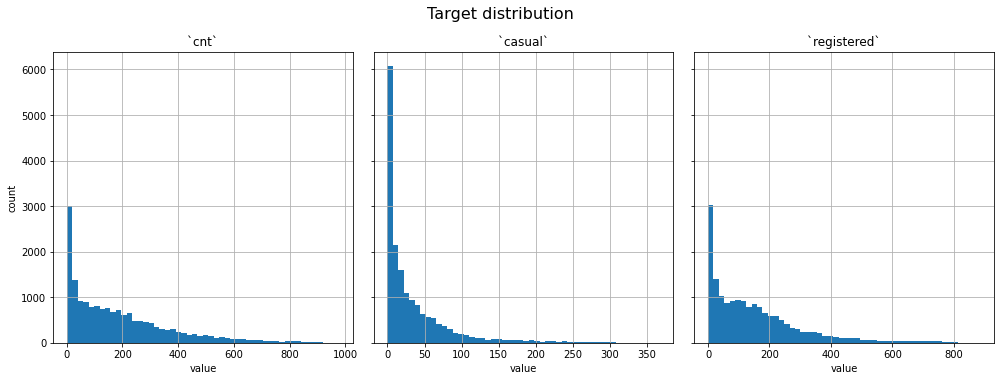

In [13]:
# They are skewed and has long tail

fig, ax = plt.subplots(1,3, sharey=True, figsize=(14, 5))
for i, col in enumerate(target_cols):
    data[col].hist(bins=50, ax=ax[i])
    ax[i].set_title(f'`{col}`')
    ax[i].set_xlabel('value')
ax[0].set_ylabel('count')
plt.suptitle('Target distribution', fontsize=16, y=1.05)
plt.tight_layout();

Target will not be log-transformed as it might not be a problem for tree-based algorithms which we are going to use. But log-transformation would help with possible negative predictions, otherwise we need to clip values to zero.

We should be awared that data is basically time series. On time plots year pattern can be seen clearly. More over there are weekly and daily patterns, as we will investigate later. General conclusion is that bike rentals demand has growing trend and *'seasonality'* issues.

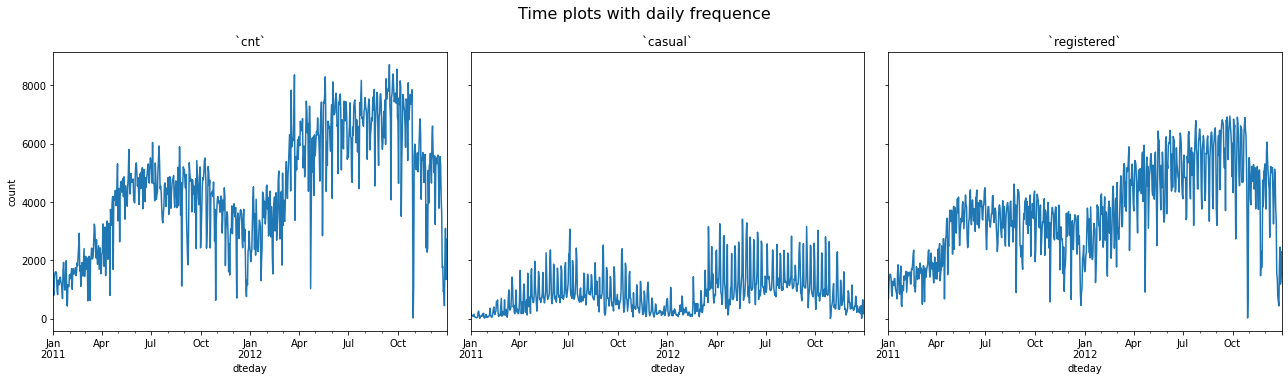

In [14]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for i, col in enumerate(target_cols):
    ts = data[['dteday', col]].set_index('dteday').squeeze()
    ts.resample('d').sum().plot(ax=ax[i])
    ax[i].set_title(f'`{col}`')
ax[0].set_ylabel('count')
plt.suptitle('Time plots with daily frequence', fontsize=16, y=1.05)
plt.tight_layout();

## Categorical features
There are five features describing timestamp directly (year, season, month, day of the week, hour), two features acting as flags (holiday, workingday) and one feature for a qualitative description of the weather situation. 

**Hour variable**

On average, response of target variables to the `hr` feature changes drastically during a day - it might have a strong predictive power. 

Naturally, night hours have least counts. Variables `cnt` and `registered` are similary two humped - we can see morning and evening patterns. Unlike `casual` variable is one humped with peak at the middle of the day. Confidence intervals of average counts for casual users are wide (high fluctuations of the value)

Also there is growth trend from year=0 to year=1

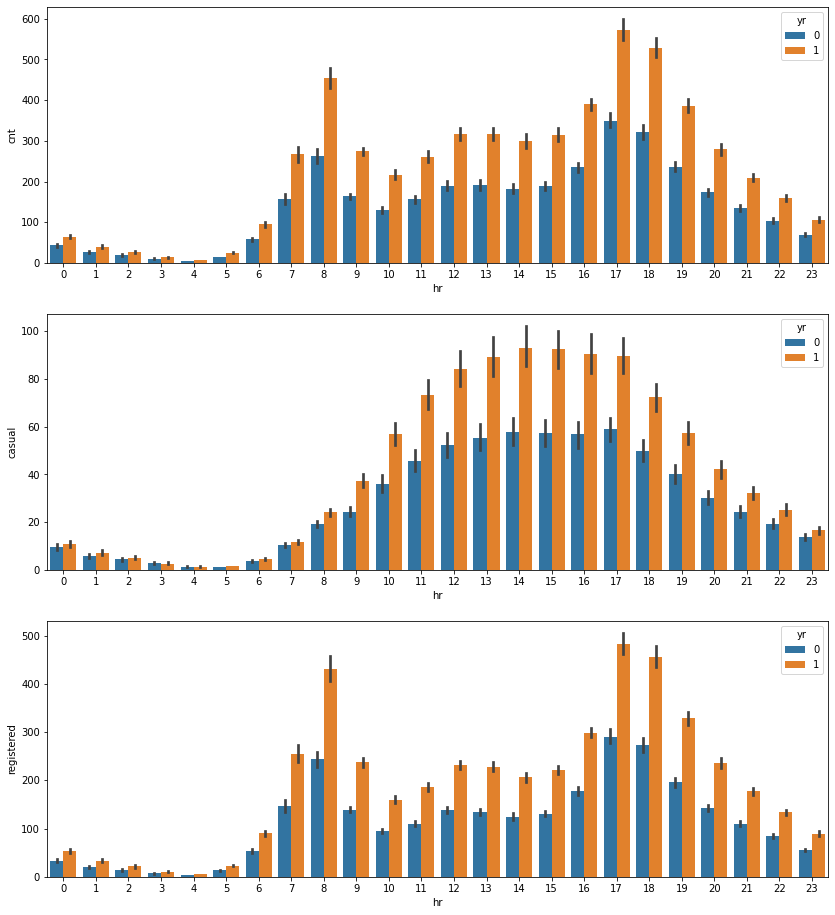

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(14, 16))
for i, col in enumerate(target_cols):
    sns.barplot(data=data, x='hr', y=col, hue='yr', ax=ax[i])

**Weekday**

At first sight, looking at `cnt` target, there is small difference of average counts per weekdays. But `casual` and `registered` average counts have different patterns - more casual users on weekends, as registered users rent bikes a bit often on working days.

Again, we can see significant counts growth on second year.

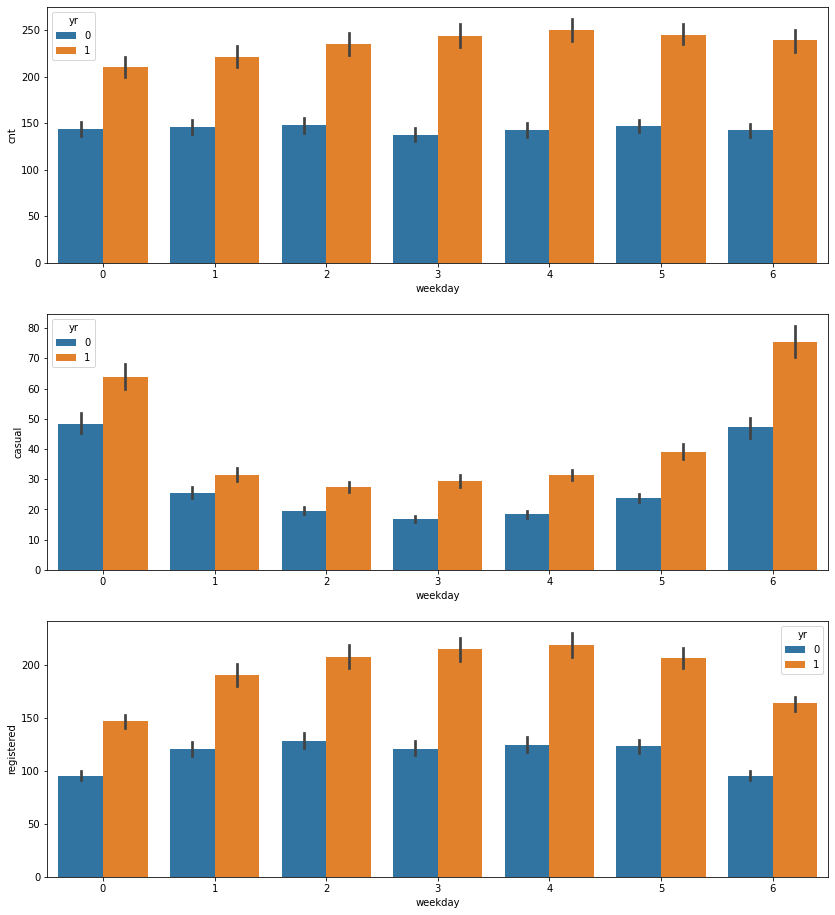

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(14, 16))
for i, col in enumerate(target_cols):
    sns.barplot(data=data, x='weekday', y=col, hue='yr', ax=ax[i])

Interaction of `hr` and `weekday` features and average target response can be seen below on lineplots. Maximums of total bike rents are roughly at 8 a.m. and 17 p.m. on working days. Minimal value of counts is around 4 a.m.

Weekend days hour curves differ from working days by having maximum average counts in the middle of the day around 13 p.m. (with wide confidence intervals so). Casual users input is high in this case. Also slightly higher demand is observed on Fridays, as for working days.

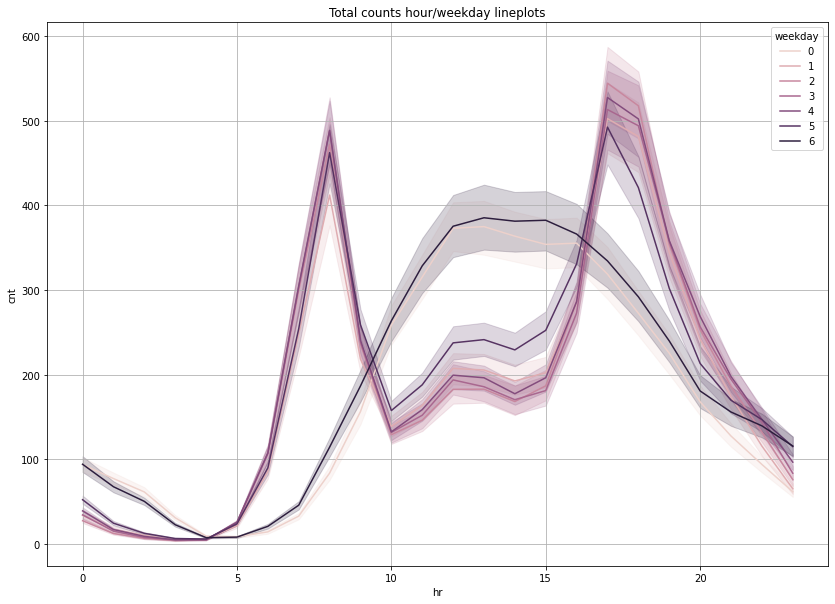

In [17]:
plt.figure(figsize=(14, 10))
sns.lineplot(data=data, x='hr', y='cnt', hue='weekday')
plt.title('Total counts hour/weekday lineplots')
plt.grid();

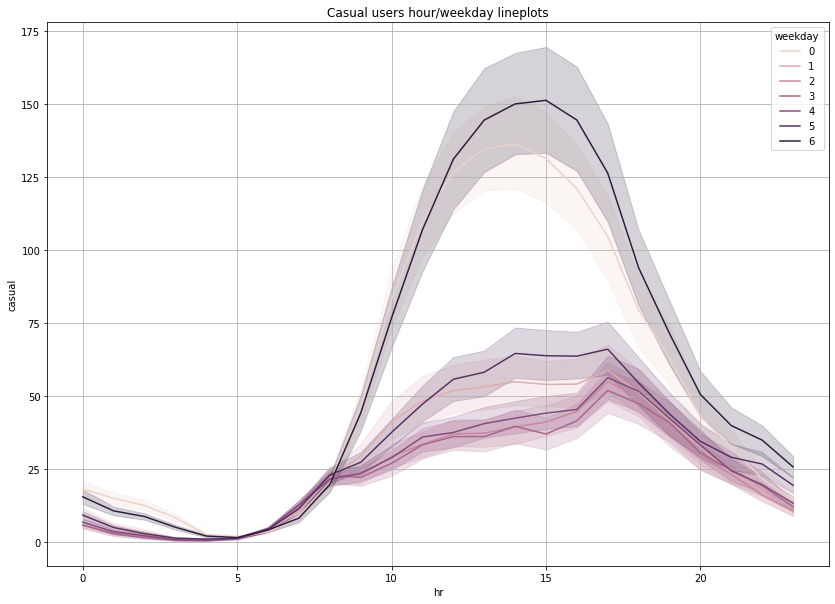

In [18]:
plt.figure(figsize=(14, 10))
sns.lineplot(data=data, x='hr', y='casual', hue='weekday')
plt.title('Casual users hour/weekday lineplots')
plt.grid();

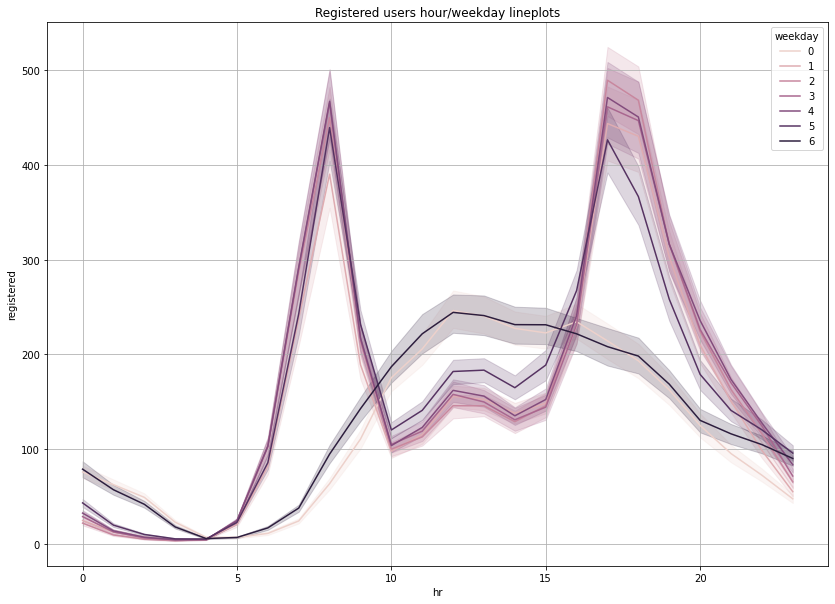

In [19]:
plt.figure(figsize=(14, 10))
sns.lineplot(data=data, x='hr', y='registered', hue='weekday')
plt.title('Registered users hour/weekday lineplots')
plt.grid();

**Month**

Months with more comfortable weather conditions (summer f.e.) have more counts. Small pattern difference between casual and registered users can be observed in July of first year. Casual users tend less to rent bike in cold months.

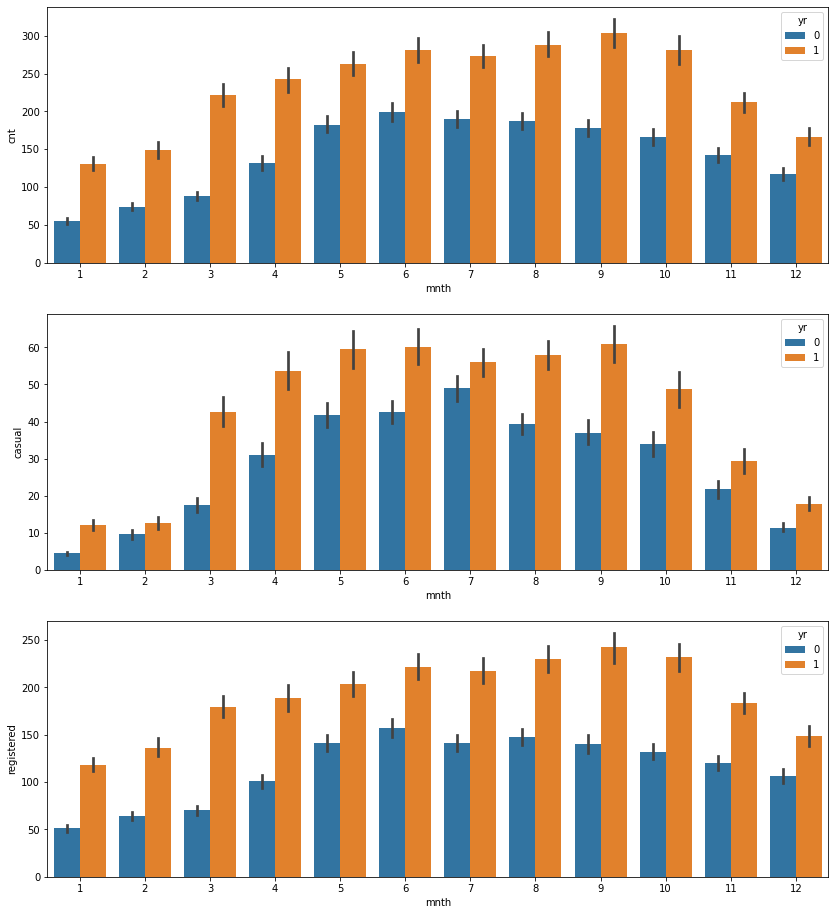

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(14, 16))
for i, col in enumerate(target_cols):
    sns.barplot(data=data, x='mnth', y=col, hue='yr', ax=ax[i])

**Season**

Expectedly summer (`season`==3) has more bike rentals count on average, and winter (`season`==1) has less. No notable difference between target variables, but again - casual users demand drops more significantly in winter and autumn.

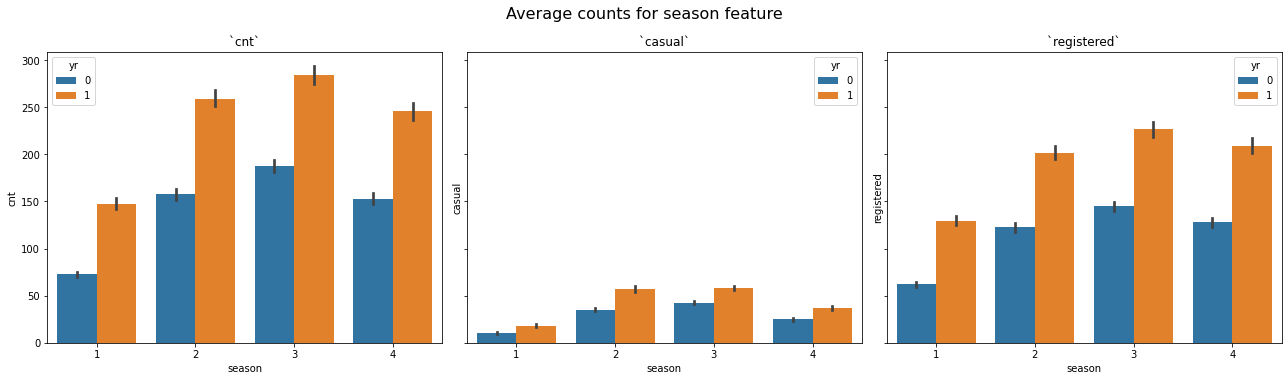

In [21]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18, 5))
for i, col in enumerate(target_cols):
    sns.barplot(data=data, x='season', y=col, hue='yr', ax=ax[i])
    ax[i].set_title(f'`{col}`')
plt.suptitle('Average counts for season feature', fontsize=16, y=1.05)
plt.tight_layout();

**Holiday**

There are around of 3% of observations matching holiday. Alone it might have small predictive power. But it's interaction with `workingday` and `weekday` features should be considered.

Casual users average count is higher on holidays, as registered users vice versa. But confidence interval of the `holiday==1` average counts is wider.

In [22]:
data['holiday'].value_counts(normalize=True)

0    0.97123
1    0.02877
Name: holiday, dtype: float64

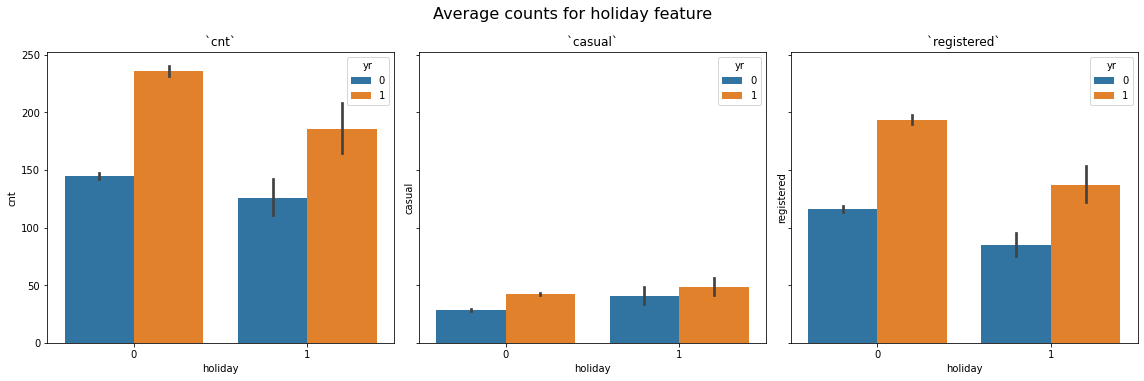

In [23]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(16, 5))
for i, col in enumerate(target_cols):
    sns.barplot(data=data, x='holiday', y=col, hue='yr', ax=ax[i])
    ax[i].set_title(f'`{col}`')
plt.suptitle('Average counts for holiday feature', fontsize=16, y=1.05)
plt.tight_layout();

There is slight difference between casual and registered users demand on holidays - we can see morning and evening peaks with high confidence intervals for registered users.

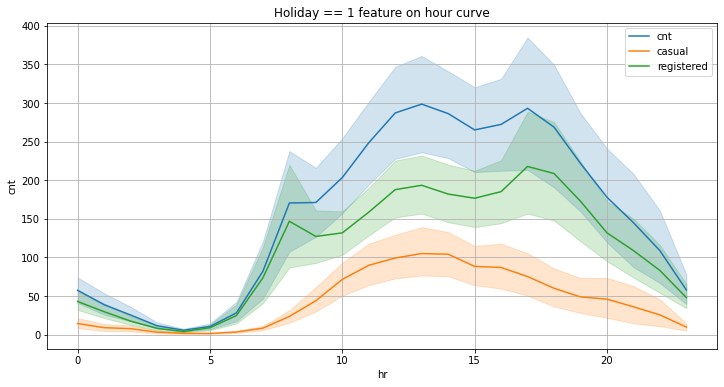

In [24]:
hol = data.holiday == 1
fig = plt.figure(figsize=(12, 6))
for col in target_cols:
    sns.lineplot(data=data.loc[hol, :], y=col, x='hr', label=col)
plt.grid()
plt.title('Holiday == 1 feature on hour curve');

**Workingday**

Naturally, more than two thirds of observations match working days.

Opposite to `holiday` feature, casual users have less count on average in working days.

In [25]:
data['workingday'].value_counts(normalize=True)

1    0.682721
0    0.317279
Name: workingday, dtype: float64

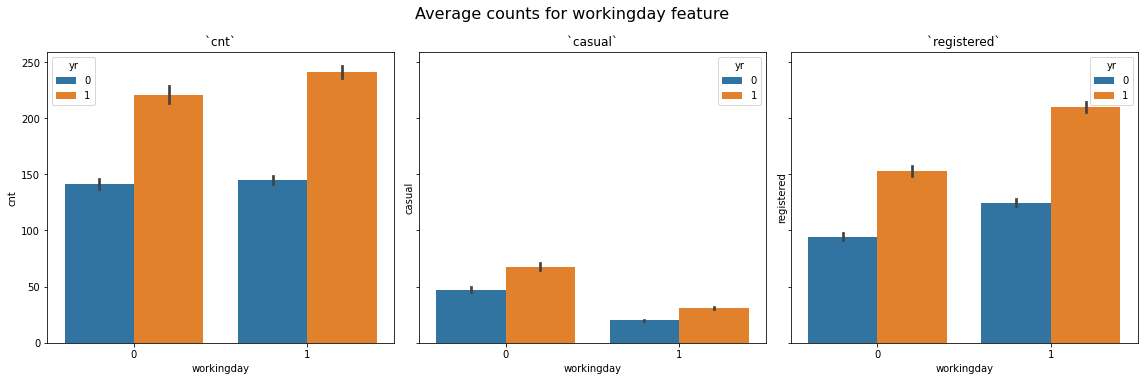

In [26]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(16, 5))
for i, col in enumerate(target_cols):
    sns.barplot(data=data, x='workingday', y=col, hue='yr', ax=ax[i])
    ax[i].set_title(f'`{col}`')
plt.suptitle('Average counts for workingday feature', fontsize=16, y=1.05)
plt.tight_layout();

None of the weekends in the dataset does not consider as a working day or a holiday. That means `holiday`, `workingday` and weekend days are exclusive.

In [27]:
weekend = data.holiday == data.workingday
data.loc[weekend, :].weekday.value_counts()

6    2512
0    2502
Name: weekday, dtype: int64

On lineplots below hourly demand for every target variable on working/not working days can bee seen.

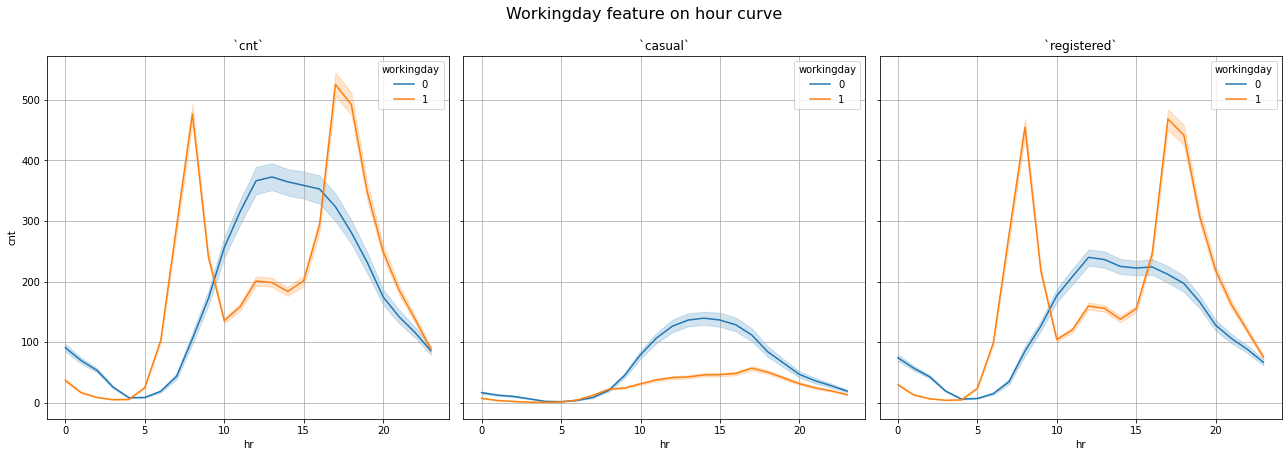

In [28]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18, 6))
for i, col in enumerate(target_cols):
    sns.lineplot(data=data, y=col, x='hr', hue='workingday', ax=ax[i])
    ax[i].set_title(f'`{col}`')
    ax[i].grid()
plt.suptitle('Workingday feature on hour curve', fontsize=16, y=1.05)
plt.tight_layout();

**Weather situation**

If we check number of observations in each category of this feature, we see an insignificance of forth category. As it will not bring any predictive power to the model, we concatenate this category to third one.

Naturally worse weather conditions lead to less count, true for all target variables.

In [29]:
# number of categories of `weathersit` feature
data['weathersit'].value_counts()

1    11413
2     4544
3     1419
4        3
Name: weathersit, dtype: int64

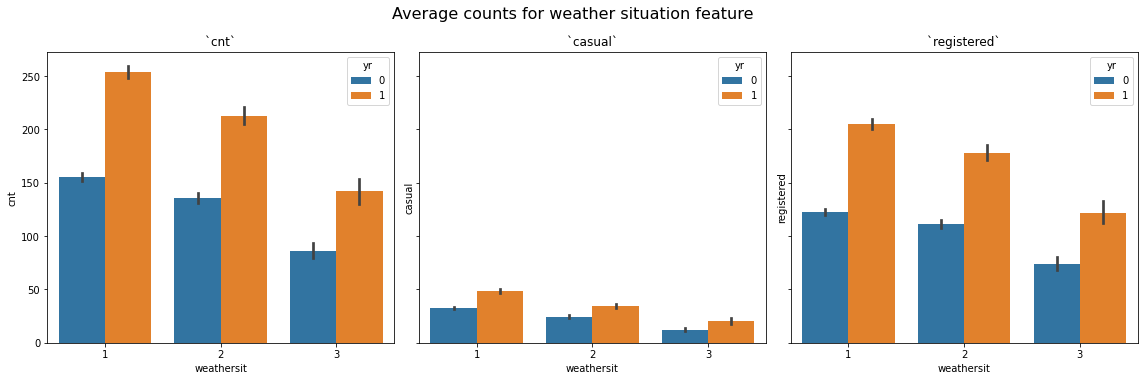

In [30]:
# barplots after merging 3 and 4 categories
data['weathersit'].replace(to_replace=4, value=3, inplace=True)

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(16, 5))
for i, col in enumerate(target_cols):
    sns.barplot(data=data, x='weathersit', y=col, hue='yr', ax=ax[i])
    ax[i].set_title(f'`{col}`')
plt.suptitle('Average counts for weather situation feature', fontsize=16, y=1.05)
plt.tight_layout();

Surprisingly `weathersit` feature has strong enough correlation with *humidity* (`hum` column). The higher is humidity value - the worse is weather situation tends to be (`weathersit`==3 f.e.). 

`temp` has weak inverse correlation - the higher is temperature, the better is weather situation (`weathersit`==1 f.e.).

In [31]:
weather_corr = pd.DataFrame(data[['atemp', 'temp', 'hum', 'windspeed', 'weathersit']].corr().\
                            unstack().sort_values(ascending=False)['weathersit'].\
                            drop(labels='weathersit'), columns=['Correlation to the weathersit'])
weather_corr.style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

,Correlation to the weathersit
hum,0.418138
windspeed,0.026218
temp,-0.102294
atemp,-0.105201


### Categorical feature importance

For measuring feature importance, mutual information score from `sklearn` was used. Target variables were converted to categorical type with quantile binning.

Most important feature is `hr` as expected, true for all targets. Some features have higher score for `casual` target.


In [32]:
# Prepare data for seaborn barplot
scores = list()
for i, col in enumerate(target_cols):
    cat_target = pd.qcut(data[col], q=10)
    col_scores = [mutual_info_score(data[col], cat_target) for col in cat_cols]
    scores.append(col_scores)
df_scores = pd.DataFrame(np.array(scores), columns=cat_cols, index=target_cols).\
                         reset_index().rename(columns={'index': 'Target'})
df_scores = pd.melt(df_scores, id_vars=['Target'], value_vars=cat_cols) 

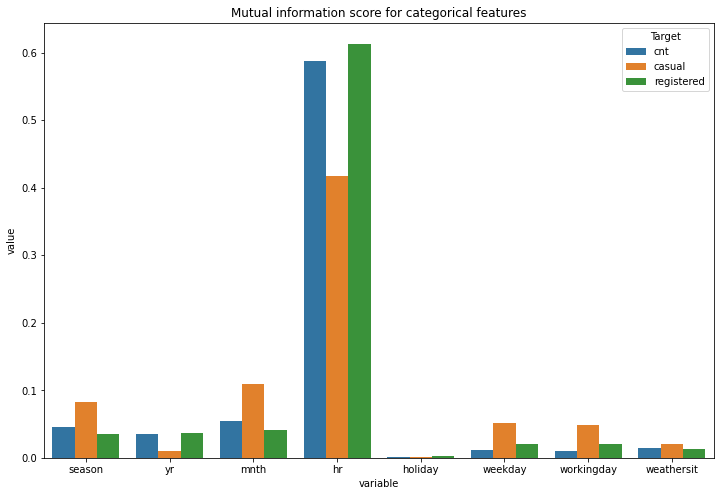

In [33]:
fig = plt.figure(figsize=(12, 8))
sns.barplot(data=df_scores, x='variable', y='value', hue='Target')
plt.title('Mutual information score for categorical features');

Also, having categorical features encoded already, we can check pearson correlation of some features with target variable.

In [34]:
cnt_corr = pd.DataFrame(data[['hr', 'mnth', 'weekday', 'season', 'weathersit', 'cnt']].corr().\
                            unstack().sort_values(ascending=False)['cnt'].\
                            drop(labels='cnt'), columns=['Correlation to the total count'])
cnt_corr.style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

,Correlation to the total count
hr,0.394071
season,0.178056
mnth,0.120638
weekday,0.026900
weathersit,-0.142380


## Numerical features

There are four features that describes weather quantitatively.

In [35]:
# statistical info
pd.set_option("display.precision", 2)
all_num_cols = num_cols + target_cols
data[all_num_cols].describe()

,atemp,temp,hum,windspeed,cnt,casual,registered
count,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00
mean,0.48,0.50,0.63,0.19,189.46,35.68,153.79
std,0.17,0.19,0.19,0.12,181.39,49.31,151.36
min,0.00,0.02,0.00,0.00,1.00,0.00,0.00
25%,0.33,0.34,0.48,0.10,40.00,4.00,34.00
50%,0.48,0.50,0.63,0.19,142.00,17.00,115.00
75%,0.62,0.66,0.78,0.25,281.00,48.00,220.00
max,1.00,1.00,1.00,0.85,977.00,367.00,886.00


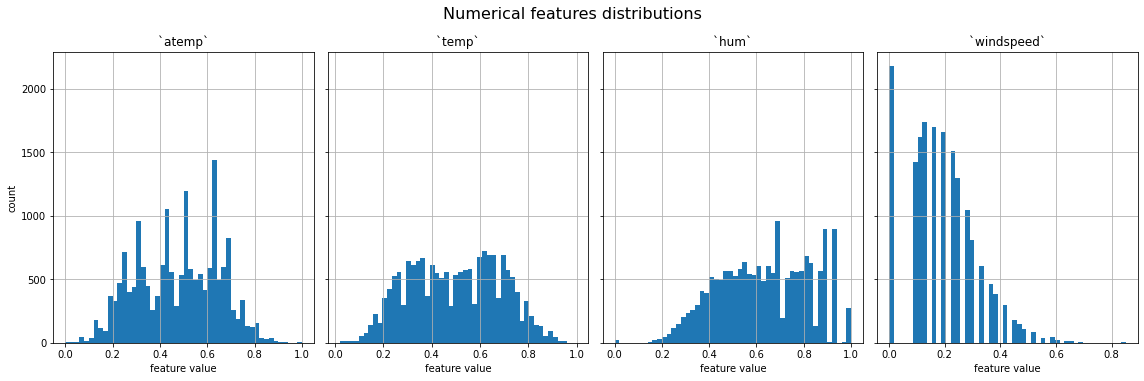

In [36]:
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(16, 5))
for i, col in enumerate(num_cols):
    data[col].hist(bins=50, ax=ax[i])
    ax[i].set_title(f'`{col}`')
    ax[i].set_xlabel('feature value')
ax[0].set_ylabel('count')
plt.suptitle('Numerical features distributions', fontsize=16, y=1.05)
plt.tight_layout();

**Temperature**

Temperature might be  another strong feature. Demand depends on temperature - it grows steadily until *too hot* values. After that drastical fluctuations are observed due to rare observations with high temperatures.

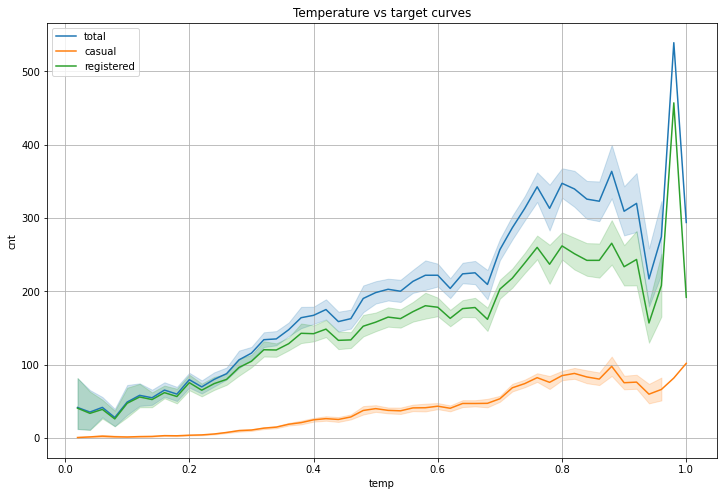

In [37]:
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=data, x='temp', y='cnt', label='total')
sns.lineplot(data=data, x='temp', y='casual', label='casual')
sns.lineplot(data=data, x='temp', y='registered', label='registered')
plt.title('Temperature vs target curves')
plt.grid()
plt.legend();

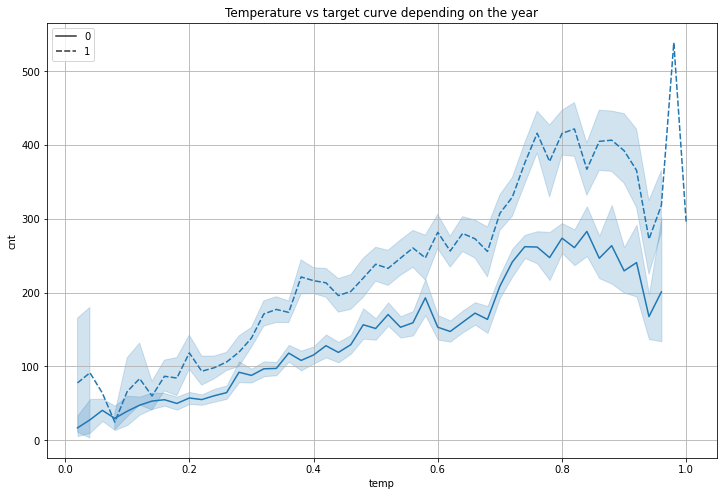

In [38]:
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=data, x='temp', y='cnt', style='yr')
plt.title('Temperature vs target curve depending on the year')
plt.grid()
plt.legend();

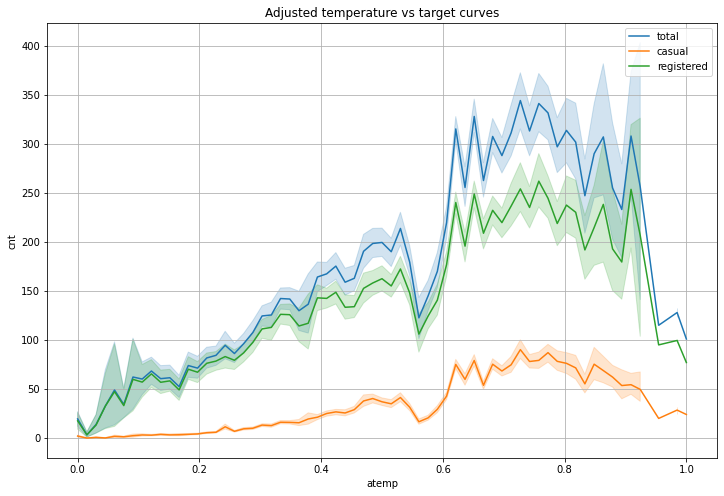

In [39]:
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=data, x='atemp', y='cnt', label='total')
sns.lineplot(data=data, x='atemp', y='casual', label='casual')
sns.lineplot(data=data, x='atemp', y='registered', label='registered')
plt.title('Adjusted temperature vs target curves')
plt.grid()
plt.legend();

**Humidity**

We see negative correlation of humidity with target variables. But the behavior of the curves is not stable.

Also there are zero values during whole day `2011-03-10`. We leave these 22 missing values as it is.

In [199]:
data.loc[data.hum == 0, ['dteday', 'hum', 'hr']]

,dteday,hum,hr
1551,2011-03-10,0.0,0
1552,2011-03-10,0.0,1
1553,2011-03-10,0.0,2
1554,2011-03-10,0.0,5
1555,2011-03-10,0.0,6
1556,2011-03-10,0.0,7
1557,2011-03-10,0.0,8
1558,2011-03-10,0.0,9
1559,2011-03-10,0.0,10
1560,2011-03-10,0.0,11


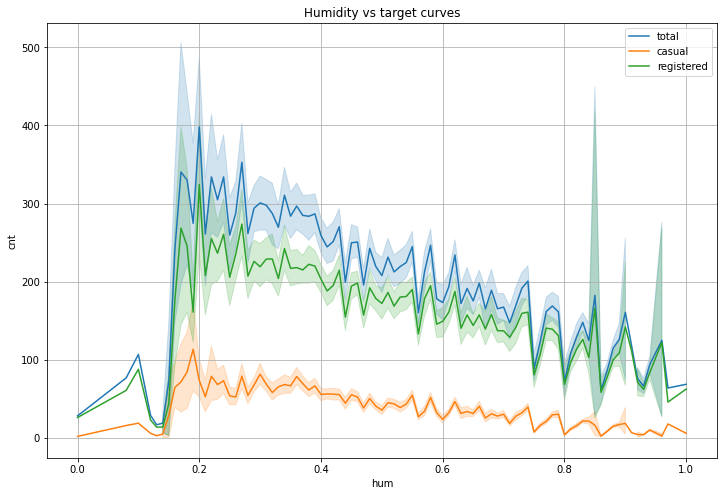

In [40]:
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=data, x='hum', y='cnt', label='total')
sns.lineplot(data=data, x='hum', y='casual', label='casual')
sns.lineplot(data=data, x='hum', y='registered', label='registered')
plt.title('Humidity vs target curves')
plt.grid()
plt.legend();

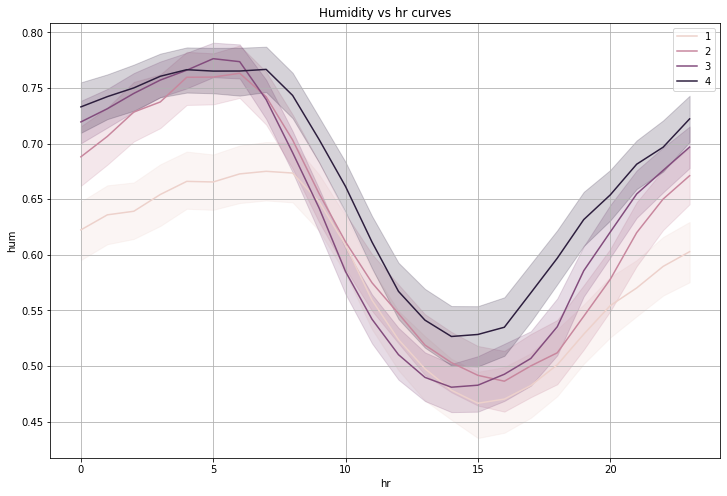

In [203]:
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=data, x='hr', y='hum', hue='season')
plt.title('Humidity vs hr curves')
plt.grid()
plt.legend();

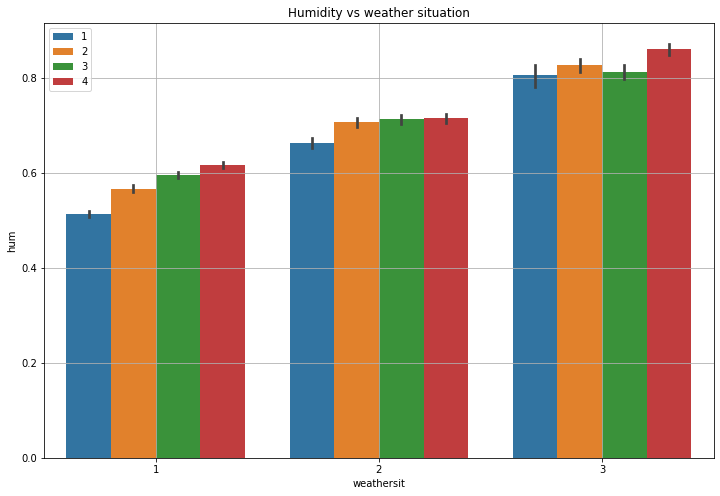

In [207]:
fig = plt.figure(figsize=(12, 8))
sns.barplot(data=data, y='hum', x='weathersit', hue='season')
plt.title('Humidity vs weather situation')
plt.grid()
plt.legend();

So, humidity fluctuates during a day, usually having a minimum around 15 a.m., which is true for all seasons. 

Bad weather situation can be connected with high humidity (more than 80 points), and good weather conditions match low humidity (around 50-60 points).

**Windspeed**

As we can see from `windspeed` distribution plot, 12.5% of the observations are zeros. One may consider zeros as missing data or effects of measurement errors, but we can't prove it.

Interaction of `windspeed` with other features shown on the plots below.

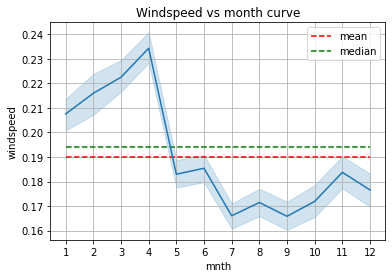

In [41]:
sns.lineplot(data=data, x='mnth', y='windspeed')
plt.title('Windspeed vs month curve')
plt.xticks(np.arange(13))
plt.hlines(data.windspeed.mean(), 1, 12, color='red', ls='--', label='mean')
plt.hlines(data.windspeed.median(), 1, 12, color='green', ls='--', label='median')
plt.legend()
plt.grid();

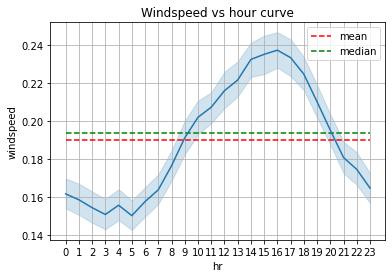

In [42]:
# windspeed is getting stronger at 15-16 p.m. on average
# with minimum at night hours.
sns.lineplot(data=data, x='hr', y='windspeed')
plt.title('Windspeed vs hour curve')
plt.xticks(np.arange(24))
plt.hlines(data.windspeed.mean(), 0, 23, color='red', ls='--', label='mean')
plt.hlines(data.windspeed.median(), 0, 23, color='green', ls='--', label='median')
plt.legend()
plt.grid();

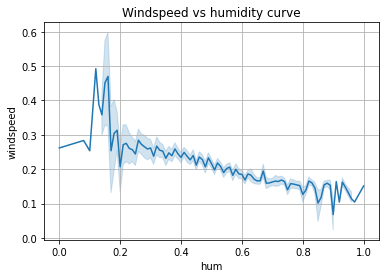

In [43]:
sns.lineplot(data=data, x='hum', y='windspeed')
plt.title('Windspeed vs humidity curve')
plt.grid();

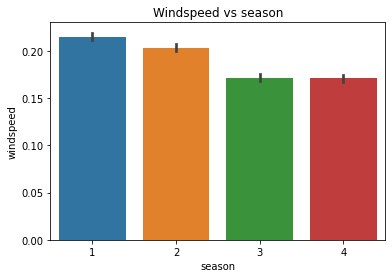

In [44]:
# windspeed is higher in winter and spring
sns.barplot(data=data, x='season', y='windspeed')
plt.title('Windspeed vs season');

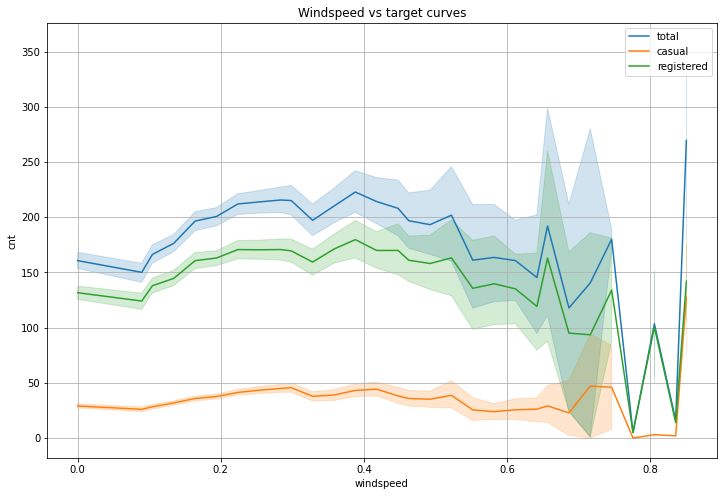

In [45]:
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=data, x='windspeed', y='cnt', label='total')
sns.lineplot(data=data, x='windspeed', y='casual', label='casual')
sns.lineplot(data=data, x='windspeed', y='registered', label='registered')
plt.title('Windspeed vs target curves')
plt.grid()
plt.legend();

In [46]:
# pearson correlation coefficients with some features
wind_corr = pd.DataFrame(data[['hr', 'mnth', 'season', 'weathersit', 'hum', 'temp', 'windspeed']].corr().\
                            unstack().sort_values(ascending=False)['windspeed'].\
                            drop(labels='windspeed'), columns=['Correlation to the windspeed'])
wind_corr.style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

,Correlation to the windspeed
hr,0.14
weathersit,0.03
temp,-0.02
mnth,-0.14
season,-0.15
hum,-0.29


### Numerical feature importance

Pearson standard correlation is used to measure numerical feature importance. 

Firstly, high correlation of `temp` with `atemp` should be noticed. Can't use them both so. As expected, temperature has high positive correlation with target variables.

Secondly, *humidity* has negative correlation with target variables as expected. This is another good numerical feature wich should be used if *adjusted temperature* (`atemp`) will be dropped.

Windspeed is the weakest feature amongst numeric ones, but not useless enough to be discounted.  It has good interactions with other features as we saw on the plots above.

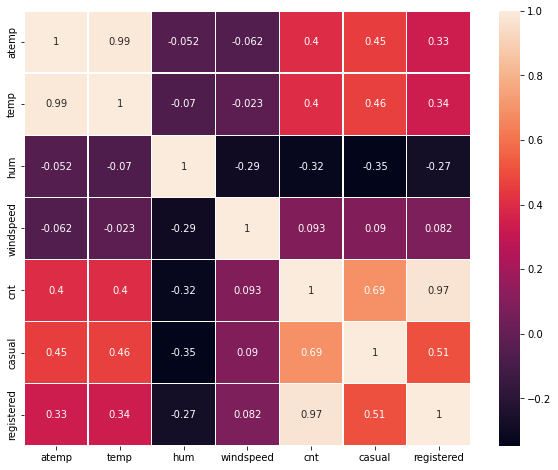

In [47]:
fig = plt.figure(figsize=(10, 8))
sns.heatmap(data[all_num_cols].corr(), annot=True, linewidths=.3);

# Feature Engineering

## Binning `hr` feature with respect to target variables `casual` and `registered`

Binning is done with help of simple Decision tree

**RegisteredHourBins**

In [48]:
# Fit the Decision tree with GridSearchCV for best parameters
X = data.hr
y = data.registered
params = {'max_depth':[2, 3, 4], 'max_leaf_nodes':[3, 4, 5, 6, 7, 9]}
dt = DecisionTreeRegressor()
grid = GridSearchCV(dt, param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X.values.reshape(-1, 1), y)
dt = DecisionTreeRegressor(**grid.best_params_)
dt.fit(X.values.reshape(-1, 1), y)

DecisionTreeRegressor(max_depth=4, max_leaf_nodes=9)

In [49]:
# Bins are thresholds of Decision tree. 
np.sort(dt.tree_.threshold[dt.tree_.threshold > -2])

array([ 1.5,  5.5,  6.5,  8.5, 16.5, 18.5, 20.5, 22.5])

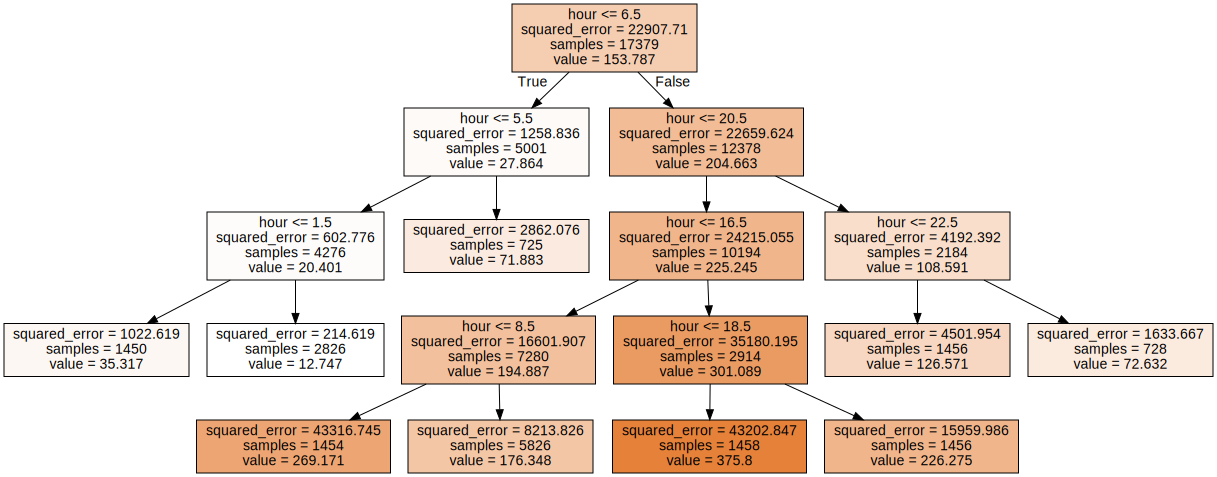

In [50]:
# Here we can see how binning works
export_graphviz(dt, out_file='decision_tree.dot', feature_names=['hour'], filled=True)

with open('decision_tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [51]:
# bins must be sorted
bins = np.sort(dt.tree_.threshold[dt.tree_.threshold > -2])
# labels for bins
labels = np.arange(len(bins)-1)
# getting new feature
data['RegisteredHourBins'] = pd.cut(data['hr'], bins=bins, labels=labels).fillna(0).astype(int)

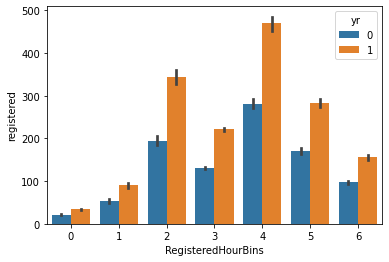

In [52]:
# visualize target distribution for new feature
# we can see that labels are not ordered by average value of the target
# it might be a problem as we consider this new feature as categorical
sns.barplot(x='RegisteredHourBins', y='registered', hue='yr', data=data)

In [53]:
# sorting labels so the encoding looks like Ordinal
sorted_labels = np.argsort(data.groupby('RegisteredHourBins')['registered'].mean()).values
remap_labels = {k:v for k,v in zip(sorted_labels, labels)}
data['RegisteredHourBins'] = data['RegisteredHourBins'].map(remap_labels)

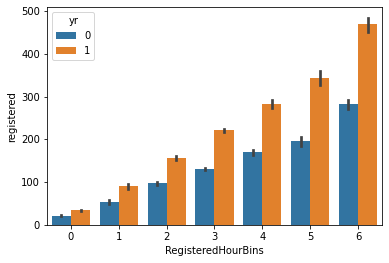

In [54]:
sns.barplot(x='RegisteredHourBins', y='registered', hue='yr', data=data)

In [55]:
# this dictionary will be usefull for mapping new data after binning 
remap_labels

{0: 0, 1: 1, 2: 5, 3: 3, 4: 6, 5: 4, 6: 2}

**CasualHourBins**

In [56]:
X = data.hr
y = data.casual
params = {'max_depth':[3, 4], 'max_leaf_nodes':[3, 4, 5, 6, 7]}
dt = DecisionTreeRegressor()
grid = GridSearchCV(dt, param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X.values.reshape(-1, 1), y)
dt = DecisionTreeRegressor(**grid.best_params_)
dt.fit(X.values.reshape(-1, 1), y)

DecisionTreeRegressor(max_depth=4, max_leaf_nodes=7)

In [57]:
dt.tree_.threshold[dt.tree_.threshold > -2]

array([ 8.5,  7.5, 19.5, 10.5, 21.5, 17.5])

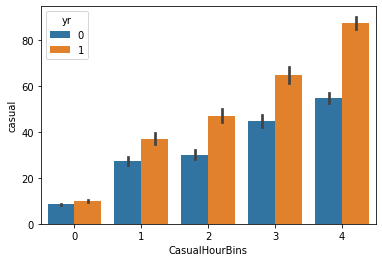

In [58]:
bins = np.sort(dt.tree_.threshold[dt.tree_.threshold > -2])
labels = np.arange(len(bins)-1)
data['CasualHourBins'] = pd.cut(data['hr'], bins=bins, labels=labels).fillna(0).astype(int)
sorted_labels = np.argsort(data.groupby('CasualHourBins')['casual'].mean()).values
remap_labels = {k:v for k,v in zip(sorted_labels, labels)}
data['CasualHourBins'] = data['CasualHourBins'].map(remap_labels)
sns.barplot(x='CasualHourBins', y='casual', hue='yr', data=data)

In [59]:
remap_labels

{0: 0, 1: 2, 2: 4, 3: 3, 4: 1}

## Day_type feature

To combine `holiday` and `workingday` features into single feature with more predictive power. 

`day_type` feature encoding:
* working day - 2
* weekend - 1
* holiday - 0


In [60]:
# if `holiday` is equal to 1, we encode observation as 0, otherwise - 2
data['day_type'] = np.where(data['holiday'] == 1, 0, 2)
# if `weekday` is saturday or sunday, encode observation as 1, otherwise leave it as it is
data['day_type'] = np.where((data['weekday'] == 6) | (data['weekday'] == 0), 1, data['day_type'])

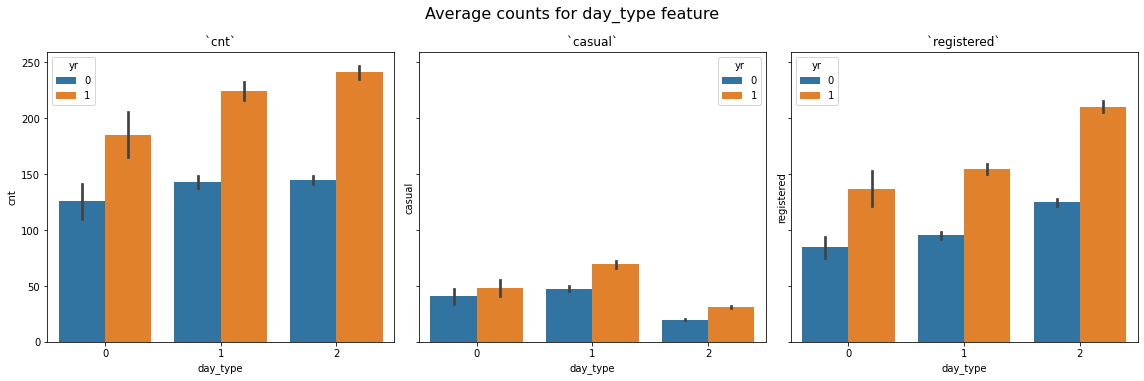

In [61]:
# new feature distribution
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(16, 5))
for i, col in enumerate(target_cols):
    sns.barplot(data=data, x='day_type', y=col, hue='yr', ax=ax[i])
    ax[i].set_title(f'`{col}`')
plt.suptitle('Average counts for day_type feature', fontsize=16, y=1.05)
plt.tight_layout();

## Features based on previous values 
As our data is actually a time series, it might be a good idea to use general approach - look at the values in the past to forecast future. Four features were created:
* average number of bikes that were rented by casual users in each of the previous 12 hours;
* average number of bikes that were rented by registered users in each of the previous 12 hours;
* number of bikes that were rented by casual users in each of the previous 3 days at the same hour;
* number of bikes that were rented by registered users in each of the previous 3 days at the same hour.

Each of these features captures different aspects of the time series problem:
* first two capture very recent demand for the bikes;
* second two capture the demand for bikes at a particular hour in previous days.

In [62]:
# using rolling method of pandas library with window 12, agregating values with mean function
data['rolling_mean_12_hours_casual'] = data['casual'].rolling(min_periods=1, window=12).mean()
data['rolling_mean_12_hours_registered'] = data['registered'].rolling(min_periods=1, window=12).mean()

# using shift method, forwarding ahead past values with periods of 1, 2, 3 days respectively
# results are adding up
data['3_days_sum_casual'] = data['casual'].shift(24, fill_value=0) + data['casual'].shift(48, fill_value=0) + data['casual'].shift(72, fill_value=0)
data['3_days_sum_registered'] = data['registered'].shift(24, fill_value=0) + data['registered'].shift(48, fill_value=0) + data['registered'].shift(72, fill_value=0)

In [63]:
# define the feature spaces
num_cols = ['temp', 'hum', 'windspeed', 'hr', 
            '3_days_sum_registered',
            '3_days_sum_casual',
            'rolling_mean_12_hours_registered',
            'rolling_mean_12_hours_casual',
]
cat_cols = ['season', 'yr', 'mnth',  'day_type', 'weathersit', 
            'RegisteredHourBins', 'CasualHourBins', 'weekday',
]
features = cat_cols + num_cols
print(f'Total number of features: {len(features)}')

Total number of features: 16


# Splitting the data
Usual methods of splitting data for training and evaluating purposes cannot be directly used with time series data. We cannot randomly split observations of time series data into groups and shuffle them, like these observations are independent. Instead, we must split data up with respect to the temporal order in which values were observed.

In this project we suggest a real-world scenario that we will retrain our model as new data becomes available. Let time step for the model update will be a month (defines minimum number of observations in validation/test set). So, during a month new data is gathered, and then feeded to machine learning model for update. This is walk-forward validation method.

## Single split
Typical approach for time-series is to make a split by time, taking the most recent data as a validation/test set, as seen in the visualization below. We set aside two last months observations of the two year period - one month for validation set and one month for test set. In such way we simulate the gap between model updates (one months, or approximately 672 hours).

In [ ]:
# split data to TRAIN, VALIDATION and TEST sets with respect to time series problem

val_len = 24 * 7 * 4
test_len = 24 * 7 * 4

X_train_full, y_train_full = data[features].iloc[:-test_len, :], data.cnt.iloc[:-test_len]
X_test, y_test = data[features].iloc[-test_len:, :], data.cnt.iloc[-test_len:]

X_train, y_train = X_train_full.iloc[:-val_len, :], y_train_full.iloc[:-val_len]
X_val, y_val = X_train_full.iloc[-val_len:, :], y_train_full.iloc[-val_len:]

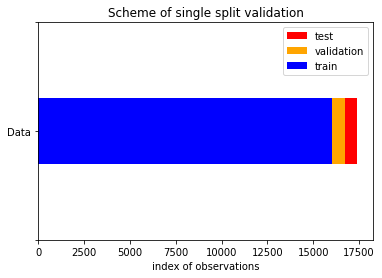

In [ ]:
# scheme of the single split
plt.barh(2, width=len(data), label='test', height=0.6, color='red')
plt.barh(2, width=len(data) - len(X_test), label='validation', height=0.6, color='orange')
plt.barh(2, width=len(X_train), label='train', height=0.6, color='blue')
plt.yticks([1, 2, 3], labels=["", "Data", ""])
plt.xlabel('index of observations')
plt.title('Scheme of single split validation')
plt.legend();

In [ ]:
(len(X_val) + len(X_train) + len(X_test)) == len(data)

True

In [ ]:
print(len(X_train), len(X_val), len(X_test))

16035 672 672


## Timeseries crossvalidation splitting
We will use `TimeSeriesSplit` class from `sklearn` to perform time series k-fold crossvalidation with expanding window. There is a visualization of the  behavior of the used crossvalidation scheme below.



In [ ]:
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48, # Number of samples to exclude from the end of each train set before the test set
    test_size= 24 * 7 * 4, # minimal number of the observations for validation
)

In [ ]:
bars = list()
print('Train       :  Test')
print('-'*30)
for fold, (train_indx, test_indx) in enumerate(ts_cv.split(X_train_full)):
    bars.append([(fold + 1, test_indx[-1]),  
                (fold + 1, test_indx[0]),
                (fold + 1, train_indx[-1])])
    print(train_indx[0],'...', train_indx[-1], ':', test_indx[0], '...', test_indx[-1])

Train       :  Test
------------------------------
0 ... 13298 : 13347 ... 14018
0 ... 13970 : 14019 ... 14690
0 ... 14642 : 14691 ... 15362
0 ... 15314 : 15363 ... 16034
0 ... 15986 : 16035 ... 16706


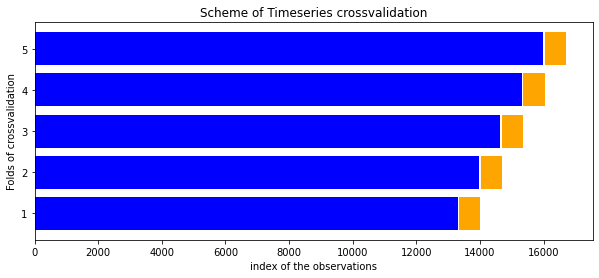

In [ ]:
fig = plt.figure(figsize=(10, 4))
colors = ['orange', 'white', 'blue']

for bar in bars:
    for color, b in zip(colors, bar):
        plt.barh(b[0], b[1], color=color)

plt.ylabel('Folds of crossvalidation')
plt.xlabel('index of the observations')
plt.title('Scheme of Timeseries crossvalidation');

# Model selection
Regression task, choosing best model from Catboost, RandomForest, HistGradientBoosting, XGBoost, LightGBM

In [ ]:
# function to plot feature importances
def plot_importances(model_name, importances):
    feat_imp = pd.DataFrame(zip(features, importances), 
             columns=['Feature Id', 
                      'Importances']).sort_values(by='Importances', 
                                      ascending=False).reset_index(drop=True)
    plt.figure(figsize=(6, 8)); 
    sns.barplot(x="Importances", y="Feature Id", data=feat_imp)
    plt.title(f'{model_name} features importances:')
    plt.show;

### Baselines on single split
Using `X_train`, `y_train` for training, `X_val`, `y_val` - for model evaluation.

**1. Catboost**

In [ ]:
# forming data pools
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool = Pool(X_val, y_val, cat_features=cat_cols)

In [ ]:
# Initialize the Catboost regressor with default parameters
ctb = CatBoostRegressor(loss_function='RMSE',
                        eval_metric='RMSE',
                        random_state=SEED,
                        early_stopping_rounds=50,
                        verbose=50)

In [ ]:
# train regressor with overfitting control
ctb.fit(train_pool, eval_set=test_pool, 
        use_best_model=True, plot=False)

Learning rate set to 0.078721
0:	learn: 172.9561075	test: 171.8045774	best: 171.8045774 (0)	total: 30.8ms	remaining: 30.8s
50:	learn: 51.9485647	test: 68.2281455	best: 68.2281455 (50)	total: 1.2s	remaining: 22.3s
100:	learn: 42.8908969	test: 59.6287160	best: 59.6287160 (100)	total: 2.36s	remaining: 21s
150:	learn: 38.9858181	test: 55.2191169	best: 55.2191169 (150)	total: 3.53s	remaining: 19.8s
200:	learn: 36.7017875	test: 52.9848849	best: 52.9534117 (199)	total: 4.67s	remaining: 18.6s
250:	learn: 34.9869962	test: 51.5911685	best: 51.5911685 (250)	total: 5.84s	remaining: 17.4s
300:	learn: 33.5957212	test: 50.5851827	best: 50.5805765 (299)	total: 6.98s	remaining: 16.2s
350:	learn: 32.4501322	test: 49.3890149	best: 49.3890149 (350)	total: 8.14s	remaining: 15.1s
400:	learn: 31.3453453	test: 48.3359317	best: 48.3225299 (399)	total: 9.34s	remaining: 13.9s
450:	learn: 30.5095592	test: 47.3953975	best: 47.3953975 (450)	total: 10.5s	remaining: 12.8s
500:	learn: 29.8271777	test: 46.9803602	best:

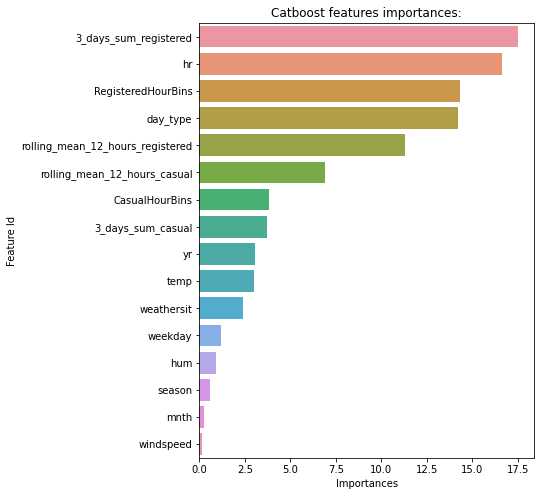

In [ ]:
# take a look at the Catboost feature importances
plot_importances('Catboost', ctb.feature_importances_)

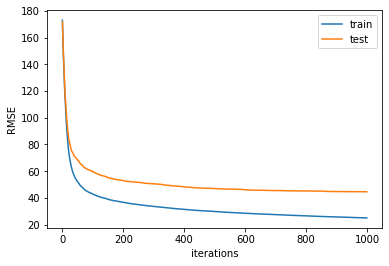

In [ ]:
# learning curve tells there is underfitting
error = ctb.evals_result_
n_iterations = ctb.tree_count_
plt.plot(error['learn']['RMSE'], label='train')
plt.plot(error['validation']['RMSE'], label='test')
plt.xlabel('iterations')
plt.ylabel('RMSE')
plt.legend();

**2. RandomForestRegressor**

In [ ]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1, min_samples_leaf=1, 
                           random_state=SEED)
rf.fit(X_train, y_train)
predictions = rf.predict(X_val)
mean_squared_error(y_val, predictions, squared=False)

56.76666873220341

In [ ]:
# max_depth parameter search

parameters = np.arange(3, 26, 1)
test_scores = []
train_scores = []
train_scores_cv = []
train_scores_cv_std = []

for param in parameters:
    rf = RandomForestRegressor(n_estimators=300, n_jobs=-1, max_depth=param, random_state=SEED)
    # train regressor
    rf.fit(X_train, y_train)
    print('max_depth = {}'.format(param))
    print('------------------------------------------------')
    # evaluate model on crossvalidation
    train_score_cv = cross_val_score(rf, X_train, y_train, n_jobs=-1, cv=ts_cv, scoring='neg_root_mean_squared_error')
    tr_preds = rf.predict(X_train)
    # evaluate model on train set to monitor overfitting point
    train_score = mean_squared_error(y_train, tr_preds, squared=False)
    val_preds = rf.predict(X_val)
    # evaluate model on test set
    val_score = mean_squared_error(y_val, val_preds, squared=False)
    print('RMSE on whole train: {:.4f}'.format(train_score))
    print('RMSE on train with crossvalidation: {:.4f} +/- {:.4f}'.format(-train_score_cv.mean(), train_score_cv.std()))
    print('RMSE on test: {:.4f}'.format(val_score))
    print('------------------------------------------------')
    train_scores_cv.append(-train_score_cv.mean())
    train_scores_cv_std.append(train_score_cv.std())
    train_scores.append(train_score)
    test_scores.append(val_score)

max_depth = 3
------------------------------------------------
RMSE on whole train: 102.8292
RMSE on train with crossvalidation: 146.4916 +/- 8.5045
RMSE on test: 114.2870
------------------------------------------------
max_depth = 4
------------------------------------------------
RMSE on whole train: 90.0692
RMSE on train with crossvalidation: 125.8702 +/- 8.6621
RMSE on test: 104.2014
------------------------------------------------
max_depth = 5
------------------------------------------------
RMSE on whole train: 78.1543
RMSE on train with crossvalidation: 110.1978 +/- 11.4968
RMSE on test: 96.3352
------------------------------------------------
max_depth = 6
------------------------------------------------
RMSE on whole train: 66.3872
RMSE on train with crossvalidation: 95.8185 +/- 12.7568
RMSE on test: 88.2021
------------------------------------------------
max_depth = 7
------------------------------------------------
RMSE on whole train: 56.6271
RMSE on train with crossvali

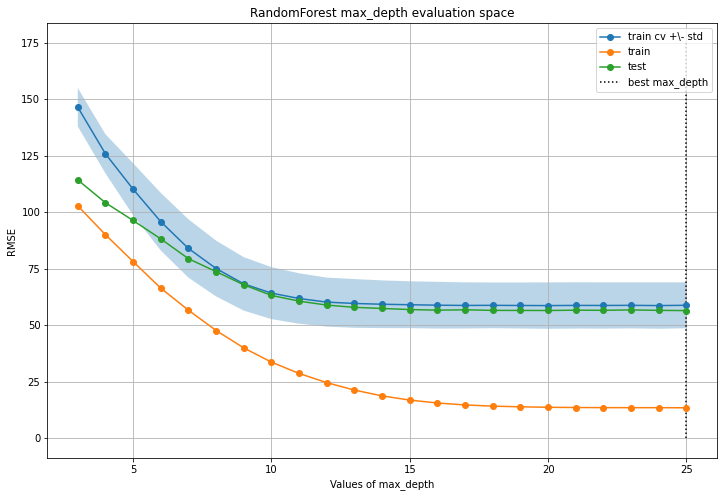

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(parameters, train_scores_cv, label='train cv +\- std', marker='o')
plt.plot(parameters, train_scores, label='train', marker='o')
plt.plot(parameters, test_scores, label='test', marker='o')
plt.fill_between(parameters, np.array( train_scores_cv) - np.array(train_scores_cv_std),
                 np.array(train_scores_cv) + np.array(train_scores_cv_std), alpha=0.3)
plt.xlabel('Values of max_depth')
plt.ylabel('RMSE')
plt.title('RandomForest max_depth evaluation space')
plt.vlines(parameters[np.argmin(test_scores)], 0, 175, linestyles='dotted', label='best max_depth')
plt.grid()
plt.legend();

In [ ]:
# train regressor with best max_depth
rf = RandomForestRegressor(n_estimators=300, max_depth=25, n_jobs=-1, min_samples_leaf=1, 
                           random_state=SEED)
rf.fit(X_train, y_train)
predictions = rf.predict(X_val)
mean_squared_error(y_val, predictions, squared=False)

56.45439507371896

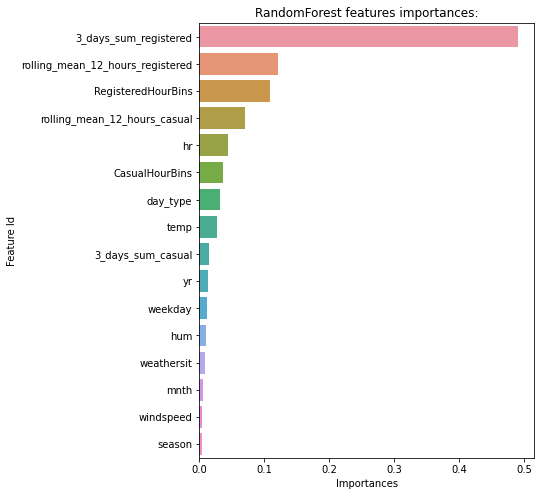

In [ ]:
plot_importances('RandomForest', rf.feature_importances_)

**3. LightGBM**

In [ ]:
# Initialize LightGBM regressor with default parameters except number of rounds
lgbm = LGBMRegressor(n_estimators=1000, 
                     n_jobs=-1, 
                     random_state=SEED, 
                     objective='regression')
# form data pools
eval_set = [(X_train, y_train), (X_val, y_val)]

# train regressor with overfitting detector
lgbm.fit(X_train, y_train, categorical_feature='auto', 
         eval_set = eval_set,
         eval_names = ['train', 'test'], 
         eval_metric='rmse', 
         early_stopping_rounds=100, verbose=50)

Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.754	train's l2: 1350.86	test's rmse: 56.4366	test's l2: 3185.09
[100]	train's rmse: 30.139	train's l2: 908.362	test's rmse: 51.3608	test's l2: 2637.93
[150]	train's rmse: 27.1674	train's l2: 738.069	test's rmse: 50.5052	test's l2: 2550.78
[200]	train's rmse: 25.0728	train's l2: 628.645	test's rmse: 49.7799	test's l2: 2478.03
[250]	train's rmse: 23.3479	train's l2: 545.123	test's rmse: 49.1788	test's l2: 2418.55
[300]	train's rmse: 21.8504	train's l2: 477.441	test's rmse: 49.0564	test's l2: 2406.53
[350]	train's rmse: 20.728	train's l2: 429.65	test's rmse: 49.2245	test's l2: 2423.05
[400]	train's rmse: 19.7459	train's l2: 389.899	test's rmse: 49.3067	test's l2: 2431.15
Early stopping, best iteration is:
[318]	train's rmse: 21.4232	train's l2: 458.955	test's rmse: 48.9775	test's l2: 2398.79


LGBMRegressor(n_estimators=1000, objective='regression', random_state=100)

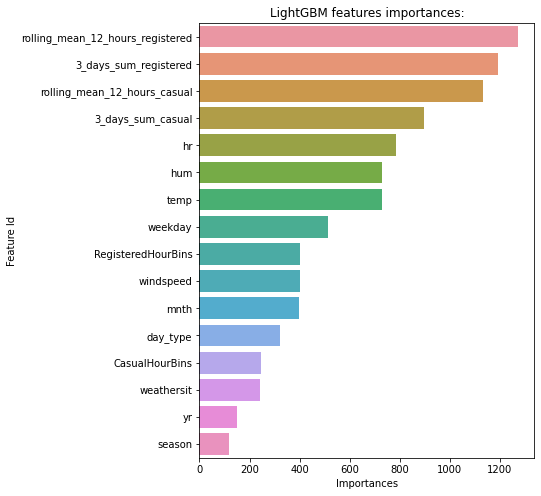

In [ ]:
# Take a look on feature importances
plot_importances('LightGBM', lgbm.feature_importances_)

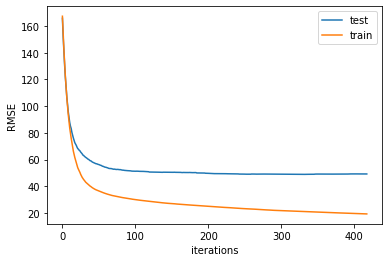

In [ ]:
# learning curves. There is underfitting
error = lgbm.evals_result_
plt.plot(error['test']['rmse'], label='test')
plt.plot(error['train']['rmse'], label='train')
plt.xlabel('iterations')
plt.ylabel('RMSE')
plt.legend();

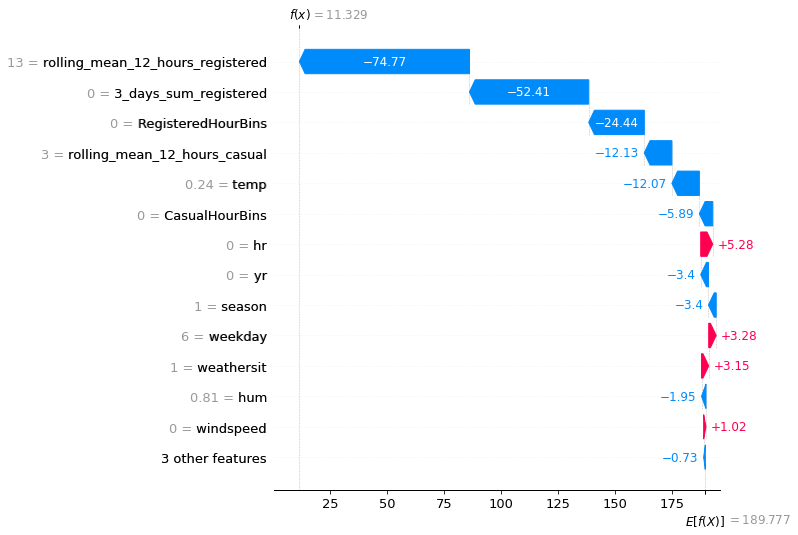

In [ ]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(lgbm)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0], max_display=14)

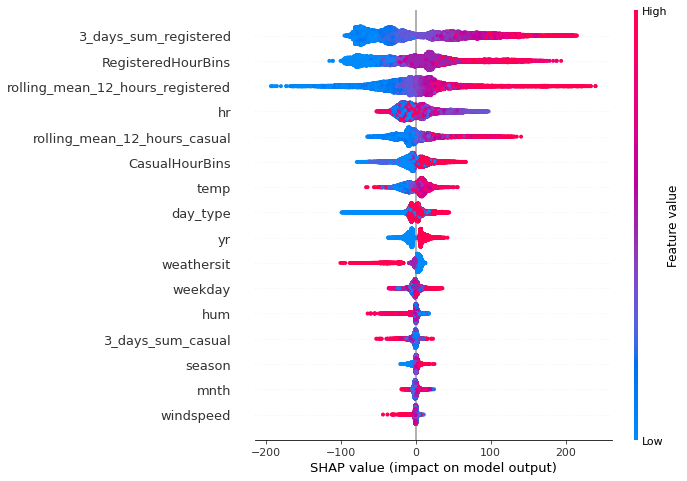

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

**4. HistGradientBoosting**

In [ ]:
# Pool of categorical features for HistGradientBoostingRegressor
cat =["weathersit",
 "season",
 "yr",
 'weekday',
 'day_type',
 'RegisteredHourBins',
 'CasualHourBins'
]
indx = [features.index(i) for i in features if i in cat]

In [ ]:
model = HistGradientBoostingRegressor(verbose=0, categorical_features=indx,
                                      random_state=SEED, 
                                      scoring='loss')
model.fit(X_train, y_train)
preds = model.predict(X_val)
mean_squared_error(y_val, np.around(preds, 0), squared=False)

54.802160411011954

In [ ]:
np.any(preds <0)

False

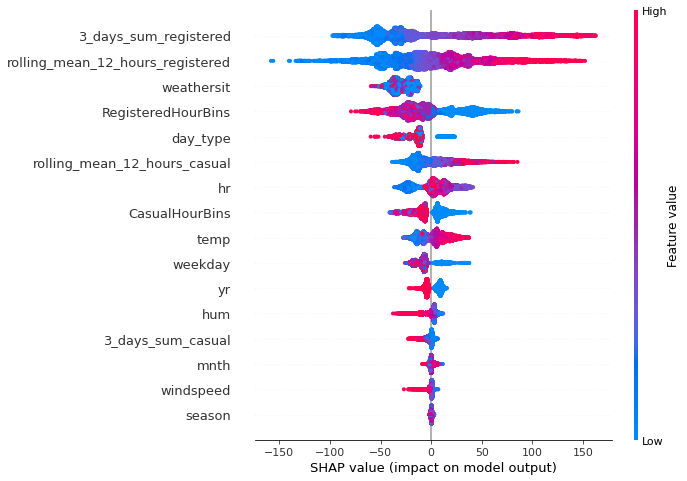

In [ ]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

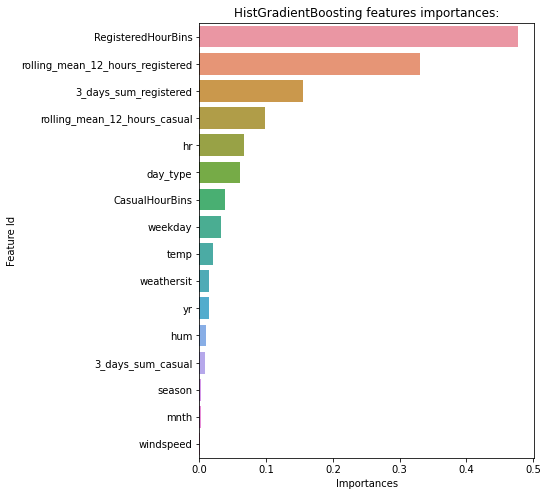

In [ ]:
# Take a look at feature importances usin permutations
result = permutation_importance(model, X_train, y_train, n_repeats=10,
                                random_state=SEED, n_jobs=2)

feat_imp = pd.DataFrame(zip(features, result['importances_mean']), 
             columns=['Feature Id', 
                      'Importances']).sort_values(by='Importances', 
                                      ascending=False).reset_index(drop=True)
plt.figure(figsize=(6, 8)); 
sns.barplot(x="Importances", y="Feature Id", data=feat_imp)
plt.title('HistGradientBoosting features importances:');

**5. XGBoost**

In [ ]:
# Initialize XGBoost regressor with default parameters except number of rounds
xgb = XGBRegressor(
    n_estimators=3000, 
    objective='reg:squarederror', 
    verbosity=1, n_jobs=-1, 
    random_state=SEED)

# form data pools
eval_set = [(X_train, y_train), (X_val, y_val)]

# train regressor with overfitting detector
xgb.fit(X_train, y_train, eval_metric=["rmse"], eval_set=eval_set, 
              early_stopping_rounds=100, verbose=100)

print(f'Best score {xgb.best_score} on {xgb.best_iteration} iteration')

[0]	validation_0-rmse:241.117	validation_1-rmse:254.568
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:53.1342	validation_1-rmse:74.6179
[200]	validation_0-rmse:44.0753	validation_1-rmse:65.9865
[300]	validation_0-rmse:39.6727	validation_1-rmse:60.4114
[400]	validation_0-rmse:37.0667	validation_1-rmse:57.9004
[500]	validation_0-rmse:35.309	validation_1-rmse:56.8913
[600]	validation_0-rmse:33.7622	validation_1-rmse:56.0066
[700]	validation_0-rmse:32.6885	validation_1-rmse:55.1934
[800]	validation_0-rmse:31.6243	validation_1-rmse:54.6298
[900]	validation_0-rmse:30.759	validation_1-rmse:53.9793
[1000]	validation_0-rmse:30.0167	validation_1-rmse:53.8512
[1100]	validation_0-rmse:29.3327	validation_1-rmse:53.5705
[1200]	validation_0-rmse:28.6705	validation_1-rmse:53.5175
[1300]	validation_0-rmse:28.0013	validation_1-rmse:53.1911
[1400]	validation_0-rmse:27.

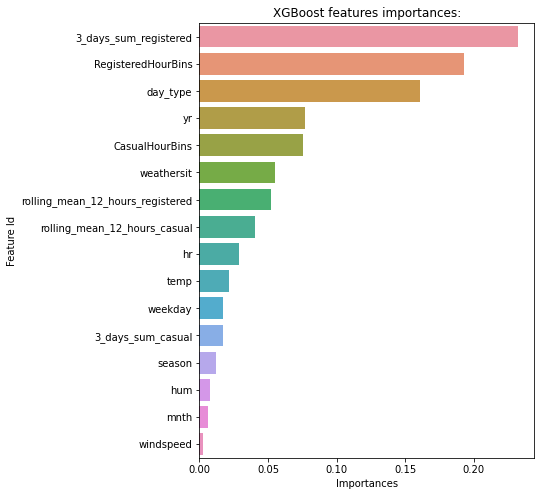

In [ ]:
plot_importances('XGBoost', xgb.feature_importances_)

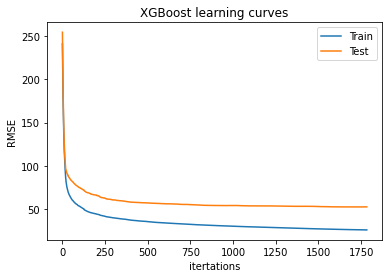

In [ ]:
# learning curves
results = xgb.evals_result()
plt.plot(results['validation_0']['rmse'], label='Train')
plt.plot(results['validation_1']['rmse'], label='Test')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('itertations')
plt.title('XGBoost learning curves');

### Baseline on crossvalidation

Using `X_train_full`, `y_train_full` for crossvalidation

In [ ]:
# function for express evaluation with no overfitting detection
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    fit_time = cv_results['fit_time']
    score_time = cv_results['score_time']
    print(
        f"Fit time:     {fit_time.mean():>16.3f} +/- {fit_time.std():.3f}\n"
        f"Score time:     {score_time.mean():>14.3f} +/- {score_time.std():.4f}\n"
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

Let's turn on Catboost parameter `has_time` to use the order of objects in the input time series data (*do not perform random permutations during the transforming categorical features to numerical features and choosing the tree structure stages*).

In [ ]:
ctb = CatBoostRegressor(loss_function='RMSE', random_state=SEED, silent=True, cat_features=cat_cols, has_time=True)
hgb = HistGradientBoostingRegressor(random_state=SEED, early_stopping=True, categorical_features=indx)
xgb = XGBRegressor(n_estimators=1000, objective='reg:squarederror', n_jobs=-1, random_state=SEED)
lgbm = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=SEED, objective='regression')
rf = RandomForestRegressor(n_estimators=300, max_depth=20, n_jobs=-1, min_samples_leaf=1, 
                           random_state=SEED)

models = {'Catboost': ctb, 'HistGradientBossting': hgb, 
          'XGBoost': xgb, 'RandomForest': rf, 'LightGBM': lgbm}

for name, model in models.items():
    print(name)
    print('-'*30)
    evaluate(model, X_train_full, y_train_full, cv=ts_cv)
    model.fit(X_train_full, y_train_full)
    predictions = model.predict(X_test)
    test_rmse = mean_squared_error(y_test, np.around(predictions.clip(0), 0), squared=False)
    print(f'RMSE on test: {test_rmse:>16.3f}')
    print()

Catboost
------------------------------
Fit time:               19.576 +/- 0.918
Score time:              0.009 +/- 0.0003
Mean Absolute Error:     33.718 +/- 2.184
Root Mean Squared Error: 51.189 +/- 2.254
RMSE on test:           38.376

HistGradientBossting
------------------------------
Fit time:                0.697 +/- 0.016
Score time:              0.011 +/- 0.0001
Mean Absolute Error:     37.517 +/- 5.222
Root Mean Squared Error: 56.037 +/- 6.558
RMSE on test:           37.865

XGBoost
------------------------------
Fit time:                8.635 +/- 0.525
Score time:              0.024 +/- 0.0010
Mean Absolute Error:     38.016 +/- 3.675
Root Mean Squared Error: 55.004 +/- 4.712
RMSE on test:           44.166

RandomForest
------------------------------
Fit time:               21.951 +/- 1.479
Score time:              0.125 +/- 0.0403
Mean Absolute Error:     38.094 +/- 6.221
Root Mean Squared Error: 59.850 +/- 9.858
RMSE on test:           47.741

LightGBM
--------------------

Now check models performance with overfitting detection (possible only for Catboost, XGBoost, LightGBM)

**1. Catboost**

In [ ]:
# crossvalidation with overfitting detection
rmse = list()

for train_indx, test_indx in ts_cv.split(X_train_full):
    X_train = X_train_full.iloc[train_indx, :]
    X_valid = X_train_full.iloc[test_indx, :]

    y_train = y_train_full.iloc[train_indx]
    y_valid = y_train_full.iloc[test_indx]

    train_pool = Pool(X_train, y_train, cat_features=cat_cols)
    test_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

    ctb = CatBoostRegressor(loss_function='RMSE',
                        eval_metric='RMSE',
                        random_state=SEED,
                        early_stopping_rounds=100,
                        verbose=50)

    ctb.fit(train_pool, eval_set=test_pool, 
            use_best_model=True, plot=False)
    
    preds = ctb.predict(X_valid)
    rmse.append(mean_squared_error(y_valid, np.around(preds.clip(0), 0), squared=False))

print(f"Root Mean Squared Error: {np.mean(rmse):.3f} +/- {np.std(rmse):.3f}")

Learning rate set to 0.076443
0:	learn: 153.8371925	test: 237.9185346	best: 237.9185346 (0)	total: 27ms	remaining: 27s
50:	learn: 47.8560465	test: 70.5061855	best: 70.5061855 (50)	total: 1.06s	remaining: 19.8s
100:	learn: 39.3107227	test: 58.1604660	best: 58.1604660 (100)	total: 2.07s	remaining: 18.4s
150:	learn: 35.6582653	test: 53.5697201	best: 53.5697201 (150)	total: 3.11s	remaining: 17.5s
200:	learn: 33.5180125	test: 51.2270338	best: 51.2270338 (200)	total: 4.1s	remaining: 16.3s
250:	learn: 32.1398015	test: 50.2000364	best: 50.2000364 (250)	total: 5.07s	remaining: 15.1s
300:	learn: 30.8477086	test: 49.5269764	best: 49.5269764 (300)	total: 6.07s	remaining: 14.1s
350:	learn: 29.7012943	test: 48.3448917	best: 48.3448917 (350)	total: 7.09s	remaining: 13.1s
400:	learn: 28.7042423	test: 47.8106067	best: 47.7991860 (397)	total: 8.09s	remaining: 12.1s
450:	learn: 27.9118143	test: 47.8887302	best: 47.5492113 (426)	total: 9.12s	remaining: 11.1s
500:	learn: 27.1770906	test: 47.8149586	best: 4

**2. XGBoost**

In [ ]:
rmse = list()

for train_indx, test_indx in ts_cv.split(X_train_full):
    X_train = X_train_full.iloc[train_indx, :]
    X_valid = X_train_full.iloc[test_indx, :]

    y_train = y_train_full.iloc[train_indx]
    y_valid = y_train_full.iloc[test_indx]

    eval_set = [(X_train, y_train), (X_valid, y_valid)]

    model = XGBRegressor(
        n_estimators=3000, 
        objective='reg:squarederror',
                         verbosity=1, n_jobs=-1)

    model.fit(X_train, y_train, eval_metric=["rmse"], eval_set=eval_set, 
              early_stopping_rounds=100, verbose=100)
    
    preds = model.predict(X_valid)
    rmse.append(mean_squared_error(y_valid, np.around(preds.clip(0), 0), squared=False))

print(f"Root Mean Squared Error: {np.mean(rmse):.3f} +/- {np.std(rmse):.3f}")

[0]	validation_0-rmse:215.397	validation_1-rmse:332.062
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:46.503	validation_1-rmse:70.8546
[200]	validation_0-rmse:39.9759	validation_1-rmse:60.8871
[300]	validation_0-rmse:36.198	validation_1-rmse:56.0107
[400]	validation_0-rmse:33.4831	validation_1-rmse:53.2111
[500]	validation_0-rmse:31.8424	validation_1-rmse:52.1789
[600]	validation_0-rmse:30.5619	validation_1-rmse:50.9808
[700]	validation_0-rmse:29.4339	validation_1-rmse:50.3696
[800]	validation_0-rmse:28.3623	validation_1-rmse:49.7535
[900]	validation_0-rmse:27.462	validation_1-rmse:49.3802
[1000]	validation_0-rmse:26.8361	validation_1-rmse:49.244
[1100]	validation_0-rmse:26.1809	validation_1-rmse:49.2012
[1200]	validation_0-rmse:25.5235	validation_1-rmse:49.19
[1300]	validation_0-rmse:24.9777	validation_1-rmse:49.0791
[1400]	validation_0-rmse:24.5024

**3. LightGBM**

In [ ]:
rmse = list()

for train_indx, test_indx in ts_cv.split(X_train_full):
    X_train = X_train_full.iloc[train_indx, :]
    X_valid = X_train_full.iloc[test_indx, :]

    y_train = y_train_full.iloc[train_indx]
    y_valid = y_train_full.iloc[test_indx]

    eval_set = [(X_train, y_train), (X_valid, y_valid)]

    model = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=SEED, objective='regression')
   
    model.fit(X_train, y_train, eval_metric=["rmse"], eval_set=eval_set, 
              eval_names=['train', 'valid'],
              early_stopping_rounds=100, verbose=50)
    
    preds = model.predict(X_valid)
    rmse.append(mean_squared_error(y_valid, np.around(preds.clip(0), 0), squared=False))

print(f"Root Mean Squared Error: {np.mean(rmse):.3f} +/- {np.std(rmse):.3f}")

Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 32.7005	train's l2: 1069.32	valid's rmse: 51.1442	valid's l2: 2615.73
[100]	train's rmse: 26.8446	train's l2: 720.635	valid's rmse: 46.7102	valid's l2: 2181.85
[150]	train's rmse: 23.9611	train's l2: 574.133	valid's rmse: 45.7074	valid's l2: 2089.16
[200]	train's rmse: 22.0745	train's l2: 487.284	valid's rmse: 45.5357	valid's l2: 2073.5
[250]	train's rmse: 20.4898	train's l2: 419.83	valid's rmse: 45.3139	valid's l2: 2053.35
[300]	train's rmse: 19.0771	train's l2: 363.937	valid's rmse: 45.1181	valid's l2: 2035.65
[350]	train's rmse: 17.9059	train's l2: 320.621	valid's rmse: 44.9171	valid's l2: 2017.55
[400]	train's rmse: 16.9731	train's l2: 288.086	valid's rmse: 45.215	valid's l2: 2044.4
[450]	train's rmse: 16.1396	train's l2: 260.488	valid's rmse: 45.2741	valid's l2: 2049.75
Early stopping, best iteration is:
[352]	train's rmse: 17.8762	train's l2: 319.557	valid's rmse: 44.896	valid's l2: 2015.65
Training

## Conclusions
Generated features proved to be usefull according to feature inmportance values of reviewed models.

The results for the best model search are tabulated below:
 
 | Model   |  single split score  | cv score | cv score with overfitting detection| cv std |fit time|
 | :---    | ---   | ---     | ---  | --- | --- |
 |Catboost| 44.58 | 51.19  | 49.12  | 2.725 |19.576 |
 | XGBoost|  52.29 | 55.00  | 53.068  | 3.987 | 8.635  |
 | LightGBM| 48.98 | 52.26 | 52.17   | 5.876|  1.77 |
 | HistGradientBoosting| 54.80 | 56.04 | 56.04 | 6.558 | 0.697  |
 | RandomForest| 56.45 | 59.85 | n/a | 9.858  | 21.951  |

 Most optimal model by RMSE score evaluations and time consumption is LightGBM.

# Single model tuning

In [ ]:
dtrain = lgb.Dataset(X_train_full, label=y_train_full)
dvalid = lgb.Dataset(X_test, label=y_test)

param = {'objective': 'regression',
         'metric': 'rmse',
         'eval_metric': 'rmse',
         "boosting_type": "gbdt",
         'verbosity': -1}

tuner = lgb.LightGBMTuner(
     param, dtrain, valid_sets=[dtrain, dvalid], valid_names=['train', 'valid'], 
     verbose_eval=50, early_stopping_rounds=100, optuna_seed=SEED,
     model_dir= '/content/directory_to_save_boosters', time_budget=2000, show_progress_bar=False)

tuner.run()

[I 2021-10-29 22:43:31,958] A new study created in memory with name: no-name-614d5230-703d-4aeb-a2a7-a417b1b36c7d


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 38.0538	valid's rmse: 45.142
[100]	train's rmse: 30.7926	valid's rmse: 41.2938
[150]	train's rmse: 27.7516	valid's rmse: 40.8818
[200]	train's rmse: 25.6319	valid's rmse: 40.0999
[250]	train's rmse: 24.0852	valid's rmse: 39.6661
[300]	train's rmse: 22.7761	valid's rmse: 39.1827
[350]	train's rmse: 21.7152	valid's rmse: 38.9424
[400]	train's rmse: 20.7049	valid's rmse: 38.4416
[450]	train's rmse: 19.8013	valid's rmse: 38.4057
[500]	train's rmse: 18.9927	valid's rmse: 38.2566
[550]	train's rmse: 18.2597	valid's rmse: 38.1136
[600]	train's rmse: 17.6107	valid's rmse: 37.9507
[650]	train's rmse: 16.9507	valid's rmse: 38.0152
Early stopping, best iteration is:
[597]	train's rmse: 17.6569	valid's rmse: 37.9282


[I 2021-10-29 22:43:33,635] The booster of trial#0 was saved as /content/directory_to_save_boosters/0.pkl.
[I 2021-10-29 22:43:33,641] Trial 0 finished with value: 37.92815314520146 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 37.92815314520146.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 38.8917	valid's rmse: 47.3332
[100]	train's rmse: 31.2071	valid's rmse: 42.0034
[150]	train's rmse: 28.0269	valid's rmse: 40.0541
[200]	train's rmse: 25.8301	valid's rmse: 39.4266
[250]	train's rmse: 24.1733	valid's rmse: 39.1635
[300]	train's rmse: 22.9001	valid's rmse: 38.5217
[350]	train's rmse: 21.7631	valid's rmse: 38.4398
[400]	train's rmse: 20.8117	valid's rmse: 38.1542
[450]	train's rmse: 19.9669	valid's rmse: 38.1278


[I 2021-10-29 22:43:34,680] The booster of trial#1 was saved as /content/directory_to_save_boosters/1.pkl.
[I 2021-10-29 22:43:34,684] Trial 1 finished with value: 38.08455503146616 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 37.92815314520146.


Early stopping, best iteration is:
[375]	train's rmse: 21.2753	valid's rmse: 38.0846
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 39.9054	valid's rmse: 46.4876
[100]	train's rmse: 33.2907	valid's rmse: 42.1429
[150]	train's rmse: 30.3352	valid's rmse: 41.37
[200]	train's rmse: 28.2	valid's rmse: 40.3635
[250]	train's rmse: 26.6	valid's rmse: 39.6102
[300]	train's rmse: 25.3099	valid's rmse: 39.5504
[350]	train's rmse: 24.237	valid's rmse: 39.276
[400]	train's rmse: 23.3331	valid's rmse: 39.2794
[450]	train's rmse: 22.5491	valid's rmse: 39.3691


[I 2021-10-29 22:43:35,652] The booster of trial#2 was saved as /content/directory_to_save_boosters/2.pkl.
[I 2021-10-29 22:43:35,655] Trial 2 finished with value: 39.217355771411306 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 37.92815314520146.


Early stopping, best iteration is:
[380]	train's rmse: 23.6826	valid's rmse: 39.2174
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.6882	valid's rmse: 42.6802
[100]	train's rmse: 30.1384	valid's rmse: 39.9778
[150]	train's rmse: 27.187	valid's rmse: 39.2062
[200]	train's rmse: 25.0388	valid's rmse: 38.5036
[250]	train's rmse: 23.5941	valid's rmse: 37.9524
[300]	train's rmse: 22.3303	valid's rmse: 37.5992
[350]	train's rmse: 21.1365	valid's rmse: 37.4557
[400]	train's rmse: 20.0759	valid's rmse: 37.3424
[450]	train's rmse: 19.1652	valid's rmse: 37.1641
[500]	train's rmse: 18.3542	valid's rmse: 37.0221
[550]	train's rmse: 17.5608	valid's rmse: 36.8811
[600]	train's rmse: 16.9045	valid's rmse: 36.993
[650]	train's rmse: 16.2894	valid's rmse: 36.9441
Early stopping, best iteration is:
[551]	train's rmse: 17.5479	valid's rmse: 36.8811


[I 2021-10-29 22:43:37,273] The booster of trial#3 was saved as /content/directory_to_save_boosters/3.pkl.
[I 2021-10-29 22:43:37,277] Trial 3 finished with value: 36.88109428691645 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 36.88109428691645.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.1346	valid's rmse: 38.7991
[100]	train's rmse: 30.5327	valid's rmse: 35.837
[150]	train's rmse: 27.3902	valid's rmse: 35.2468
[200]	train's rmse: 25.1738	valid's rmse: 34.8928
[250]	train's rmse: 23.4868	valid's rmse: 34.9087
[300]	train's rmse: 22.1511	valid's rmse: 34.8276
[350]	train's rmse: 20.9814	valid's rmse: 34.7252
[400]	train's rmse: 19.9908	valid's rmse: 34.5478
[450]	train's rmse: 19.0445	valid's rmse: 34.7164


[I 2021-10-29 22:43:38,628] The booster of trial#4 was saved as /content/directory_to_save_boosters/4.pkl.
[I 2021-10-29 22:43:38,631] Trial 4 finished with value: 34.512132750959026 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 4 with value: 34.512132750959026.


[500]	train's rmse: 18.2575	valid's rmse: 34.7377
Early stopping, best iteration is:
[407]	train's rmse: 19.844	valid's rmse: 34.5121
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.0766	valid's rmse: 40.7289
[100]	train's rmse: 30.2069	valid's rmse: 36.6887
[150]	train's rmse: 27.1077	valid's rmse: 35.717
[200]	train's rmse: 25.1577	valid's rmse: 35.1305
[250]	train's rmse: 23.5515	valid's rmse: 34.7156
[300]	train's rmse: 22.1242	valid's rmse: 34.4432
[350]	train's rmse: 21.0186	valid's rmse: 34.2573
[400]	train's rmse: 19.9145	valid's rmse: 34.2032
[450]	train's rmse: 18.9456	valid's rmse: 34.2211
[500]	train's rmse: 18.0311	valid's rmse: 34.1675
[550]	train's rmse: 17.2925	valid's rmse: 34.2108
Early stopping, best iteration is:
[495]	train's rmse: 18.1165	valid's rmse: 34.1315


[I 2021-10-29 22:43:40,154] The booster of trial#5 was saved as /content/directory_to_save_boosters/5.pkl.
[I 2021-10-29 22:43:40,158] Trial 5 finished with value: 34.13154610161958 and parameters: {'feature_fraction': 0.8}. Best is trial 5 with value: 34.13154610161958.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.8029	valid's rmse: 41.0376
[100]	train's rmse: 30.3968	valid's rmse: 37.7546
[150]	train's rmse: 27.3372	valid's rmse: 37.2925
[200]	train's rmse: 25.3565	valid's rmse: 37.0261
[250]	train's rmse: 23.7737	valid's rmse: 36.6329
[300]	train's rmse: 22.2808	valid's rmse: 36.2415
[350]	train's rmse: 20.9669	valid's rmse: 35.9715
[400]	train's rmse: 19.8967	valid's rmse: 35.9965
[450]	train's rmse: 18.8409	valid's rmse: 36.1147
Early stopping, best iteration is:
[390]	train's rmse: 20.1497	valid's rmse: 35.9349


[I 2021-10-29 22:43:41,507] The booster of trial#6 was saved as /content/directory_to_save_boosters/6.pkl.
[I 2021-10-29 22:43:41,512] Trial 6 finished with value: 35.934930279994674 and parameters: {'feature_fraction': 1.0}. Best is trial 5 with value: 34.13154610161958.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 24.5821	valid's rmse: 37.7855
[100]	train's rmse: 18.1778	valid's rmse: 36.5133
[150]	train's rmse: 14.9156	valid's rmse: 36.6224
[200]	train's rmse: 12.6116	valid's rmse: 36.4839
[250]	train's rmse: 10.8663	valid's rmse: 36.7648
Early stopping, best iteration is:
[192]	train's rmse: 12.8985	valid's rmse: 36.4209


[I 2021-10-29 22:43:43,440] The booster of trial#7 was saved as /content/directory_to_save_boosters/7.pkl.
[I 2021-10-29 22:43:43,443] Trial 7 finished with value: 36.42087983483754 and parameters: {'num_leaves': 140}. Best is trial 7 with value: 36.42087983483754.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 29.4791	valid's rmse: 39.0437
[100]	train's rmse: 23.5596	valid's rmse: 37.7745
[150]	train's rmse: 20.572	valid's rmse: 37.1588
[200]	train's rmse: 18.274	valid's rmse: 37.0089
[250]	train's rmse: 16.38	valid's rmse: 36.6714
[300]	train's rmse: 15.0138	valid's rmse: 36.772
[350]	train's rmse: 13.7158	valid's rmse: 36.6842
[400]	train's rmse: 12.6514	valid's rmse: 36.5982
[450]	train's rmse: 11.7176	valid's rmse: 36.6314
Early stopping, best iteration is:
[395]	train's rmse: 12.7401	valid's rmse: 36.573


[I 2021-10-29 22:43:45,502] The booster of trial#8 was saved as /content/directory_to_save_boosters/8.pkl.
[I 2021-10-29 22:43:45,506] Trial 8 finished with value: 36.57295443437287 and parameters: {'num_leaves': 72}. Best is trial 7 with value: 36.42087983483754.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 26.2017	valid's rmse: 37.0246
[100]	train's rmse: 20.0826	valid's rmse: 36.2507
[150]	train's rmse: 16.8323	valid's rmse: 36.0211
[200]	train's rmse: 14.572	valid's rmse: 36.1608
Early stopping, best iteration is:
[134]	train's rmse: 17.7659	valid's rmse: 35.9376


[I 2021-10-29 22:43:46,797] The booster of trial#9 was saved as /content/directory_to_save_boosters/9.pkl.
[I 2021-10-29 22:43:46,801] Trial 9 finished with value: 35.937642101450315 and parameters: {'num_leaves': 110}. Best is trial 9 with value: 35.937642101450315.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 21.657	valid's rmse: 38.2779
[100]	train's rmse: 14.8801	valid's rmse: 37.3412
[150]	train's rmse: 11.4824	valid's rmse: 37.2995
[200]	train's rmse: 9.19298	valid's rmse: 37.4263
Early stopping, best iteration is:
[104]	train's rmse: 14.5674	valid's rmse: 37.2365


[I 2021-10-29 22:43:48,667] The booster of trial#10 was saved as /content/directory_to_save_boosters/10.pkl.
[I 2021-10-29 22:43:48,670] Trial 10 finished with value: 37.23648223312031 and parameters: {'num_leaves': 217}. Best is trial 9 with value: 35.937642101450315.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 83.0971	valid's rmse: 80.5503
[100]	train's rmse: 75.8904	valid's rmse: 74.0713
[150]	train's rmse: 68.2902	valid's rmse: 66.5163
[200]	train's rmse: 61.7791	valid's rmse: 61.6312
[250]	train's rmse: 59.3128	valid's rmse: 58.9996
[300]	train's rmse: 57.6438	valid's rmse: 57.1814
[350]	train's rmse: 56.1153	valid's rmse: 56.1656
[400]	train's rmse: 54.8132	valid's rmse: 55.3626
[450]	train's rmse: 53.7171	valid's rmse: 54.7889
[500]	train's rmse: 52.7877	valid's rmse: 54.3656
[550]	train's rmse: 51.9769	valid's rmse: 53.9691
[600]	train's rmse: 51.2176	valid's rmse: 53.6869
[650]	train's rmse: 50.3885	valid's rmse: 53.3365
[700]	train's rmse: 49.7994	valid's rmse: 53.1554
[750]	train's rmse: 49.2675	valid's rmse: 52.9424
[800]	train's rmse: 48.7549	valid's rmse: 52.6054
[850]	train's rmse: 48.0157	valid's rmse: 52.3606
[900]	train's rmse: 47.5151	valid's rmse: 52.3145
[950]	train's rmse: 47.1095	valid's rm

[I 2021-10-29 22:43:49,709] The booster of trial#11 was saved as /content/directory_to_save_boosters/11.pkl.
[I 2021-10-29 22:43:49,714] Trial 11 finished with value: 52.02923293806995 and parameters: {'num_leaves': 3}. Best is trial 9 with value: 35.937642101450315.


[1000]	train's rmse: 46.7053	valid's rmse: 52.0292
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 46.7053	valid's rmse: 52.0292
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.3007	valid's rmse: 39.756
[100]	train's rmse: 29.7785	valid's rmse: 37.0018
[150]	train's rmse: 26.8108	valid's rmse: 36.004
[200]	train's rmse: 24.7517	valid's rmse: 35.6287
[250]	train's rmse: 23.0078	valid's rmse: 35.1868
[300]	train's rmse: 21.5539	valid's rmse: 35.0571
[350]	train's rmse: 20.3443	valid's rmse: 34.9599
[400]	train's rmse: 19.3043	valid's rmse: 34.8738
[450]	train's rmse: 18.4174	valid's rmse: 34.8177
[500]	train's rmse: 17.5833	valid's rmse: 35.0526
[550]	train's rmse: 16.8135	valid's rmse: 35.0772
Early stopping, best iteration is:
[451]	train's rmse: 18.3998	valid's rmse: 34.8152


[I 2021-10-29 22:43:51,211] The booster of trial#12 was saved as /content/directory_to_save_boosters/12.pkl.
[I 2021-10-29 22:43:51,215] Trial 12 finished with value: 34.81521711307348 and parameters: {'num_leaves': 33}. Best is trial 12 with value: 34.81521711307348.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 23.1186	valid's rmse: 39.2391
[100]	train's rmse: 16.5501	valid's rmse: 38.4672
[150]	train's rmse: 13.2043	valid's rmse: 38.1326
[200]	train's rmse: 10.8652	valid's rmse: 38.0872
[250]	train's rmse: 9.18463	valid's rmse: 38.1365
Early stopping, best iteration is:
[176]	train's rmse: 11.9004	valid's rmse: 38.0143


[I 2021-10-29 22:43:53,362] The booster of trial#13 was saved as /content/directory_to_save_boosters/13.pkl.
[I 2021-10-29 22:43:53,365] Trial 13 finished with value: 38.014301763313775 and parameters: {'num_leaves': 173}. Best is trial 12 with value: 34.81521711307348.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 21.7644	valid's rmse: 38.0025
[100]	train's rmse: 14.9872	valid's rmse: 37.1481
[150]	train's rmse: 11.5374	valid's rmse: 36.9663
[200]	train's rmse: 9.29089	valid's rmse: 37.0314
[250]	train's rmse: 7.57112	valid's rmse: 37.0153
Early stopping, best iteration is:
[157]	train's rmse: 11.1488	valid's rmse: 36.9143


[I 2021-10-29 22:43:55,694] The booster of trial#14 was saved as /content/directory_to_save_boosters/14.pkl.
[I 2021-10-29 22:43:55,698] Trial 14 finished with value: 36.91434683853291 and parameters: {'num_leaves': 212}. Best is trial 12 with value: 34.81521711307348.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 35.4309	valid's rmse: 40.4351
[100]	train's rmse: 29.0725	valid's rmse: 37.8834
[150]	train's rmse: 26.1699	valid's rmse: 37.0171
[200]	train's rmse: 24.0061	valid's rmse: 36.2904
[250]	train's rmse: 22.2616	valid's rmse: 36.1836
[300]	train's rmse: 20.8623	valid's rmse: 36.0205
[350]	train's rmse: 19.7186	valid's rmse: 35.9981
[400]	train's rmse: 18.7005	valid's rmse: 36.0752


[I 2021-10-29 22:43:56,876] The booster of trial#15 was saved as /content/directory_to_save_boosters/15.pkl.
[I 2021-10-29 22:43:56,880] Trial 15 finished with value: 35.9100697178791 and parameters: {'num_leaves': 36}. Best is trial 12 with value: 34.81521711307348.


Early stopping, best iteration is:
[335]	train's rmse: 20.0485	valid's rmse: 35.9101
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 24.3263	valid's rmse: 37.8303
[100]	train's rmse: 17.8241	valid's rmse: 36.8888
[150]	train's rmse: 14.471	valid's rmse: 36.7015
[200]	train's rmse: 12.2073	valid's rmse: 36.8733
[250]	train's rmse: 10.4075	valid's rmse: 37.0439
Early stopping, best iteration is:
[152]	train's rmse: 14.3577	valid's rmse: 36.6999


[I 2021-10-29 22:43:58,633] The booster of trial#16 was saved as /content/directory_to_save_boosters/16.pkl.
[I 2021-10-29 22:43:58,638] Trial 16 finished with value: 36.699879482033296 and parameters: {'num_leaves': 148}. Best is trial 12 with value: 34.81521711307348.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 29.9952	valid's rmse: 37.0176
[100]	train's rmse: 24.0803	valid's rmse: 35.4206
[150]	train's rmse: 20.9453	valid's rmse: 34.7802
[200]	train's rmse: 18.7596	valid's rmse: 34.3703
[250]	train's rmse: 17.043	valid's rmse: 34.2888
[300]	train's rmse: 15.5672	valid's rmse: 34.1687
[350]	train's rmse: 14.3247	valid's rmse: 34.3573
Early stopping, best iteration is:
[293]	train's rmse: 15.7409	valid's rmse: 34.1413


[I 2021-10-29 22:44:00,227] The booster of trial#17 was saved as /content/directory_to_save_boosters/17.pkl.
[I 2021-10-29 22:44:00,232] Trial 17 finished with value: 34.14127537099726 and parameters: {'num_leaves': 68}. Best is trial 17 with value: 34.14127537099726.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 29.0824	valid's rmse: 37.7591
[100]	train's rmse: 23.19	valid's rmse: 36.6352
[150]	train's rmse: 20.1808	valid's rmse: 36.174
[200]	train's rmse: 17.8962	valid's rmse: 36.0937
[250]	train's rmse: 16.1442	valid's rmse: 35.933
[300]	train's rmse: 14.7271	valid's rmse: 35.8477
[350]	train's rmse: 13.4922	valid's rmse: 35.8555
Early stopping, best iteration is:
[293]	train's rmse: 14.9015	valid's rmse: 35.8015


[I 2021-10-29 22:44:01,984] The booster of trial#18 was saved as /content/directory_to_save_boosters/18.pkl.
[I 2021-10-29 22:44:01,990] Trial 18 finished with value: 35.801484059835076 and parameters: {'num_leaves': 75}. Best is trial 17 with value: 34.14127537099726.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 32.9356	valid's rmse: 37.8487
[100]	train's rmse: 26.7116	valid's rmse: 35.7953
[150]	train's rmse: 23.7409	valid's rmse: 35.3323
[200]	train's rmse: 21.517	valid's rmse: 35.2144
[250]	train's rmse: 19.8646	valid's rmse: 35.0661
[300]	train's rmse: 18.4465	valid's rmse: 35.1866
[350]	train's rmse: 17.1921	valid's rmse: 35.1371
Early stopping, best iteration is:
[254]	train's rmse: 19.7366	valid's rmse: 35.0392


[I 2021-10-29 22:44:03,124] The booster of trial#19 was saved as /content/directory_to_save_boosters/19.pkl.
[I 2021-10-29 22:44:03,131] Trial 19 finished with value: 35.03915288280156 and parameters: {'num_leaves': 48}. Best is trial 17 with value: 34.14127537099726.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 43.2033	valid's rmse: 43.4577
[100]	train's rmse: 35.0238	valid's rmse: 39.1715
[150]	train's rmse: 31.8422	valid's rmse: 38.0817
[200]	train's rmse: 29.7667	valid's rmse: 37.628
[250]	train's rmse: 28.1135	valid's rmse: 36.9849
[300]	train's rmse: 26.8721	valid's rmse: 36.6067
[350]	train's rmse: 25.8284	valid's rmse: 36.3426
[400]	train's rmse: 24.8445	valid's rmse: 36.1176
[450]	train's rmse: 23.9783	valid's rmse: 35.8506
[500]	train's rmse: 23.2198	valid's rmse: 35.6903
[550]	train's rmse: 22.4596	valid's rmse: 35.5552
[600]	train's rmse: 21.8068	valid's rmse: 35.5818
[650]	train's rmse: 21.2275	valid's rmse: 35.2975
[700]	train's rmse: 20.6871	valid's rmse: 35.2348
[750]	train's rmse: 20.1575	valid's rmse: 35.3164
Early stopping, best iteration is:
[680]	train's rmse: 20.8956	valid's rmse: 35.171


[I 2021-10-29 22:44:04,587] The booster of trial#20 was saved as /content/directory_to_save_boosters/20.pkl.
[I 2021-10-29 22:44:04,596] Trial 20 finished with value: 35.1709587203465 and parameters: {'num_leaves': 18}. Best is trial 17 with value: 34.14127537099726.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 26.9972	valid's rmse: 37.0214
[100]	train's rmse: 21.041	valid's rmse: 35.9101
[150]	train's rmse: 17.817	valid's rmse: 35.6001
[200]	train's rmse: 15.4481	valid's rmse: 35.6681
[250]	train's rmse: 13.6839	valid's rmse: 35.5767
[300]	train's rmse: 12.2472	valid's rmse: 35.4706
[350]	train's rmse: 11.0156	valid's rmse: 35.4663
[400]	train's rmse: 9.94501	valid's rmse: 35.5365
Early stopping, best iteration is:
[334]	train's rmse: 11.363	valid's rmse: 35.4006


[I 2021-10-29 22:44:06,785] The booster of trial#21 was saved as /content/directory_to_save_boosters/21.pkl.
[I 2021-10-29 22:44:06,788] Trial 21 finished with value: 35.40059145254983 and parameters: {'num_leaves': 99}. Best is trial 17 with value: 34.14127537099726.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 30.8065	valid's rmse: 38.1454
[100]	train's rmse: 24.7704	valid's rmse: 36.477
[150]	train's rmse: 21.7088	valid's rmse: 36.2169
[200]	train's rmse: 19.3719	valid's rmse: 35.611
[250]	train's rmse: 17.6879	valid's rmse: 35.3021
[300]	train's rmse: 16.2536	valid's rmse: 35.3016
[350]	train's rmse: 14.9973	valid's rmse: 35.3747
[400]	train's rmse: 13.9159	valid's rmse: 35.3345
Early stopping, best iteration is:
[311]	train's rmse: 15.9685	valid's rmse: 35.2184


[I 2021-10-29 22:44:08,385] The booster of trial#22 was saved as /content/directory_to_save_boosters/22.pkl.
[I 2021-10-29 22:44:08,391] Trial 22 finished with value: 35.2184263292612 and parameters: {'num_leaves': 62}. Best is trial 17 with value: 34.14127537099726.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 27.1113	valid's rmse: 36.3658
[100]	train's rmse: 21.0156	valid's rmse: 35.4783
[150]	train's rmse: 17.7917	valid's rmse: 35.3829
[200]	train's rmse: 15.5123	valid's rmse: 35.0824
[250]	train's rmse: 13.6708	valid's rmse: 34.9758
[300]	train's rmse: 12.2989	valid's rmse: 35.0014
[350]	train's rmse: 11.1103	valid's rmse: 34.9901
Early stopping, best iteration is:
[268]	train's rmse: 13.1403	valid's rmse: 34.8952


[I 2021-10-29 22:44:10,301] The booster of trial#23 was saved as /content/directory_to_save_boosters/23.pkl.
[I 2021-10-29 22:44:10,307] Trial 23 finished with value: 34.89519435716992 and parameters: {'num_leaves': 98}. Best is trial 17 with value: 34.14127537099726.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.0766	valid's rmse: 40.7289
[100]	train's rmse: 30.2069	valid's rmse: 36.6887
[150]	train's rmse: 27.1077	valid's rmse: 35.717
[200]	train's rmse: 25.1577	valid's rmse: 35.1305
[250]	train's rmse: 23.5515	valid's rmse: 34.7156
[300]	train's rmse: 22.1242	valid's rmse: 34.4432
[350]	train's rmse: 21.0186	valid's rmse: 34.2573
[400]	train's rmse: 19.9145	valid's rmse: 34.2032
[450]	train's rmse: 18.9456	valid's rmse: 34.2211
[500]	train's rmse: 18.0311	valid's rmse: 34.1675
[550]	train's rmse: 17.2925	valid's rmse: 34.2108
Early stopping, best iteration is:
[495]	train's rmse: 18.1165	valid's rmse: 34.1315


[I 2021-10-29 22:44:11,866] The booster of trial#24 was saved as /content/directory_to_save_boosters/24.pkl.
[I 2021-10-29 22:44:11,871] Trial 24 finished with value: 34.13154610161958 and parameters: {'num_leaves': 31}. Best is trial 24 with value: 34.13154610161958.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 66.9213	valid's rmse: 65.9679
[100]	train's rmse: 55.4708	valid's rmse: 56.7956
[150]	train's rmse: 50.399	valid's rmse: 52.7595
[200]	train's rmse: 46.6425	valid's rmse: 50.0433
[250]	train's rmse: 44.3413	valid's rmse: 48.4642
[300]	train's rmse: 42.43	valid's rmse: 47.0988
[350]	train's rmse: 41.0842	valid's rmse: 46.5161
[400]	train's rmse: 39.9338	valid's rmse: 45.8311
[450]	train's rmse: 38.8289	valid's rmse: 45.4384
[500]	train's rmse: 37.8603	valid's rmse: 44.8189
[550]	train's rmse: 37.0399	valid's rmse: 44.37
[600]	train's rmse: 36.298	valid's rmse: 44.0861
[650]	train's rmse: 35.6092	valid's rmse: 43.5942
[700]	train's rmse: 35.0468	valid's rmse: 43.2125
[750]	train's rmse: 34.2378	valid's rmse: 42.6167
[800]	train's rmse: 33.7603	valid's rmse: 42.3156
[850]	train's rmse: 33.2275	valid's rmse: 42.0601
[900]	train's rmse: 32.8873	valid's rmse: 41.5531
[950]	train's rmse: 32.4628	valid's rmse: 41

[I 2021-10-29 22:44:13,097] The booster of trial#25 was saved as /content/directory_to_save_boosters/25.pkl.
[I 2021-10-29 22:44:13,101] Trial 25 finished with value: 40.85771078308529 and parameters: {'num_leaves': 5}. Best is trial 24 with value: 34.13154610161958.


[1000]	train's rmse: 32.1151	valid's rmse: 40.8577
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 32.1151	valid's rmse: 40.8577
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 23.0156	valid's rmse: 37.6235
[100]	train's rmse: 16.4594	valid's rmse: 36.7114
[150]	train's rmse: 13.1045	valid's rmse: 36.576
[200]	train's rmse: 10.7841	valid's rmse: 36.6194
Early stopping, best iteration is:
[109]	train's rmse: 15.7724	valid's rmse: 36.5112


[I 2021-10-29 22:44:14,730] The booster of trial#26 was saved as /content/directory_to_save_boosters/26.pkl.
[I 2021-10-29 22:44:14,734] Trial 26 finished with value: 36.51124280502135 and parameters: {'num_leaves': 177}. Best is trial 24 with value: 34.13154610161958.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.1061	valid's rmse: 41.7196
[100]	train's rmse: 30.475	valid's rmse: 39.1966
[150]	train's rmse: 27.4193	valid's rmse: 37.3633
[200]	train's rmse: 25.3257	valid's rmse: 37.0186
[250]	train's rmse: 23.7425	valid's rmse: 36.5928
[300]	train's rmse: 22.3352	valid's rmse: 36.5063
[350]	train's rmse: 21.2129	valid's rmse: 36.7158
Early stopping, best iteration is:
[268]	train's rmse: 23.1846	valid's rmse: 36.3349


[I 2021-10-29 22:44:15,926] The booster of trial#27 was saved as /content/directory_to_save_boosters/27.pkl.
[I 2021-10-29 22:44:15,933] Trial 27 finished with value: 36.334924622548506 and parameters: {'bagging_fraction': 0.7260429650751228, 'bagging_freq': 2}. Best is trial 27 with value: 36.334924622548506.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.7131	valid's rmse: 42.368
[100]	train's rmse: 30.8134	valid's rmse: 38.8355
[150]	train's rmse: 27.9125	valid's rmse: 38.0026
[200]	train's rmse: 25.8402	valid's rmse: 37.7881
[250]	train's rmse: 24.1952	valid's rmse: 37.4493
[300]	train's rmse: 22.8616	valid's rmse: 37.5257
[350]	train's rmse: 21.7011	valid's rmse: 37.4528
[400]	train's rmse: 20.6731	valid's rmse: 37.5818
[450]	train's rmse: 19.6792	valid's rmse: 36.9825
[500]	train's rmse: 18.8569	valid's rmse: 37.0596
[550]	train's rmse: 18.1139	valid's rmse: 37.1689
Early stopping, best iteration is:
[458]	train's rmse: 19.546	valid's rmse: 36.9277


[I 2021-10-29 22:44:17,645] The booster of trial#28 was saved as /content/directory_to_save_boosters/28.pkl.
[I 2021-10-29 22:44:17,652] Trial 28 finished with value: 36.927672298111524 and parameters: {'bagging_fraction': 0.6547105544499044, 'bagging_freq': 6}. Best is trial 27 with value: 36.334924622548506.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.927	valid's rmse: 41.8529
[100]	train's rmse: 30.8913	valid's rmse: 38.7912
[150]	train's rmse: 28.0435	valid's rmse: 38.4915
[200]	train's rmse: 26.178	valid's rmse: 38.0894
[250]	train's rmse: 24.6769	valid's rmse: 37.4951
[300]	train's rmse: 23.4115	valid's rmse: 37.276
[350]	train's rmse: 22.2778	valid's rmse: 37.2794
[400]	train's rmse: 21.2931	valid's rmse: 37.1489
[450]	train's rmse: 20.4257	valid's rmse: 37.3024


[I 2021-10-29 22:44:19,276] The booster of trial#29 was saved as /content/directory_to_save_boosters/29.pkl.
[I 2021-10-29 22:44:19,281] Trial 29 finished with value: 36.9074212850313 and parameters: {'bagging_fraction': 0.4028313137145883, 'bagging_freq': 1}. Best is trial 27 with value: 36.334924622548506.


Early stopping, best iteration is:
[383]	train's rmse: 21.6172	valid's rmse: 36.9074
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.3836	valid's rmse: 43.0359
[100]	train's rmse: 30.3715	valid's rmse: 40.2821
[150]	train's rmse: 27.3667	valid's rmse: 39.4933
[200]	train's rmse: 25.2693	valid's rmse: 38.792
[250]	train's rmse: 23.6907	valid's rmse: 38.4601
[300]	train's rmse: 22.3625	valid's rmse: 38.2836
[350]	train's rmse: 21.1851	valid's rmse: 38.3022
[400]	train's rmse: 20.1321	valid's rmse: 38.2157
[450]	train's rmse: 19.1324	valid's rmse: 37.9122
[500]	train's rmse: 18.2794	valid's rmse: 37.7394
[550]	train's rmse: 17.4905	valid's rmse: 37.7346
[600]	train's rmse: 16.7623	valid's rmse: 37.6713
[650]	train's rmse: 16.0567	valid's rmse: 37.69
[700]	train's rmse: 15.3966	valid's rmse: 37.6829
Early stopping, best iteration is:
[640]	train's rmse: 16.1984	valid's rmse: 37.6176


[I 2021-10-29 22:44:21,544] The booster of trial#30 was saved as /content/directory_to_save_boosters/30.pkl.
[I 2021-10-29 22:44:21,547] Trial 30 finished with value: 37.617639987110344 and parameters: {'bagging_fraction': 0.802449450836738, 'bagging_freq': 6}. Best is trial 27 with value: 36.334924622548506.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.1679	valid's rmse: 38.9775
[100]	train's rmse: 30.7597	valid's rmse: 36.9048
[150]	train's rmse: 28.0152	valid's rmse: 36.4093
[200]	train's rmse: 26.1959	valid's rmse: 36.2957
[250]	train's rmse: 24.6748	valid's rmse: 36.3648


[I 2021-10-29 22:44:22,451] The booster of trial#31 was saved as /content/directory_to_save_boosters/31.pkl.
[I 2021-10-29 22:44:22,456] Trial 31 finished with value: 36.15538282379048 and parameters: {'bagging_fraction': 0.4820239538111085, 'bagging_freq': 5}. Best is trial 31 with value: 36.15538282379048.


Early stopping, best iteration is:
[184]	train's rmse: 26.717	valid's rmse: 36.1554
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.6317	valid's rmse: 40.9163
[100]	train's rmse: 29.9022	valid's rmse: 37.0631
[150]	train's rmse: 26.973	valid's rmse: 35.8797
[200]	train's rmse: 24.8062	valid's rmse: 35.6025
[250]	train's rmse: 23.3288	valid's rmse: 35.3327
[300]	train's rmse: 21.9794	valid's rmse: 34.9527
[350]	train's rmse: 20.7963	valid's rmse: 34.8681
[400]	train's rmse: 19.7147	valid's rmse: 34.7176
[450]	train's rmse: 18.7704	valid's rmse: 34.8239
[500]	train's rmse: 17.9695	valid's rmse: 34.7758
Early stopping, best iteration is:
[402]	train's rmse: 19.672	valid's rmse: 34.6752


[I 2021-10-29 22:44:24,026] The booster of trial#32 was saved as /content/directory_to_save_boosters/32.pkl.
[I 2021-10-29 22:44:24,029] Trial 32 finished with value: 34.675231749161085 and parameters: {'bagging_fraction': 0.9347931725882498, 'bagging_freq': 2}. Best is trial 32 with value: 34.675231749161085.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.8794	valid's rmse: 40.8443
[100]	train's rmse: 30.4602	valid's rmse: 38.0495
[150]	train's rmse: 27.6191	valid's rmse: 37.3946
[200]	train's rmse: 25.6737	valid's rmse: 36.85
[250]	train's rmse: 24.1324	valid's rmse: 36.8041
[300]	train's rmse: 22.8468	valid's rmse: 36.2499
[350]	train's rmse: 21.6665	valid's rmse: 36.5979


[I 2021-10-29 22:44:25,189] The booster of trial#33 was saved as /content/directory_to_save_boosters/33.pkl.
[I 2021-10-29 22:44:25,192] Trial 33 finished with value: 36.23156318988874 and parameters: {'bagging_fraction': 0.5111969317302304, 'bagging_freq': 1}. Best is trial 32 with value: 34.675231749161085.


Early stopping, best iteration is:
[297]	train's rmse: 22.9137	valid's rmse: 36.2316
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.7407	valid's rmse: 41.2606
[100]	train's rmse: 30.8614	valid's rmse: 38.8013
[150]	train's rmse: 27.9837	valid's rmse: 38.7055
[200]	train's rmse: 26.0766	valid's rmse: 38.083
[250]	train's rmse: 24.4635	valid's rmse: 38.2913
[300]	train's rmse: 23.2003	valid's rmse: 37.9942
[350]	train's rmse: 22.0482	valid's rmse: 38.0611
[400]	train's rmse: 20.9786	valid's rmse: 38.6634
Early stopping, best iteration is:
[322]	train's rmse: 22.6802	valid's rmse: 37.8638


[I 2021-10-29 22:44:26,478] The booster of trial#34 was saved as /content/directory_to_save_boosters/34.pkl.
[I 2021-10-29 22:44:26,482] Trial 34 finished with value: 37.86376337111302 and parameters: {'bagging_fraction': 0.531818495575215, 'bagging_freq': 7}. Best is trial 32 with value: 34.675231749161085.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.0476	valid's rmse: 41.7546
[100]	train's rmse: 30.181	valid's rmse: 39.1045
[150]	train's rmse: 27.3135	valid's rmse: 38.0533
[200]	train's rmse: 25.1561	valid's rmse: 37.2856
[250]	train's rmse: 23.5312	valid's rmse: 36.8265
[300]	train's rmse: 22.1269	valid's rmse: 36.7987
[350]	train's rmse: 20.887	valid's rmse: 36.7582


[I 2021-10-29 22:44:27,813] The booster of trial#35 was saved as /content/directory_to_save_boosters/35.pkl.
[I 2021-10-29 22:44:27,816] Trial 35 finished with value: 36.68013271753314 and parameters: {'bagging_fraction': 0.8870098894544057, 'bagging_freq': 2}. Best is trial 32 with value: 34.675231749161085.


[400]	train's rmse: 19.8377	valid's rmse: 36.8579
Early stopping, best iteration is:
[316]	train's rmse: 21.7264	valid's rmse: 36.6801
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.0261	valid's rmse: 40.1146
[100]	train's rmse: 30.3282	valid's rmse: 37.111
[150]	train's rmse: 27.3548	valid's rmse: 36.6629
[200]	train's rmse: 25.2394	valid's rmse: 36.359
[250]	train's rmse: 23.6738	valid's rmse: 36.1136
[300]	train's rmse: 22.2736	valid's rmse: 36.0723


[I 2021-10-29 22:44:29,061] The booster of trial#36 was saved as /content/directory_to_save_boosters/36.pkl.
[I 2021-10-29 22:44:29,068] Trial 36 finished with value: 35.97277432772591 and parameters: {'bagging_fraction': 0.8897348492363203, 'bagging_freq': 2}. Best is trial 32 with value: 34.675231749161085.


[350]	train's rmse: 21.0847	valid's rmse: 36.1155
Early stopping, best iteration is:
[276]	train's rmse: 22.8905	valid's rmse: 35.9728
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.3467	valid's rmse: 40.3822
[100]	train's rmse: 30.4751	valid's rmse: 38.0032
[150]	train's rmse: 27.4879	valid's rmse: 36.9152
[200]	train's rmse: 25.4667	valid's rmse: 36.563
[250]	train's rmse: 23.6913	valid's rmse: 36.2824
[300]	train's rmse: 22.409	valid's rmse: 36.241
[350]	train's rmse: 21.2825	valid's rmse: 36.0042
[400]	train's rmse: 20.0828	valid's rmse: 35.9039
[450]	train's rmse: 19.1523	valid's rmse: 35.826
[500]	train's rmse: 18.3171	valid's rmse: 35.8174
[550]	train's rmse: 17.5579	valid's rmse: 35.9316
[600]	train's rmse: 16.7899	valid's rmse: 35.8318
[650]	train's rmse: 16.1352	valid's rmse: 35.8719
Early stopping, best iteration is:
[583]	train's rmse: 17.0362	valid's rmse: 35.7466


[I 2021-10-29 22:44:30,904] The booster of trial#37 was saved as /content/directory_to_save_boosters/37.pkl.
[I 2021-10-29 22:44:30,909] Trial 37 finished with value: 35.74657097893381 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 37 with value: 35.74657097893381.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.6882	valid's rmse: 42.6802
[100]	train's rmse: 30.1384	valid's rmse: 39.9778
[150]	train's rmse: 27.187	valid's rmse: 39.2062
[200]	train's rmse: 25.0388	valid's rmse: 38.5036
[250]	train's rmse: 23.5941	valid's rmse: 37.9524
[300]	train's rmse: 22.3303	valid's rmse: 37.5992
[350]	train's rmse: 21.1365	valid's rmse: 37.4557
[400]	train's rmse: 20.0759	valid's rmse: 37.3424
[450]	train's rmse: 19.1652	valid's rmse: 37.1641
[500]	train's rmse: 18.3542	valid's rmse: 37.0221
[550]	train's rmse: 17.5608	valid's rmse: 36.8811
[600]	train's rmse: 16.9045	valid's rmse: 36.993
[650]	train's rmse: 16.2894	valid's rmse: 36.9441
Early stopping, best iteration is:
[551]	train's rmse: 17.5479	valid's rmse: 36.8811


[I 2021-10-29 22:44:32,594] The booster of trial#38 was saved as /content/directory_to_save_boosters/38.pkl.
[I 2021-10-29 22:44:32,598] Trial 38 finished with value: 36.88109428691645 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 35.74657097893381.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.0766	valid's rmse: 40.7289
[100]	train's rmse: 30.2069	valid's rmse: 36.6887
[150]	train's rmse: 27.1077	valid's rmse: 35.717
[200]	train's rmse: 25.1577	valid's rmse: 35.1305
[250]	train's rmse: 23.5515	valid's rmse: 34.7156
[300]	train's rmse: 22.1242	valid's rmse: 34.4432
[350]	train's rmse: 21.0186	valid's rmse: 34.2573
[400]	train's rmse: 19.9145	valid's rmse: 34.2032
[450]	train's rmse: 18.9456	valid's rmse: 34.2211
[500]	train's rmse: 18.0311	valid's rmse: 34.1675
[550]	train's rmse: 17.2925	valid's rmse: 34.2108
Early stopping, best iteration is:
[495]	train's rmse: 18.1165	valid's rmse: 34.1315


[I 2021-10-29 22:44:34,161] The booster of trial#39 was saved as /content/directory_to_save_boosters/39.pkl.
[I 2021-10-29 22:44:34,166] Trial 39 finished with value: 34.13154610161958 and parameters: {'feature_fraction': 0.784}. Best is trial 39 with value: 34.13154610161958.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.3467	valid's rmse: 40.3822
[100]	train's rmse: 30.4751	valid's rmse: 38.0032
[150]	train's rmse: 27.4879	valid's rmse: 36.9152
[200]	train's rmse: 25.4667	valid's rmse: 36.563
[250]	train's rmse: 23.6913	valid's rmse: 36.2824
[300]	train's rmse: 22.409	valid's rmse: 36.241
[350]	train's rmse: 21.2825	valid's rmse: 36.0042
[400]	train's rmse: 20.0828	valid's rmse: 35.9039
[450]	train's rmse: 19.1523	valid's rmse: 35.826
[500]	train's rmse: 18.3171	valid's rmse: 35.8174
[550]	train's rmse: 17.5579	valid's rmse: 35.9316
[600]	train's rmse: 16.7899	valid's rmse: 35.8318
[650]	train's rmse: 16.1352	valid's rmse: 35.8719
Early stopping, best iteration is:
[583]	train's rmse: 17.0362	valid's rmse: 35.7466


[I 2021-10-29 22:44:35,972] The booster of trial#40 was saved as /content/directory_to_save_boosters/40.pkl.
[I 2021-10-29 22:44:35,979] Trial 40 finished with value: 35.74657097893381 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 39 with value: 34.13154610161958.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.1346	valid's rmse: 38.7991
[100]	train's rmse: 30.5327	valid's rmse: 35.837
[150]	train's rmse: 27.3902	valid's rmse: 35.2468
[200]	train's rmse: 25.1738	valid's rmse: 34.8928
[250]	train's rmse: 23.4868	valid's rmse: 34.9087
[300]	train's rmse: 22.1511	valid's rmse: 34.8276
[350]	train's rmse: 20.9814	valid's rmse: 34.7252
[400]	train's rmse: 19.9908	valid's rmse: 34.5478
[450]	train's rmse: 19.0445	valid's rmse: 34.7164


[I 2021-10-29 22:44:37,353] The booster of trial#41 was saved as /content/directory_to_save_boosters/41.pkl.
[I 2021-10-29 22:44:37,357] Trial 41 finished with value: 34.512132750959026 and parameters: {'feature_fraction': 0.88}. Best is trial 39 with value: 34.13154610161958.


[500]	train's rmse: 18.2575	valid's rmse: 34.7377
Early stopping, best iteration is:
[407]	train's rmse: 19.844	valid's rmse: 34.5121
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.0766	valid's rmse: 40.7289
[100]	train's rmse: 30.2069	valid's rmse: 36.6887
[150]	train's rmse: 27.1077	valid's rmse: 35.717
[200]	train's rmse: 25.1577	valid's rmse: 35.1305
[250]	train's rmse: 23.5515	valid's rmse: 34.7156
[300]	train's rmse: 22.1242	valid's rmse: 34.4432
[350]	train's rmse: 21.0186	valid's rmse: 34.2573
[400]	train's rmse: 19.9145	valid's rmse: 34.2032
[450]	train's rmse: 18.9456	valid's rmse: 34.2211
[500]	train's rmse: 18.0311	valid's rmse: 34.1675
[550]	train's rmse: 17.2925	valid's rmse: 34.2108
Early stopping, best iteration is:
[495]	train's rmse: 18.1165	valid's rmse: 34.1315


[I 2021-10-29 22:44:38,912] The booster of trial#42 was saved as /content/directory_to_save_boosters/42.pkl.
[I 2021-10-29 22:44:38,916] Trial 42 finished with value: 34.13154610161958 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 39 with value: 34.13154610161958.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.0766	valid's rmse: 40.7289
[100]	train's rmse: 30.2069	valid's rmse: 36.6887
[150]	train's rmse: 27.1077	valid's rmse: 35.717
[200]	train's rmse: 25.1577	valid's rmse: 35.1305
[250]	train's rmse: 23.5515	valid's rmse: 34.7156
[300]	train's rmse: 22.1242	valid's rmse: 34.4432
[350]	train's rmse: 21.0131	valid's rmse: 34.3039
[400]	train's rmse: 19.9524	valid's rmse: 34.126
[450]	train's rmse: 18.997	valid's rmse: 34.0569
[500]	train's rmse: 18.1996	valid's rmse: 34.009
[550]	train's rmse: 17.4387	valid's rmse: 34.0557


[I 2021-10-29 22:44:40,468] The booster of trial#43 was saved as /content/directory_to_save_boosters/43.pkl.


Early stopping, best iteration is:
[499]	train's rmse: 18.2171	valid's rmse: 33.992


[I 2021-10-29 22:44:40,474] Trial 43 finished with value: 33.99200326249182 and parameters: {'lambda_l1': 0.0007773998922821829, 'lambda_l2': 3.2012859298995277e-06}. Best is trial 43 with value: 33.99200326249182.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.6626	valid's rmse: 41.203
[100]	train's rmse: 29.9313	valid's rmse: 37.8687
[150]	train's rmse: 27.0137	valid's rmse: 36.4995
[200]	train's rmse: 25.0417	valid's rmse: 36.4605
[250]	train's rmse: 23.5117	valid's rmse: 36.2132
[300]	train's rmse: 22.1348	valid's rmse: 35.9117
[350]	train's rmse: 20.9265	valid's rmse: 35.8313
[400]	train's rmse: 19.946	valid's rmse: 35.9776


[I 2021-10-29 22:44:41,656] The booster of trial#44 was saved as /content/directory_to_save_boosters/44.pkl.
[I 2021-10-29 22:44:41,660] Trial 44 finished with value: 35.7432130272851 and parameters: {'lambda_l1': 6.616957066014342e-05, 'lambda_l2': 0.400853048601546}. Best is trial 43 with value: 33.99200326249182.


[450]	train's rmse: 19.0398	valid's rmse: 35.8761
Early stopping, best iteration is:
[375]	train's rmse: 20.4549	valid's rmse: 35.7432
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.0766	valid's rmse: 40.7289
[100]	train's rmse: 30.2069	valid's rmse: 36.6887
[150]	train's rmse: 27.1077	valid's rmse: 35.717
[200]	train's rmse: 25.1577	valid's rmse: 35.1305
[250]	train's rmse: 23.5515	valid's rmse: 34.7156
[300]	train's rmse: 22.1242	valid's rmse: 34.4432
[350]	train's rmse: 21.0186	valid's rmse: 34.2573
[400]	train's rmse: 19.9145	valid's rmse: 34.2032
[450]	train's rmse: 18.9456	valid's rmse: 34.2211
[500]	train's rmse: 18.0311	valid's rmse: 34.1675
[550]	train's rmse: 17.2925	valid's rmse: 34.2108
Early stopping, best iteration is:
[495]	train's rmse: 18.1165	valid's rmse: 34.1315


[I 2021-10-29 22:44:43,230] The booster of trial#45 was saved as /content/directory_to_save_boosters/45.pkl.
[I 2021-10-29 22:44:43,240] Trial 45 finished with value: 34.13154609991187 and parameters: {'lambda_l1': 1.1027313099672533e-08, 'lambda_l2': 1.242001404761155e-07}. Best is trial 43 with value: 33.99200326249182.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.8369	valid's rmse: 41.3485
[100]	train's rmse: 30.1026	valid's rmse: 37.5122
[150]	train's rmse: 27.0938	valid's rmse: 37.1416
[200]	train's rmse: 24.9835	valid's rmse: 36.1277
[250]	train's rmse: 23.3909	valid's rmse: 36.0031
[300]	train's rmse: 21.9802	valid's rmse: 35.3446
[350]	train's rmse: 20.9387	valid's rmse: 35.2883
[400]	train's rmse: 19.9143	valid's rmse: 35.1861
[450]	train's rmse: 19.0317	valid's rmse: 35.1715


[I 2021-10-29 22:44:44,445] The booster of trial#46 was saved as /content/directory_to_save_boosters/46.pkl.
[I 2021-10-29 22:44:44,448] Trial 46 finished with value: 35.03475813151623 and parameters: {'lambda_l1': 0.010882827930218712, 'lambda_l2': 0.2708162972907513}. Best is trial 43 with value: 33.99200326249182.


Early stopping, best iteration is:
[382]	train's rmse: 20.2276	valid's rmse: 35.0348
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.7705	valid's rmse: 40.0815
[100]	train's rmse: 30.0702	valid's rmse: 37.1072
[150]	train's rmse: 27.1424	valid's rmse: 35.8484
[200]	train's rmse: 25.0848	valid's rmse: 35.2526
[250]	train's rmse: 23.4997	valid's rmse: 35.1858
[300]	train's rmse: 22.1626	valid's rmse: 35.1109
[350]	train's rmse: 20.9772	valid's rmse: 35.0803
Early stopping, best iteration is:
[285]	train's rmse: 22.5115	valid's rmse: 34.964


[I 2021-10-29 22:44:45,443] The booster of trial#47 was saved as /content/directory_to_save_boosters/47.pkl.
[I 2021-10-29 22:44:45,448] Trial 47 finished with value: 34.9640248293175 and parameters: {'lambda_l1': 1.6996492507894156e-07, 'lambda_l2': 0.0014991323116035308}. Best is trial 43 with value: 33.99200326249182.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.772	valid's rmse: 40.082
[100]	train's rmse: 30.1305	valid's rmse: 37.1755
[150]	train's rmse: 27.2033	valid's rmse: 36.5761
[200]	train's rmse: 25.0103	valid's rmse: 35.8771
[250]	train's rmse: 23.2469	valid's rmse: 35.5074
[300]	train's rmse: 21.863	valid's rmse: 35.3881
[350]	train's rmse: 20.7858	valid's rmse: 35.1502
[400]	train's rmse: 19.7723	valid's rmse: 35.0116
[450]	train's rmse: 18.855	valid's rmse: 34.9247
[500]	train's rmse: 18.0665	valid's rmse: 34.9759
[550]	train's rmse: 17.3353	valid's rmse: 34.8132
[600]	train's rmse: 16.6407	valid's rmse: 34.8298
Early stopping, best iteration is:
[549]	train's rmse: 17.3428	valid's rmse: 34.8121


[I 2021-10-29 22:44:47,109] The booster of trial#48 was saved as /content/directory_to_save_boosters/48.pkl.
[I 2021-10-29 22:44:47,113] Trial 48 finished with value: 34.8120646859561 and parameters: {'lambda_l1': 1.0517138394360073, 'lambda_l2': 7.635176818135586e-07}. Best is trial 43 with value: 33.99200326249182.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.0766	valid's rmse: 40.7289
[100]	train's rmse: 30.2069	valid's rmse: 36.6887
[150]	train's rmse: 27.1077	valid's rmse: 35.717
[200]	train's rmse: 25.1577	valid's rmse: 35.1305
[250]	train's rmse: 23.5515	valid's rmse: 34.7156
[300]	train's rmse: 22.1242	valid's rmse: 34.4432
[350]	train's rmse: 21.0186	valid's rmse: 34.2573
[400]	train's rmse: 19.9145	valid's rmse: 34.2032
[450]	train's rmse: 18.9456	valid's rmse: 34.2211
[500]	train's rmse: 18.0311	valid's rmse: 34.1675
[550]	train's rmse: 17.2925	valid's rmse: 34.2108


[I 2021-10-29 22:44:48,652] The booster of trial#49 was saved as /content/directory_to_save_boosters/49.pkl.


Early stopping, best iteration is:
[495]	train's rmse: 18.1165	valid's rmse: 34.1315


[I 2021-10-29 22:44:48,656] Trial 49 finished with value: 34.131546099164304 and parameters: {'lambda_l1': 4.655367559816141e-07, 'lambda_l2': 9.449134137745608e-08}. Best is trial 43 with value: 33.99200326249182.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.3832	valid's rmse: 40.6228
[100]	train's rmse: 30.7127	valid's rmse: 37.6465
[150]	train's rmse: 27.7581	valid's rmse: 36.8532
[200]	train's rmse: 25.7368	valid's rmse: 36.1174
[250]	train's rmse: 24.2483	valid's rmse: 35.6439
[300]	train's rmse: 22.9694	valid's rmse: 35.3969
[350]	train's rmse: 21.9429	valid's rmse: 35.2251


[I 2021-10-29 22:44:49,817] The booster of trial#50 was saved as /content/directory_to_save_boosters/50.pkl.
[I 2021-10-29 22:44:49,825] Trial 50 finished with value: 35.166622554280345 and parameters: {'lambda_l1': 9.490245203532942e-07, 'lambda_l2': 6.421168438428032}. Best is trial 43 with value: 33.99200326249182.


[400]	train's rmse: 20.9625	valid's rmse: 35.2522
Early stopping, best iteration is:
[342]	train's rmse: 22.1186	valid's rmse: 35.1666
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.7707	valid's rmse: 40.0817
[100]	train's rmse: 30.0515	valid's rmse: 37.1182
[150]	train's rmse: 27.2451	valid's rmse: 36.2908
[200]	train's rmse: 25.0581	valid's rmse: 35.89
[250]	train's rmse: 23.3933	valid's rmse: 35.685
[300]	train's rmse: 22.053	valid's rmse: 35.1999
[350]	train's rmse: 20.8152	valid's rmse: 35.0955
[400]	train's rmse: 19.8842	valid's rmse: 35.0171
[450]	train's rmse: 18.9286	valid's rmse: 34.923


[I 2021-10-29 22:44:51,131] The booster of trial#51 was saved as /content/directory_to_save_boosters/51.pkl.
[I 2021-10-29 22:44:51,140] Trial 51 finished with value: 34.89753961766571 and parameters: {'lambda_l1': 0.2019055894080857, 'lambda_l2': 3.5275169933928286e-07}. Best is trial 43 with value: 33.99200326249182.


[500]	train's rmse: 18.1369	valid's rmse: 35.0088
Early stopping, best iteration is:
[428]	train's rmse: 19.3425	valid's rmse: 34.8975
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.7708	valid's rmse: 40.0817
[100]	train's rmse: 30.0515	valid's rmse: 37.1182
[150]	train's rmse: 27.2452	valid's rmse: 36.2908
[200]	train's rmse: 25.0582	valid's rmse: 35.89
[250]	train's rmse: 23.3935	valid's rmse: 35.685
[300]	train's rmse: 22.0532	valid's rmse: 35.2
[350]	train's rmse: 20.8154	valid's rmse: 35.0955
[400]	train's rmse: 19.8844	valid's rmse: 35.0171
[450]	train's rmse: 18.9289	valid's rmse: 34.923
[500]	train's rmse: 18.1372	valid's rmse: 35.0088
Early stopping, best iteration is:
[428]	train's rmse: 19.3428	valid's rmse: 34.8975


[I 2021-10-29 22:44:52,512] The booster of trial#52 was saved as /content/directory_to_save_boosters/52.pkl.
[I 2021-10-29 22:44:52,515] Trial 52 finished with value: 34.89752430325776 and parameters: {'lambda_l1': 0.22183125618514202, 'lambda_l2': 2.9286247167445133e-06}. Best is trial 43 with value: 33.99200326249182.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.0766	valid's rmse: 40.7289
[100]	train's rmse: 30.2069	valid's rmse: 36.6887
[150]	train's rmse: 27.1077	valid's rmse: 35.717
[200]	train's rmse: 25.1577	valid's rmse: 35.1305
[250]	train's rmse: 23.5515	valid's rmse: 34.7156
[300]	train's rmse: 22.1242	valid's rmse: 34.4432
[350]	train's rmse: 21.0132	valid's rmse: 34.3039
[400]	train's rmse: 19.9524	valid's rmse: 34.126
[450]	train's rmse: 18.997	valid's rmse: 34.0569
[500]	train's rmse: 18.1997	valid's rmse: 34.009
[550]	train's rmse: 17.4388	valid's rmse: 34.0557


[I 2021-10-29 22:44:54,059] The booster of trial#53 was saved as /content/directory_to_save_boosters/53.pkl.
[I 2021-10-29 22:44:54,063] Trial 53 finished with value: 33.992002750887316 and parameters: {'lambda_l1': 0.0007693706759900811, 'lambda_l2': 0.00017136975745955625}. Best is trial 53 with value: 33.992002750887316.


Early stopping, best iteration is:
[499]	train's rmse: 18.2172	valid's rmse: 33.992
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.0766	valid's rmse: 40.7289
[100]	train's rmse: 30.2069	valid's rmse: 36.6887
[150]	train's rmse: 27.1077	valid's rmse: 35.717
[200]	train's rmse: 25.1577	valid's rmse: 35.1305
[250]	train's rmse: 23.5515	valid's rmse: 34.7156
[300]	train's rmse: 22.1242	valid's rmse: 34.4432
[350]	train's rmse: 21.0131	valid's rmse: 34.3039
[400]	train's rmse: 19.9524	valid's rmse: 34.126
[450]	train's rmse: 18.997	valid's rmse: 34.0569
[500]	train's rmse: 18.1996	valid's rmse: 34.009
[550]	train's rmse: 17.4387	valid's rmse: 34.0557
Early stopping, best iteration is:
[499]	train's rmse: 18.2171	valid's rmse: 33.992


[I 2021-10-29 22:44:55,626] The booster of trial#54 was saved as /content/directory_to_save_boosters/54.pkl.
[I 2021-10-29 22:44:55,632] Trial 54 finished with value: 33.99200269518912 and parameters: {'lambda_l1': 0.0003201156401821595, 'lambda_l2': 0.00010206798630095434}. Best is trial 54 with value: 33.99200269518912.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.0766	valid's rmse: 40.7289
[100]	train's rmse: 30.2069	valid's rmse: 36.6887
[150]	train's rmse: 27.1077	valid's rmse: 35.717
[200]	train's rmse: 25.1577	valid's rmse: 35.1305
[250]	train's rmse: 23.5515	valid's rmse: 34.7156
[300]	train's rmse: 22.1242	valid's rmse: 34.4432
[350]	train's rmse: 21.0132	valid's rmse: 34.3039
[400]	train's rmse: 19.9524	valid's rmse: 34.126
[450]	train's rmse: 18.997	valid's rmse: 34.0569
[500]	train's rmse: 18.1997	valid's rmse: 34.009
[550]	train's rmse: 17.4387	valid's rmse: 34.0557
Early stopping, best iteration is:
[499]	train's rmse: 18.2171	valid's rmse: 33.992


[I 2021-10-29 22:44:57,195] The booster of trial#55 was saved as /content/directory_to_save_boosters/55.pkl.
[I 2021-10-29 22:44:57,200] Trial 55 finished with value: 33.992002330895424 and parameters: {'lambda_l1': 6.840329121743171e-05, 'lambda_l2': 0.0001630029763294005}. Best is trial 55 with value: 33.992002330895424.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.7705	valid's rmse: 40.0816
[100]	train's rmse: 30.0701	valid's rmse: 37.1073
[150]	train's rmse: 27.0509	valid's rmse: 36.0325
[200]	train's rmse: 25.0556	valid's rmse: 35.6771
[250]	train's rmse: 23.4635	valid's rmse: 35.4182
[300]	train's rmse: 22.0616	valid's rmse: 35.2255
[350]	train's rmse: 20.8557	valid's rmse: 34.8159
[400]	train's rmse: 19.8554	valid's rmse: 34.9117
[450]	train's rmse: 18.9473	valid's rmse: 35.0213


[I 2021-10-29 22:44:58,451] The booster of trial#56 was saved as /content/directory_to_save_boosters/56.pkl.
[I 2021-10-29 22:44:58,456] Trial 56 finished with value: 34.78580501380986 and parameters: {'lambda_l1': 4.836787955594373e-05, 'lambda_l2': 0.0003179832220997616}. Best is trial 55 with value: 33.992002330895424.


Early stopping, best iteration is:
[390]	train's rmse: 20.0547	valid's rmse: 34.7858
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.771	valid's rmse: 40.0814
[100]	train's rmse: 30.0516	valid's rmse: 37.1177
[150]	train's rmse: 27.1364	valid's rmse: 36.3769
[200]	train's rmse: 24.9046	valid's rmse: 35.595
[250]	train's rmse: 23.2708	valid's rmse: 35.4907
[300]	train's rmse: 21.947	valid's rmse: 35.4268
[350]	train's rmse: 20.816	valid's rmse: 35.1184
[400]	train's rmse: 19.8591	valid's rmse: 35.1857
[450]	train's rmse: 19.01	valid's rmse: 35.2817
Early stopping, best iteration is:
[380]	train's rmse: 20.2468	valid's rmse: 35.0897


[I 2021-10-29 22:44:59,690] The booster of trial#57 was saved as /content/directory_to_save_boosters/57.pkl.
[I 2021-10-29 22:44:59,694] Trial 57 finished with value: 35.08965926300797 and parameters: {'lambda_l1': 1.9250340529141283e-05, 'lambda_l2': 0.008214974969922737}. Best is trial 55 with value: 33.992002330895424.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.0766	valid's rmse: 40.7289
[100]	train's rmse: 30.2069	valid's rmse: 36.6887
[150]	train's rmse: 27.1077	valid's rmse: 35.717
[200]	train's rmse: 25.153	valid's rmse: 35.0534
[250]	train's rmse: 23.5617	valid's rmse: 34.5398
[300]	train's rmse: 22.1868	valid's rmse: 34.3752
[350]	train's rmse: 21.1709	valid's rmse: 34.2101
[400]	train's rmse: 20.1054	valid's rmse: 33.9106
[450]	train's rmse: 19.1329	valid's rmse: 33.7683
[500]	train's rmse: 18.354	valid's rmse: 33.6244
[550]	train's rmse: 17.6025	valid's rmse: 33.4819
[600]	train's rmse: 16.8753	valid's rmse: 33.6167
Early stopping, best iteration is:
[523]	train's rmse: 18.0183	valid's rmse: 33.4573


[I 2021-10-29 22:45:01,314] The booster of trial#58 was saved as /content/directory_to_save_boosters/58.pkl.
[I 2021-10-29 22:45:01,318] Trial 58 finished with value: 33.45729484836753 and parameters: {'lambda_l1': 0.005396360005640408, 'lambda_l2': 3.1921218764738734e-05}. Best is trial 58 with value: 33.45729484836753.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.7705	valid's rmse: 40.0816
[100]	train's rmse: 30.0701	valid's rmse: 37.1073
[150]	train's rmse: 27.1423	valid's rmse: 35.8484
[200]	train's rmse: 25.1158	valid's rmse: 35.4267
[250]	train's rmse: 23.5042	valid's rmse: 35.245
[300]	train's rmse: 22.0899	valid's rmse: 34.9664


[I 2021-10-29 22:45:02,318] The booster of trial#59 was saved as /content/directory_to_save_boosters/59.pkl.
[I 2021-10-29 22:45:02,322] Trial 59 finished with value: 34.8620913929419 and parameters: {'lambda_l1': 0.01181155315949581, 'lambda_l2': 1.1320653369611686e-05}. Best is trial 58 with value: 33.45729484836753.


[350]	train's rmse: 20.9717	valid's rmse: 34.9907
Early stopping, best iteration is:
[281]	train's rmse: 22.6284	valid's rmse: 34.8621
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.6827	valid's rmse: 40.2282
[100]	train's rmse: 30.1649	valid's rmse: 38.0527
[150]	train's rmse: 27.1399	valid's rmse: 36.7015
[200]	train's rmse: 25.1188	valid's rmse: 36.1925
[250]	train's rmse: 23.5268	valid's rmse: 35.5245
[300]	train's rmse: 22.163	valid's rmse: 35.1261
[350]	train's rmse: 20.9329	valid's rmse: 35.1857
[400]	train's rmse: 19.8672	valid's rmse: 35.1856
Early stopping, best iteration is:
[329]	train's rmse: 21.4377	valid's rmse: 35.0282


[I 2021-10-29 22:45:03,486] The booster of trial#60 was saved as /content/directory_to_save_boosters/60.pkl.
[I 2021-10-29 22:45:03,490] Trial 60 finished with value: 35.02820700243711 and parameters: {'lambda_l1': 8.923803146534635, 'lambda_l2': 0.00979617376651434}. Best is trial 58 with value: 33.45729484836753.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.0766	valid's rmse: 40.7289
[100]	train's rmse: 30.2069	valid's rmse: 36.6887
[150]	train's rmse: 27.1077	valid's rmse: 35.717
[200]	train's rmse: 25.153	valid's rmse: 35.0534
[250]	train's rmse: 23.5617	valid's rmse: 34.5398
[300]	train's rmse: 22.1868	valid's rmse: 34.3752
[350]	train's rmse: 21.1709	valid's rmse: 34.2101
[400]	train's rmse: 20.1054	valid's rmse: 33.9106
[450]	train's rmse: 19.1329	valid's rmse: 33.7683
[500]	train's rmse: 18.354	valid's rmse: 33.6244
[550]	train's rmse: 17.6025	valid's rmse: 33.4819
[600]	train's rmse: 16.8753	valid's rmse: 33.6167
Early stopping, best iteration is:
[523]	train's rmse: 18.0183	valid's rmse: 33.4573


[I 2021-10-29 22:45:05,084] The booster of trial#61 was saved as /content/directory_to_save_boosters/61.pkl.
[I 2021-10-29 22:45:05,088] Trial 61 finished with value: 33.457294259344394 and parameters: {'lambda_l1': 0.005316404729682503, 'lambda_l2': 1.05807636279867e-08}. Best is trial 61 with value: 33.457294259344394.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.0766	valid's rmse: 40.7289
[100]	train's rmse: 30.2069	valid's rmse: 36.6887
[150]	train's rmse: 27.1077	valid's rmse: 35.717
[200]	train's rmse: 25.153	valid's rmse: 35.0534
[250]	train's rmse: 23.5617	valid's rmse: 34.5398
[300]	train's rmse: 22.1868	valid's rmse: 34.3752
[350]	train's rmse: 21.171	valid's rmse: 34.2101
[400]	train's rmse: 20.1054	valid's rmse: 33.9106
[450]	train's rmse: 19.1329	valid's rmse: 33.7683
[500]	train's rmse: 18.354	valid's rmse: 33.6244
[550]	train's rmse: 17.6026	valid's rmse: 33.4819
[600]	train's rmse: 16.8754	valid's rmse: 33.6167
Early stopping, best iteration is:
[523]	train's rmse: 18.0184	valid's rmse: 33.4573


[I 2021-10-29 22:45:06,686] The booster of trial#62 was saved as /content/directory_to_save_boosters/62.pkl.
[I 2021-10-29 22:45:06,689] Trial 62 finished with value: 33.45729739027794 and parameters: {'lambda_l1': 0.008349339760547605, 'lambda_l2': 1.6626595395866936e-08}. Best is trial 61 with value: 33.457294259344394.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.8059	valid's rmse: 41.2498
[100]	train's rmse: 29.8657	valid's rmse: 38.2939
[150]	train's rmse: 26.7655	valid's rmse: 38.16
[200]	train's rmse: 24.5915	valid's rmse: 37.775
[250]	train's rmse: 22.8504	valid's rmse: 37.2836
[300]	train's rmse: 21.4444	valid's rmse: 37.0443
[350]	train's rmse: 20.225	valid's rmse: 36.7595
[400]	train's rmse: 19.2634	valid's rmse: 36.6485
[450]	train's rmse: 18.3073	valid's rmse: 36.7436


[I 2021-10-29 22:45:07,951] The booster of trial#63 was saved as /content/directory_to_save_boosters/63.pkl.
[I 2021-10-29 22:45:07,955] Trial 63 finished with value: 36.618846565992165 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 36.618846565992165.


Early stopping, best iteration is:
[399]	train's rmse: 19.2879	valid's rmse: 36.6188
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 37.8382	valid's rmse: 42.2215
[100]	train's rmse: 31.8874	valid's rmse: 38.8322
[150]	train's rmse: 29.2994	valid's rmse: 38.1372
[200]	train's rmse: 27.5271	valid's rmse: 37.214
[250]	train's rmse: 26.184	valid's rmse: 37.1794
[300]	train's rmse: 25.009	valid's rmse: 36.8894
[350]	train's rmse: 24.0098	valid's rmse: 36.7086
[400]	train's rmse: 23.1707	valid's rmse: 36.5192
[450]	train's rmse: 22.4127	valid's rmse: 36.6017
[500]	train's rmse: 21.7588	valid's rmse: 36.6285
Early stopping, best iteration is:
[400]	train's rmse: 23.1707	valid's rmse: 36.5192


[I 2021-10-29 22:45:09,423] The booster of trial#64 was saved as /content/directory_to_save_boosters/64.pkl.
[I 2021-10-29 22:45:09,427] Trial 64 finished with value: 36.51918195942976 and parameters: {'min_child_samples': 100}. Best is trial 64 with value: 36.51918195942976.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.78	valid's rmse: 41.639
[100]	train's rmse: 29.5031	valid's rmse: 39.3082
[150]	train's rmse: 26.3649	valid's rmse: 38.4198
[200]	train's rmse: 24.1914	valid's rmse: 38.1361
[250]	train's rmse: 22.4627	valid's rmse: 37.5742
[300]	train's rmse: 20.936	valid's rmse: 37.1241
[350]	train's rmse: 19.6318	valid's rmse: 37.0199
[400]	train's rmse: 18.4836	valid's rmse: 36.7042
[450]	train's rmse: 17.4571	valid's rmse: 36.813


[I 2021-10-29 22:45:10,640] The booster of trial#65 was saved as /content/directory_to_save_boosters/65.pkl.
[I 2021-10-29 22:45:10,644] Trial 65 finished with value: 36.65191343207241 and parameters: {'min_child_samples': 5}. Best is trial 64 with value: 36.51918195942976.


[500]	train's rmse: 16.5994	valid's rmse: 36.7675
Early stopping, best iteration is:
[406]	train's rmse: 18.3759	valid's rmse: 36.6519
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.8352	valid's rmse: 39.9607
[100]	train's rmse: 30.3815	valid's rmse: 37.3116
[150]	train's rmse: 27.3891	valid's rmse: 36.5342
[200]	train's rmse: 25.3187	valid's rmse: 36.0366
[250]	train's rmse: 23.7086	valid's rmse: 35.9288
[300]	train's rmse: 22.3886	valid's rmse: 35.7721
[350]	train's rmse: 21.2323	valid's rmse: 35.6756
[400]	train's rmse: 20.2527	valid's rmse: 35.5053
[450]	train's rmse: 19.3767	valid's rmse: 35.3989
[500]	train's rmse: 18.5836	valid's rmse: 35.3639


[I 2021-10-29 22:45:11,957] The booster of trial#66 was saved as /content/directory_to_save_boosters/66.pkl.
[I 2021-10-29 22:45:11,961] Trial 66 finished with value: 35.311945356248934 and parameters: {'min_child_samples': 25}. Best is trial 66 with value: 35.311945356248934.


Early stopping, best iteration is:
[423]	train's rmse: 19.8439	valid's rmse: 35.3119
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 36.9396	valid's rmse: 39.3948
[100]	train's rmse: 30.6223	valid's rmse: 37.7663
[150]	train's rmse: 27.8648	valid's rmse: 36.9564
[200]	train's rmse: 26.0622	valid's rmse: 36.3327
[250]	train's rmse: 24.6659	valid's rmse: 36.2685
[300]	train's rmse: 23.4377	valid's rmse: 36.0955
[350]	train's rmse: 22.4055	valid's rmse: 35.8851
[400]	train's rmse: 21.4841	valid's rmse: 35.977
[450]	train's rmse: 20.6579	valid's rmse: 35.8423
[500]	train's rmse: 19.9529	valid's rmse: 35.8322
Early stopping, best iteration is:
[435]	train's rmse: 20.907	valid's rmse: 35.748


[I 2021-10-29 22:45:13,488] The booster of trial#67 was saved as /content/directory_to_save_boosters/67.pkl.
[I 2021-10-29 22:45:13,496] Trial 67 finished with value: 35.74803005834334 and parameters: {'min_child_samples': 50}. Best is trial 66 with value: 35.311945356248934.


In [ ]:
import json
# best model evaluation on test
model = tuner.get_best_booster()
predictions = model.predict(X_test)

# clipping negative predictions and rounding to integer as our target is count
score = mean_squared_error(y_test, np.around(predictions.clip(0), 0), squared=False)

params = tuner.best_params
# be sure to save number of estimators of best model!
params['n_estimators'] = tuner.get_best_booster().best_iteration

print(f'RMSE of best model on test: {score:.3f}')
print(f'Best parameters of the model: {json.dumps(params, indent=2)}')

RMSE of best model on test: 33.396
Best parameters of the model: {
  "objective": "regression",
  "metric": "rmse",
  "eval_metric": "rmse",
  "boosting_type": "gbdt",
  "verbosity": -1,
  "feature_pre_filter": false,
  "lambda_l1": 0.005316404729682503,
  "lambda_l2": 1.05807636279867e-08,
  "num_leaves": 31,
  "feature_fraction": 0.8,
  "bagging_fraction": 1.0,
  "bagging_freq": 0,
  "min_child_samples": 20,
  "n_estimators": 523
}


In [ ]:
# there are negative prediction
np.any(predictions < 0)

True

In [ ]:
# we can download best model from directory calling best trial number
best_model=pickle.load(open(f'/content/directory_to_save_boosters/{tuner.study.best_trial.number}.pkl', 'rb'))
predictions = best_model.predict(X_test)
mean_squared_error(y_test, np.around(predictions.clip(0), 0), squared=False)

33.39627242529863

In [ ]:
# function to plot errors visual analysis
def plot_errors(y_true, y_hat):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    error = y_true - np.around(y_hat.clip(0), 0)
    std = np.std(error)
    print(f'Number of outliers {len(np.nonzero([np.abs(error) > std])[1])}')
    
    # Least squares polynomial fit.
    z = np.polyfit(y_true, y_hat, 1)
    # operations on polynomials
    p = np.poly1d(z)

    r2 = r2_score(y_true, y_hat)

    ax[0].plot(y_true, p(y_true), color='orange', label=f'{p}')
    ax[0].scatter(y_true, y_hat, label=f'$R^2$={r2:.3f}')
    ax[0].set(
              xlabel =  'actual values',
              ylabel = "prediction's values",
              title = 'Actual/prediction correlation',
    )
    ax[0].legend()

    ax[1].scatter(np.arange(len(error)), error)
    ax[1].hlines(std, xmin=0, xmax=len(error), ls='dashed', color='red', label=f'+/- std={std:.3f}')
    ax[1].hlines(-std, xmin=0, xmax=len(error), ls='dashed', color='red')
    ax[1].set(
              xticks =  np.arange(0, len(error) + 1, 24), 
              xlabel =  'test set hours',
              ylabel = 'Error',
              title = 'Model errors',
    )
    ax[1].grid()
    ax[1].legend()
    plt.xticks(rotation=60)
    plt.show();

Number of outliers 154


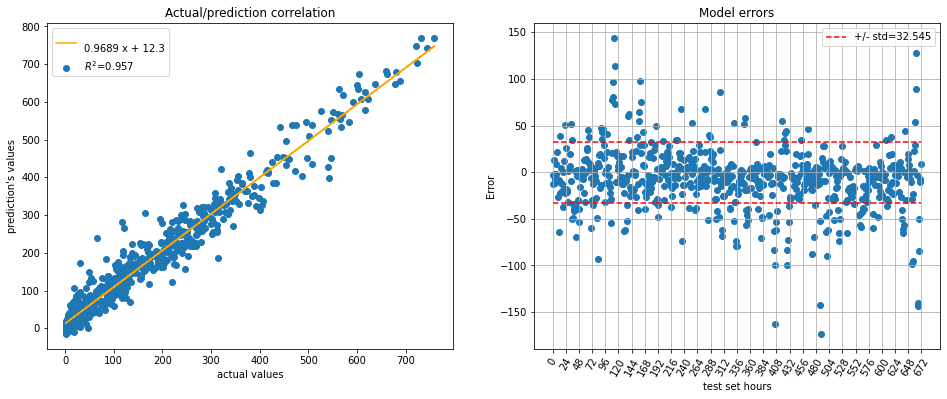

In [ ]:
plot_errors(y_test, predictions)

In [ ]:
final_model = LGBMRegressor(**params, n_jobs=-1, random_state=SEED)
final_model.fit(data[features], data.cnt)

LGBMRegressor(bagging_fraction=1.0, bagging_freq=0, eval_metric='rmse',
              feature_fraction=0.8, feature_pre_filter=False,
              lambda_l1=0.005316404729682503, lambda_l2=1.05807636279867e-08,
              metric='rmse', n_estimators=523, objective='regression',
              random_state=100, verbosity=-1)

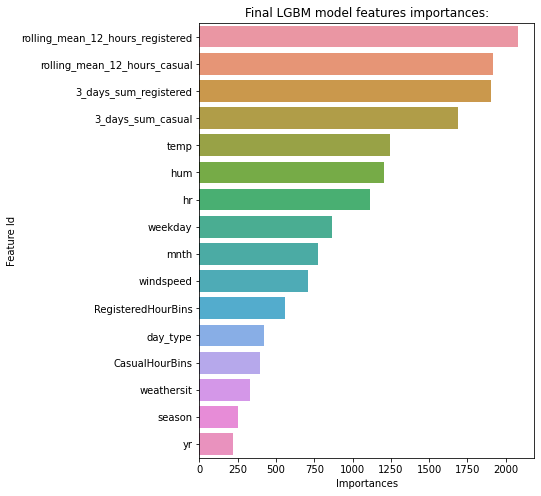

In [ ]:
plot_importances('Final LGBM model', final_model.feature_importances_)

In [ ]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(final_model)
shap_values = explainer(X_test)

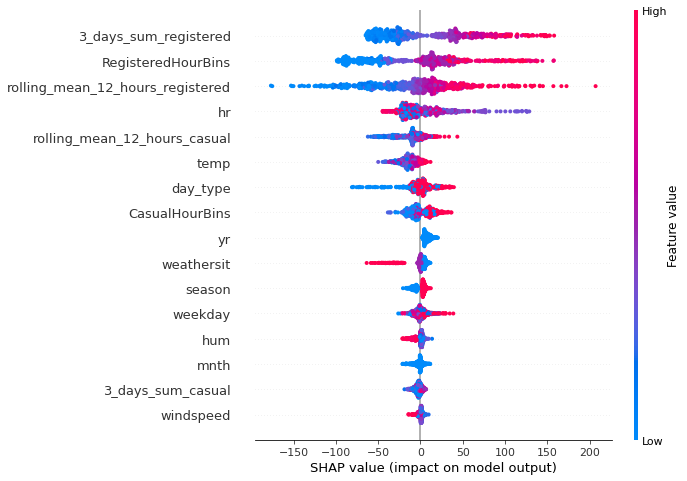

In [ ]:
# SHAP explanation of the feature importances
shap.summary_plot(shap_values, X_test)

Actual number of total counts: 49


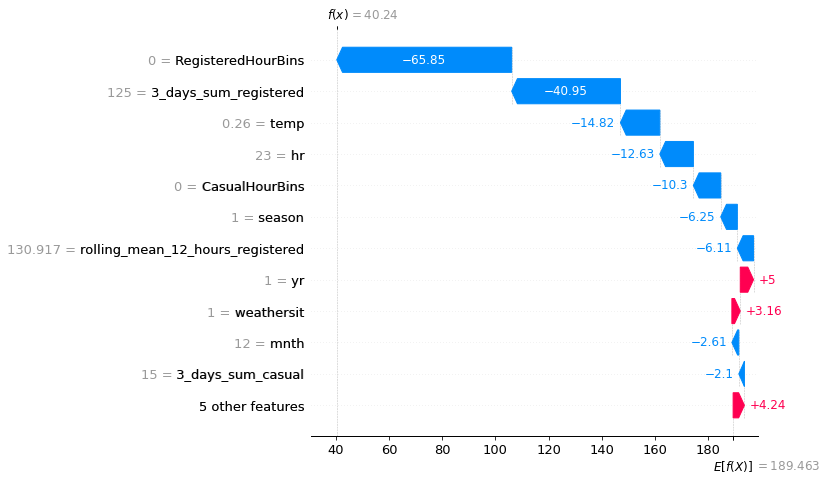

In [ ]:
# visualize the last prediction's explanation
print(f'Actual number of total counts: {y_test.iloc[671]}')
shap.plots.waterfall(shap_values[671], max_display=12)

# Two models hypothesis test

In [ ]:
# Define separate datasets for casual and registered users
features1 = ['temp', 'hum', 'windspeed', 'hr', '3_days_sum_casual',
            'rolling_mean_12_hours_casual','season', 'yr', 'mnth',  
             'day_type', 'weathersit', 'CasualHourBins', 'weekday']

features2 = ['temp', 'hum', 'windspeed', 'hr', '3_days_sum_registered',
            'rolling_mean_12_hours_registered', 'season', 'yr', 'mnth',  
            'day_type', 'weathersit', 'RegisteredHourBins', 'weekday']

val_len = 24 * 7 * 4
test_len = 24 * 7 * 4

X_train_full_1, y_train_full_1 = data[features1].iloc[:-test_len, :], data.casual.iloc[:-test_len]
X_test_1, y_test_1 = data[features1].iloc[-test_len:, :], data.casual.iloc[-test_len:]

X_train_full_2, y_train_full_2 = data[features2].iloc[:-test_len, :], data.registered.iloc[:-test_len]
X_test_2, y_test_2 = data[features2].iloc[-test_len:, :], data.registered.iloc[-test_len:]

In [ ]:
# crossvalidation with overfitting detection using early stopping
rmse = list()

for train_indx, test_indx in ts_cv.split(X_train_full):
    X_train_1 = X_train_full_1.iloc[train_indx, :]
    X_valid_1 = X_train_full_1.iloc[test_indx, :]

    y_train_1 = y_train_full_1.iloc[train_indx]
    y_valid_1 = y_train_full_1.iloc[test_indx]

    y_valid = y_train_full.iloc[test_indx]

    eval_set = [(X_train_1, y_train_1), (X_valid_1, y_valid_1)]

    model_1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=SEED, objective='regression')
   
    model_1.fit(X_train_1, y_train_1, eval_metric=["rmse"], eval_set=eval_set, 
              eval_names=['train', 'valid'],
              early_stopping_rounds=100, verbose=10)
    
    preds_1 = np.around(model_1.predict(X_valid_1).clip(0), 0)
    rmse_1 = mean_squared_error(y_valid_1, preds_1, squared=False)

    X_train_2 = X_train_full_2.iloc[train_indx, :]
    X_valid_2 = X_train_full_2.iloc[test_indx, :]

    y_train_2 = y_train_full_2.iloc[train_indx]
    y_valid_2 = y_train_full_2.iloc[test_indx]

    eval_set = [(X_train_2, y_train_2), (X_valid_2, y_valid_2)]

    model_2 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=SEED, objective='regression')
   
    model_2.fit(X_train_2, y_train_2, eval_metric=["rmse"], eval_set=eval_set, 
              eval_names=['train', 'valid'],
              early_stopping_rounds=100, verbose=10)
    
    preds_2 = np.around(model_2.predict(X_valid_2).clip(0), 0)
    rmse_2 = mean_squared_error(y_valid_2, preds_2, squared=False)
    
    preds = preds_1 + preds_2

    rmse_0 = mean_squared_error(y_valid, preds, squared=False)

    rmse.append((rmse_0, rmse_1, rmse_2))

df_scores = pd.DataFrame(rmse, columns=['rmse', 'rmse_1', 'rmse_2'])
print(f"Root Mean Squared Error: {df_scores.rmse.mean():.3f} +/- {df_scores.rmse.std():.3f}")

Training until validation scores don't improve for 100 rounds.
[10]	train's l2: 488.618	train's rmse: 22.1047	valid's l2: 626.52	valid's rmse: 25.0304
[20]	train's l2: 199.275	train's rmse: 14.1165	valid's l2: 269.844	valid's rmse: 16.4269
[30]	train's l2: 130.573	train's rmse: 11.4269	valid's l2: 231.047	valid's rmse: 15.2002
[40]	train's l2: 106.285	train's rmse: 10.3094	valid's l2: 224.368	valid's rmse: 14.9789
[50]	train's l2: 92.9228	train's rmse: 9.63965	valid's l2: 216.098	valid's rmse: 14.7003
[60]	train's l2: 85.255	train's rmse: 9.23337	valid's l2: 213.35	valid's rmse: 14.6065
[70]	train's l2: 79.5708	train's rmse: 8.92025	valid's l2: 211.493	valid's rmse: 14.5428
[80]	train's l2: 75.3165	train's rmse: 8.67851	valid's l2: 210.748	valid's rmse: 14.5172
[90]	train's l2: 71.7004	train's rmse: 8.46761	valid's l2: 208.302	valid's rmse: 14.4327
[100]	train's l2: 68.3425	train's rmse: 8.26695	valid's l2: 207.665	valid's rmse: 14.4106
[110]	train's l2: 65.528	train's rmse: 8.09494	va

Performance (with default parameters on crossvalidation) of two separate `LGBMRegressor` models is better than performance of single model (50.742 against 52.17). Let's check performance after tuning:

In [ ]:
dtrain = lgb.Dataset(X_train_full_1, label=y_train_full_1)
dvalid = lgb.Dataset(X_test_1, label=y_test_1)

param = {'objective': 'regression',
         'metric': 'rmse',
         'eval_metric': 'rmse',
         "boosting_type": "gbdt",
         'verbosity': -1}

tuner_1 = lgb.LightGBMTuner(
     param, dtrain, valid_sets=[dtrain, dvalid], valid_names=['train', 'valid'], 
     verbose_eval=50, early_stopping_rounds=100, optuna_seed=SEED,
     model_dir= '/content/model_1/', time_budget=2000, show_progress_bar=False)

tuner_1.run()

[I 2021-10-29 23:45:46,277] A new study created in memory with name: no-name-acedadbd-d77a-4e02-b802-46505b19e362


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 10.4537	valid's rmse: 7.99761
[100]	train's rmse: 9.0876	valid's rmse: 7.49895
[150]	train's rmse: 8.39394	valid's rmse: 7.37186
[200]	train's rmse: 7.89279	valid's rmse: 7.31489
[250]	train's rmse: 7.51342	valid's rmse: 7.2813
[300]	train's rmse: 7.19676	valid's rmse: 7.25662
[350]	train's rmse: 6.90395	valid's rmse: 7.21367
[400]	train's rmse: 6.64587	valid's rmse: 7.19915
[450]	train's rmse: 6.42096	valid's rmse: 7.18948
[500]	train's rmse: 6.21365	valid's rmse: 7.18644
[550]	train's rmse: 6.0375	valid's rmse: 7.16008
[600]	train's rmse: 5.84677	valid's rmse: 7.14654
[650]	train's rmse: 5.65249	valid's rmse: 7.1336
[700]	train's rmse: 5.46998	valid's rmse: 7.12923
[750]	train's rmse: 5.30269	valid's rmse: 7.14
Early stopping, best iteration is:
[657]	train's rmse: 5.62998	valid's rmse: 7.12654


[I 2021-10-29 23:45:47,919] The booster of trial#0 was saved as /content/model_1/0.pkl.
[I 2021-10-29 23:45:47,921] Trial 0 finished with value: 7.126539127699665 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 7.126539127699665.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 10.5579	valid's rmse: 7.79444
[100]	train's rmse: 9.1388	valid's rmse: 7.35351
[150]	train's rmse: 8.41919	valid's rmse: 7.17382
[200]	train's rmse: 7.91434	valid's rmse: 7.15073
[250]	train's rmse: 7.50962	valid's rmse: 7.11483
[300]	train's rmse: 7.16693	valid's rmse: 7.09305
[350]	train's rmse: 6.88632	valid's rmse: 7.10829


[I 2021-10-29 23:45:48,835] The booster of trial#1 was saved as /content/model_1/1.pkl.
[I 2021-10-29 23:45:48,841] Trial 1 finished with value: 7.084980119727545 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 7.084980119727545.


Early stopping, best iteration is:
[297]	train's rmse: 7.18421	valid's rmse: 7.08498
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 11.0523	valid's rmse: 9.09798
[100]	train's rmse: 9.59577	valid's rmse: 8.68985
[150]	train's rmse: 8.7745	valid's rmse: 8.508
[200]	train's rmse: 8.22969	valid's rmse: 8.40687
[250]	train's rmse: 7.79512	valid's rmse: 8.30363
[300]	train's rmse: 7.45504	valid's rmse: 8.28366
[350]	train's rmse: 7.16313	valid's rmse: 8.29056
[400]	train's rmse: 6.89433	valid's rmse: 8.25289
[450]	train's rmse: 6.65101	valid's rmse: 8.25113
[500]	train's rmse: 6.4209	valid's rmse: 8.24465
[550]	train's rmse: 6.22532	valid's rmse: 8.26145
Early stopping, best iteration is:
[477]	train's rmse: 6.52195	valid's rmse: 8.22837


[I 2021-10-29 23:45:49,992] The booster of trial#2 was saved as /content/model_1/2.pkl.
[I 2021-10-29 23:45:49,995] Trial 2 finished with value: 8.228368598701687 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 7.084980119727545.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 11.943	valid's rmse: 10.4246
[100]	train's rmse: 10.1441	valid's rmse: 9.68016
[150]	train's rmse: 9.20573	valid's rmse: 9.38953
[200]	train's rmse: 8.5585	valid's rmse: 9.17845
[250]	train's rmse: 8.10435	valid's rmse: 9.0699
[300]	train's rmse: 7.71493	valid's rmse: 9.02992
[350]	train's rmse: 7.39033	valid's rmse: 8.88188
[400]	train's rmse: 7.12179	valid's rmse: 8.86026
[450]	train's rmse: 6.87459	valid's rmse: 8.84139
[500]	train's rmse: 6.64494	valid's rmse: 8.7974
[550]	train's rmse: 6.45743	valid's rmse: 8.75661
[600]	train's rmse: 6.27319	valid's rmse: 8.72246
[650]	train's rmse: 6.11595	valid's rmse: 8.6969
[700]	train's rmse: 5.93716	valid's rmse: 8.65917
[750]	train's rmse: 5.79644	valid's rmse: 8.64014
[800]	train's rmse: 5.66727	valid's rmse: 8.62346
[850]	train's rmse: 5.52356	valid's rmse: 8.62936
[900]	train's rmse: 5.40182	valid's rmse: 8.62244
[950]	train's rmse: 5.30137	valid's rmse: 8

[I 2021-10-29 23:45:51,962] The booster of trial#3 was saved as /content/model_1/3.pkl.
[I 2021-10-29 23:45:51,966] Trial 3 finished with value: 8.586620965599693 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 7.084980119727545.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 10.5924	valid's rmse: 7.86947
[100]	train's rmse: 9.07266	valid's rmse: 7.38238
[150]	train's rmse: 8.37413	valid's rmse: 7.21047
[200]	train's rmse: 7.85907	valid's rmse: 7.11473
[250]	train's rmse: 7.45096	valid's rmse: 7.09805
[300]	train's rmse: 7.08785	valid's rmse: 7.05954
[350]	train's rmse: 6.77805	valid's rmse: 7.0611
[400]	train's rmse: 6.51645	valid's rmse: 7.00994
[450]	train's rmse: 6.25084	valid's rmse: 6.98776
[500]	train's rmse: 6.0132	valid's rmse: 7.00514
[550]	train's rmse: 5.79517	valid's rmse: 7.03462
Early stopping, best iteration is:
[465]	train's rmse: 6.1824	valid's rmse: 6.97943


[I 2021-10-29 23:45:53,355] The booster of trial#4 was saved as /content/model_1/4.pkl.
[I 2021-10-29 23:45:53,358] Trial 4 finished with value: 6.979427012847184 and parameters: {'feature_fraction': 1.0}. Best is trial 4 with value: 6.979427012847184.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 10.5975	valid's rmse: 8.31621
[100]	train's rmse: 9.28104	valid's rmse: 7.82021
[150]	train's rmse: 8.55984	valid's rmse: 7.58091
[200]	train's rmse: 8.08622	valid's rmse: 7.47734
[250]	train's rmse: 7.68486	valid's rmse: 7.44522
[300]	train's rmse: 7.3703	valid's rmse: 7.43443
[350]	train's rmse: 7.06509	valid's rmse: 7.41899
[400]	train's rmse: 6.76552	valid's rmse: 7.37292
[450]	train's rmse: 6.53505	valid's rmse: 7.35928
[500]	train's rmse: 6.3223	valid's rmse: 7.32116
[550]	train's rmse: 6.1419	valid's rmse: 7.28581
[600]	train's rmse: 5.95127	valid's rmse: 7.23798
[650]	train's rmse: 5.77279	valid's rmse: 7.21117
[700]	train's rmse: 5.60434	valid's rmse: 7.23716
Early stopping, best iteration is:
[645]	train's rmse: 5.79329	valid's rmse: 7.20229


[I 2021-10-29 23:45:54,907] The booster of trial#5 was saved as /content/model_1/5.pkl.
[I 2021-10-29 23:45:54,914] Trial 5 finished with value: 7.2022929903488935 and parameters: {'feature_fraction': 0.6}. Best is trial 4 with value: 6.979427012847184.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 10.4557	valid's rmse: 7.92909
[100]	train's rmse: 8.99562	valid's rmse: 7.41363
[150]	train's rmse: 8.31813	valid's rmse: 7.22493
[200]	train's rmse: 7.8654	valid's rmse: 7.15147
[250]	train's rmse: 7.48471	valid's rmse: 7.13365
[300]	train's rmse: 7.14338	valid's rmse: 7.11126
[350]	train's rmse: 6.85129	valid's rmse: 7.1095


[I 2021-10-29 23:45:55,906] The booster of trial#6 was saved as /content/model_1/6.pkl.
[I 2021-10-29 23:45:55,911] Trial 6 finished with value: 7.088301538721324 and parameters: {'feature_fraction': 0.8}. Best is trial 4 with value: 6.979427012847184.


[400]	train's rmse: 6.56728	valid's rmse: 7.1036
[450]	train's rmse: 6.31792	valid's rmse: 7.13148
Early stopping, best iteration is:
[366]	train's rmse: 6.75408	valid's rmse: 7.0883
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 7.71761	valid's rmse: 7.347
[100]	train's rmse: 5.97508	valid's rmse: 7.19832
[150]	train's rmse: 5.00711	valid's rmse: 7.1999
[200]	train's rmse: 4.2906	valid's rmse: 7.2889
Early stopping, best iteration is:
[121]	train's rmse: 5.51102	valid's rmse: 7.18333


[I 2021-10-29 23:45:57,340] The booster of trial#7 was saved as /content/model_1/7.pkl.
[I 2021-10-29 23:45:57,344] Trial 7 finished with value: 7.183332719639941 and parameters: {'num_leaves': 140}. Best is trial 7 with value: 7.183332719639941.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.79683	valid's rmse: 7.52125
[100]	train's rmse: 7.36449	valid's rmse: 7.23202
[150]	train's rmse: 6.53492	valid's rmse: 7.12723
[200]	train's rmse: 5.90834	valid's rmse: 7.10785
[250]	train's rmse: 5.45014	valid's rmse: 7.10505
[300]	train's rmse: 5.00786	valid's rmse: 7.14319
Early stopping, best iteration is:
[207]	train's rmse: 5.8308	valid's rmse: 7.09111


[I 2021-10-29 23:45:58,626] The booster of trial#8 was saved as /content/model_1/8.pkl.
[I 2021-10-29 23:45:58,629] Trial 8 finished with value: 7.091108573997437 and parameters: {'num_leaves': 72}. Best is trial 8 with value: 7.091108573997437.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.08853	valid's rmse: 7.09824
[100]	train's rmse: 6.4956	valid's rmse: 6.93678
[150]	train's rmse: 5.59722	valid's rmse: 6.88107
[200]	train's rmse: 4.93999	valid's rmse: 6.94603
[250]	train's rmse: 4.41036	valid's rmse: 7.00065


[I 2021-10-29 23:45:59,974] The booster of trial#9 was saved as /content/model_1/9.pkl.


Early stopping, best iteration is:
[151]	train's rmse: 5.58071	valid's rmse: 6.87929


[I 2021-10-29 23:45:59,979] Trial 9 finished with value: 6.879291369150256 and parameters: {'num_leaves': 110}. Best is trial 9 with value: 6.879291369150256.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 7.08823	valid's rmse: 7.50469
[100]	train's rmse: 5.02968	valid's rmse: 7.39035
[150]	train's rmse: 3.94008	valid's rmse: 7.38071
[200]	train's rmse: 3.21911	valid's rmse: 7.39986
Early stopping, best iteration is:
[118]	train's rmse: 4.57367	valid's rmse: 7.33559


[I 2021-10-29 23:46:01,920] The booster of trial#10 was saved as /content/model_1/10.pkl.
[I 2021-10-29 23:46:01,923] Trial 10 finished with value: 7.335591108464521 and parameters: {'num_leaves': 217}. Best is trial 9 with value: 6.879291369150256.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 20.9493	valid's rmse: 13.6328
[100]	train's rmse: 18.7717	valid's rmse: 12.687
[150]	train's rmse: 17.569	valid's rmse: 11.986
[200]	train's rmse: 16.7863	valid's rmse: 11.5667
[250]	train's rmse: 16.2295	valid's rmse: 11.4454
[300]	train's rmse: 15.8402	valid's rmse: 11.2619
[350]	train's rmse: 15.5286	valid's rmse: 11.2131
[400]	train's rmse: 15.2721	valid's rmse: 11.1707
[450]	train's rmse: 15.0364	valid's rmse: 11.1499
[500]	train's rmse: 14.8448	valid's rmse: 11.0721
[550]	train's rmse: 14.6612	valid's rmse: 10.9307
[600]	train's rmse: 14.524	valid's rmse: 10.8803
[650]	train's rmse: 14.3711	valid's rmse: 10.8117
[700]	train's rmse: 14.2551	valid's rmse: 10.7542
[750]	train's rmse: 14.1242	valid's rmse: 10.6888
[800]	train's rmse: 13.9714	valid's rmse: 10.6429
[850]	train's rmse: 13.8552	valid's rmse: 10.6114


[I 2021-10-29 23:46:03,018] The booster of trial#11 was saved as /content/model_1/11.pkl.
[I 2021-10-29 23:46:03,025] Trial 11 finished with value: 10.557364241179382 and parameters: {'num_leaves': 3}. Best is trial 9 with value: 6.879291369150256.


[900]	train's rmse: 13.7522	valid's rmse: 10.6025
[950]	train's rmse: 13.6509	valid's rmse: 10.5844
[1000]	train's rmse: 13.5603	valid's rmse: 10.5574
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 13.5603	valid's rmse: 10.5574
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 10.4014	valid's rmse: 7.66591
[100]	train's rmse: 8.93992	valid's rmse: 7.27484
[150]	train's rmse: 8.25601	valid's rmse: 7.19677
[200]	train's rmse: 7.73879	valid's rmse: 7.13862
[250]	train's rmse: 7.30127	valid's rmse: 7.14521
[300]	train's rmse: 6.94037	valid's rmse: 7.13482
[350]	train's rmse: 6.64635	valid's rmse: 7.10814
[400]	train's rmse: 6.37011	valid's rmse: 7.07361
[450]	train's rmse: 6.10556	valid's rmse: 7.03861
[500]	train's rmse: 5.88202	valid's rmse: 7.03225
[550]	train's rmse: 5.689	valid's rmse: 7.01081
[600]	train's rmse: 5.49297	valid's rmse: 7.01768
[650]	train's rmse: 5.26878	valid's rmse: 7.0481
Early stopping, best iteration is:
[571]	

[I 2021-10-29 23:46:04,747] The booster of trial#12 was saved as /content/model_1/12.pkl.
[I 2021-10-29 23:46:04,753] Trial 12 finished with value: 7.002290294363695 and parameters: {'num_leaves': 33}. Best is trial 9 with value: 6.879291369150256.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 7.40638	valid's rmse: 7.45793
[100]	train's rmse: 5.5279	valid's rmse: 7.39021


[I 2021-10-29 23:46:05,909] The booster of trial#13 was saved as /content/model_1/13.pkl.
[I 2021-10-29 23:46:05,912] Trial 13 finished with value: 7.36409865590075 and parameters: {'num_leaves': 173}. Best is trial 9 with value: 6.879291369150256.


[150]	train's rmse: 4.50543	valid's rmse: 7.39873
Early stopping, best iteration is:
[64]	train's rmse: 6.68165	valid's rmse: 7.3641
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 7.13135	valid's rmse: 7.45973
[100]	train's rmse: 5.09821	valid's rmse: 7.4605
[150]	train's rmse: 4.05423	valid's rmse: 7.46071
[200]	train's rmse: 3.29913	valid's rmse: 7.47362
Early stopping, best iteration is:
[113]	train's rmse: 4.77702	valid's rmse: 7.40456


[I 2021-10-29 23:46:07,813] The booster of trial#14 was saved as /content/model_1/14.pkl.
[I 2021-10-29 23:46:07,818] Trial 14 finished with value: 7.40455890577449 and parameters: {'num_leaves': 212}. Best is trial 9 with value: 6.879291369150256.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 10.2044	valid's rmse: 7.95832
[100]	train's rmse: 8.82218	valid's rmse: 7.53256
[150]	train's rmse: 8.11585	valid's rmse: 7.43005
[200]	train's rmse: 7.59144	valid's rmse: 7.36815
[250]	train's rmse: 7.12562	valid's rmse: 7.36749
[300]	train's rmse: 6.76933	valid's rmse: 7.38338
[350]	train's rmse: 6.46036	valid's rmse: 7.33619
[400]	train's rmse: 6.14826	valid's rmse: 7.34764


[I 2021-10-29 23:46:08,976] The booster of trial#15 was saved as /content/model_1/15.pkl.
[I 2021-10-29 23:46:08,982] Trial 15 finished with value: 7.33183510422612 and parameters: {'num_leaves': 36}. Best is trial 9 with value: 6.879291369150256.


[450]	train's rmse: 5.88014	valid's rmse: 7.36587
Early stopping, best iteration is:
[352]	train's rmse: 6.44777	valid's rmse: 7.33184
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 7.61685	valid's rmse: 7.37834
[100]	train's rmse: 5.82147	valid's rmse: 7.28011
[150]	train's rmse: 4.84885	valid's rmse: 7.37936
Early stopping, best iteration is:
[83]	train's rmse: 6.28071	valid's rmse: 7.26941


[I 2021-10-29 23:46:10,160] The booster of trial#16 was saved as /content/model_1/16.pkl.
[I 2021-10-29 23:46:10,168] Trial 16 finished with value: 7.269411750823841 and parameters: {'num_leaves': 148}. Best is trial 9 with value: 6.879291369150256.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.3565	valid's rmse: 7.34917
[100]	train's rmse: 6.82666	valid's rmse: 7.15192
[150]	train's rmse: 5.99015	valid's rmse: 7.21503


[I 2021-10-29 23:46:11,091] The booster of trial#17 was saved as /content/model_1/17.pkl.
[I 2021-10-29 23:46:11,097] Trial 17 finished with value: 7.140430429312184 and parameters: {'num_leaves': 93}. Best is trial 9 with value: 6.879291369150256.


Early stopping, best iteration is:
[95]	train's rmse: 6.93052	valid's rmse: 7.14043
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.55901	valid's rmse: 7.26311
[100]	train's rmse: 7.10076	valid's rmse: 6.98586
[150]	train's rmse: 6.2711	valid's rmse: 6.99654


[I 2021-10-29 23:46:12,049] The booster of trial#18 was saved as /content/model_1/18.pkl.
[I 2021-10-29 23:46:12,057] Trial 18 finished with value: 6.982559865690168 and parameters: {'num_leaves': 83}. Best is trial 9 with value: 6.879291369150256.


[200]	train's rmse: 5.63482	valid's rmse: 7.0506
Early stopping, best iteration is:
[109]	train's rmse: 6.92096	valid's rmse: 6.98256
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.33526	valid's rmse: 7.25736
[100]	train's rmse: 6.81233	valid's rmse: 7.23537
[150]	train's rmse: 6.00331	valid's rmse: 7.18163
[200]	train's rmse: 5.38486	valid's rmse: 7.17915
[250]	train's rmse: 4.84995	valid's rmse: 7.23385


[I 2021-10-29 23:46:13,303] The booster of trial#19 was saved as /content/model_1/19.pkl.
[I 2021-10-29 23:46:13,309] Trial 19 finished with value: 7.170740051921736 and parameters: {'num_leaves': 94}. Best is trial 9 with value: 6.879291369150256.


Early stopping, best iteration is:
[156]	train's rmse: 5.9072	valid's rmse: 7.17074
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.18602	valid's rmse: 7.27208
[100]	train's rmse: 6.59329	valid's rmse: 7.14988
[150]	train's rmse: 5.70964	valid's rmse: 7.13413
[200]	train's rmse: 5.048	valid's rmse: 7.11161
[250]	train's rmse: 4.51026	valid's rmse: 7.14383
Early stopping, best iteration is:
[191]	train's rmse: 5.1579	valid's rmse: 7.09371


[I 2021-10-29 23:46:14,857] The booster of trial#20 was saved as /content/model_1/20.pkl.
[I 2021-10-29 23:46:14,863] Trial 20 finished with value: 7.093714996529264 and parameters: {'num_leaves': 106}. Best is trial 9 with value: 6.879291369150256.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 9.00399	valid's rmse: 7.41148
[100]	train's rmse: 7.58349	valid's rmse: 7.21325
[150]	train's rmse: 6.78708	valid's rmse: 7.26372
[200]	train's rmse: 6.17315	valid's rmse: 7.20207
[250]	train's rmse: 5.6773	valid's rmse: 7.16143
[300]	train's rmse: 5.25989	valid's rmse: 7.17419
[350]	train's rmse: 4.88758	valid's rmse: 7.21574
Early stopping, best iteration is:
[258]	train's rmse: 5.6032	valid's rmse: 7.14945


[I 2021-10-29 23:46:16,241] The booster of trial#21 was saved as /content/model_1/21.pkl.
[I 2021-10-29 23:46:16,249] Trial 21 finished with value: 7.149454035858488 and parameters: {'num_leaves': 65}. Best is trial 9 with value: 6.879291369150256.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 6.93057	valid's rmse: 7.49976
[100]	train's rmse: 4.75596	valid's rmse: 7.39789
[150]	train's rmse: 3.61866	valid's rmse: 7.43569
Early stopping, best iteration is:
[82]	train's rmse: 5.34249	valid's rmse: 7.3594


[I 2021-10-29 23:46:18,092] The booster of trial#22 was saved as /content/model_1/22.pkl.
[I 2021-10-29 23:46:18,095] Trial 22 finished with value: 7.359398330266094 and parameters: {'num_leaves': 254}. Best is trial 9 with value: 6.879291369150256.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 7.9848	valid's rmse: 7.14421
[100]	train's rmse: 6.3329	valid's rmse: 7.00159
[150]	train's rmse: 5.38887	valid's rmse: 7.0171
[200]	train's rmse: 4.71717	valid's rmse: 7.0351
Early stopping, best iteration is:
[138]	train's rmse: 5.59036	valid's rmse: 6.99188


[I 2021-10-29 23:46:19,460] The booster of trial#23 was saved as /content/model_1/23.pkl.
[I 2021-10-29 23:46:19,466] Trial 23 finished with value: 6.991884122808762 and parameters: {'num_leaves': 119}. Best is trial 9 with value: 6.879291369150256.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 9.08519	valid's rmse: 7.42378
[100]	train's rmse: 7.6569	valid's rmse: 7.20395
[150]	train's rmse: 6.83056	valid's rmse: 7.1326
[200]	train's rmse: 6.24586	valid's rmse: 7.09341
[250]	train's rmse: 5.77333	valid's rmse: 7.05512
[300]	train's rmse: 5.3876	valid's rmse: 7.05938
[350]	train's rmse: 5.02818	valid's rmse: 7.08858
Early stopping, best iteration is:
[288]	train's rmse: 5.48342	valid's rmse: 7.04341


[I 2021-10-29 23:46:20,909] The booster of trial#24 was saved as /content/model_1/24.pkl.
[I 2021-10-29 23:46:20,915] Trial 24 finished with value: 7.04341140154852 and parameters: {'num_leaves': 61}. Best is trial 9 with value: 6.879291369150256.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 7.48483	valid's rmse: 7.4098
[100]	train's rmse: 5.64519	valid's rmse: 7.31453
[150]	train's rmse: 4.62683	valid's rmse: 7.30635


[I 2021-10-29 23:46:22,304] The booster of trial#25 was saved as /content/model_1/25.pkl.
[I 2021-10-29 23:46:22,310] Trial 25 finished with value: 7.295521131607448 and parameters: {'num_leaves': 166}. Best is trial 9 with value: 6.879291369150256.


Early stopping, best iteration is:
[88]	train's rmse: 5.95218	valid's rmse: 7.29552
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 10.2044	valid's rmse: 7.95832
[100]	train's rmse: 8.82218	valid's rmse: 7.53256
[150]	train's rmse: 8.11585	valid's rmse: 7.43005
[200]	train's rmse: 7.59144	valid's rmse: 7.36815
[250]	train's rmse: 7.12562	valid's rmse: 7.36749
[300]	train's rmse: 6.76933	valid's rmse: 7.38338
[350]	train's rmse: 6.46036	valid's rmse: 7.33619
[400]	train's rmse: 6.14826	valid's rmse: 7.34764
[450]	train's rmse: 5.88014	valid's rmse: 7.36587
Early stopping, best iteration is:
[352]	train's rmse: 6.44777	valid's rmse: 7.33184


[I 2021-10-29 23:46:23,460] The booster of trial#26 was saved as /content/model_1/26.pkl.
[I 2021-10-29 23:46:23,465] Trial 26 finished with value: 7.33183510422612 and parameters: {'num_leaves': 36}. Best is trial 9 with value: 6.879291369150256.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.44482	valid's rmse: 7.35038
[100]	train's rmse: 6.70913	valid's rmse: 7.20187
[150]	train's rmse: 5.69975	valid's rmse: 7.15824
[200]	train's rmse: 4.96495	valid's rmse: 7.16178
[250]	train's rmse: 4.41579	valid's rmse: 7.13972
[300]	train's rmse: 3.9594	valid's rmse: 7.16006
[350]	train's rmse: 3.57513	valid's rmse: 7.17249
Early stopping, best iteration is:
[293]	train's rmse: 4.01458	valid's rmse: 7.10622


[I 2021-10-29 23:46:26,133] The booster of trial#27 was saved as /content/model_1/27.pkl.
[I 2021-10-29 23:46:26,136] Trial 27 finished with value: 7.1062210809724435 and parameters: {'bagging_fraction': 0.7260429650751228, 'bagging_freq': 2}. Best is trial 27 with value: 7.1062210809724435.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.65993	valid's rmse: 7.49529
[100]	train's rmse: 6.99959	valid's rmse: 7.4485
[150]	train's rmse: 5.9921	valid's rmse: 7.36528
[200]	train's rmse: 5.27285	valid's rmse: 7.26705
[250]	train's rmse: 4.68519	valid's rmse: 7.23557
[300]	train's rmse: 4.2136	valid's rmse: 7.25819
[350]	train's rmse: 3.81285	valid's rmse: 7.27329
Early stopping, best iteration is:
[256]	train's rmse: 4.62912	valid's rmse: 7.2198


[I 2021-10-29 23:46:28,511] The booster of trial#28 was saved as /content/model_1/28.pkl.
[I 2021-10-29 23:46:28,514] Trial 28 finished with value: 7.21980434406743 and parameters: {'bagging_fraction': 0.6547105544499044, 'bagging_freq': 6}. Best is trial 27 with value: 7.1062210809724435.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 9.41124	valid's rmse: 7.71259
[100]	train's rmse: 7.75967	valid's rmse: 7.60749
[150]	train's rmse: 6.75614	valid's rmse: 7.62298
[200]	train's rmse: 6.0442	valid's rmse: 7.70048
Early stopping, best iteration is:
[127]	train's rmse: 7.1765	valid's rmse: 7.54599


[I 2021-10-29 23:46:30,115] The booster of trial#29 was saved as /content/model_1/29.pkl.
[I 2021-10-29 23:46:30,121] Trial 29 finished with value: 7.545987977495904 and parameters: {'bagging_fraction': 0.4028313137145883, 'bagging_freq': 1}. Best is trial 27 with value: 7.1062210809724435.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.37152	valid's rmse: 7.48711
[100]	train's rmse: 6.70558	valid's rmse: 7.36184
[150]	train's rmse: 5.73779	valid's rmse: 7.29659
[200]	train's rmse: 5.01346	valid's rmse: 7.29406
[250]	train's rmse: 4.43889	valid's rmse: 7.2591
[300]	train's rmse: 3.98914	valid's rmse: 7.24618
[350]	train's rmse: 3.58951	valid's rmse: 7.2925
Early stopping, best iteration is:
[258]	train's rmse: 4.35152	valid's rmse: 7.23983


[I 2021-10-29 23:46:32,543] The booster of trial#30 was saved as /content/model_1/30.pkl.
[I 2021-10-29 23:46:32,547] Trial 30 finished with value: 7.239830825065397 and parameters: {'bagging_fraction': 0.802449450836738, 'bagging_freq': 6}. Best is trial 27 with value: 7.1062210809724435.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 9.33025	valid's rmse: 8.11599
[100]	train's rmse: 7.66343	valid's rmse: 8.03751
[150]	train's rmse: 6.66511	valid's rmse: 8.09266
[200]	train's rmse: 5.93114	valid's rmse: 8.19095
Early stopping, best iteration is:
[124]	train's rmse: 7.12804	valid's rmse: 7.94982


[I 2021-10-29 23:46:34,032] The booster of trial#31 was saved as /content/model_1/31.pkl.
[I 2021-10-29 23:46:34,036] Trial 31 finished with value: 7.949824287327272 and parameters: {'bagging_fraction': 0.4820239538111085, 'bagging_freq': 5}. Best is trial 27 with value: 7.1062210809724435.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.15092	valid's rmse: 7.52812
[100]	train's rmse: 6.51395	valid's rmse: 7.35935
[150]	train's rmse: 5.49067	valid's rmse: 7.26426
[200]	train's rmse: 4.81351	valid's rmse: 7.23687
[250]	train's rmse: 4.25855	valid's rmse: 7.29831
Early stopping, best iteration is:
[184]	train's rmse: 5.01517	valid's rmse: 7.2344


[I 2021-10-29 23:46:35,920] The booster of trial#32 was saved as /content/model_1/32.pkl.
[I 2021-10-29 23:46:35,925] Trial 32 finished with value: 7.234396733263004 and parameters: {'bagging_fraction': 0.9347931725882498, 'bagging_freq': 2}. Best is trial 27 with value: 7.1062210809724435.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.93295	valid's rmse: 7.67253
[100]	train's rmse: 7.24288	valid's rmse: 7.55664
[150]	train's rmse: 6.20374	valid's rmse: 7.60486
Early stopping, best iteration is:
[82]	train's rmse: 7.71514	valid's rmse: 7.48384


[I 2021-10-29 23:46:37,007] The booster of trial#33 was saved as /content/model_1/33.pkl.
[I 2021-10-29 23:46:37,014] Trial 33 finished with value: 7.483837876605079 and parameters: {'bagging_fraction': 0.5111969317302304, 'bagging_freq': 1}. Best is trial 27 with value: 7.1062210809724435.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 9.247	valid's rmse: 7.97269
[100]	train's rmse: 7.49826	valid's rmse: 7.93371
[150]	train's rmse: 6.44356	valid's rmse: 7.91393
[200]	train's rmse: 5.70866	valid's rmse: 7.98341
Early stopping, best iteration is:
[132]	train's rmse: 6.78926	valid's rmse: 7.88414


[I 2021-10-29 23:46:38,624] The booster of trial#34 was saved as /content/model_1/34.pkl.
[I 2021-10-29 23:46:38,629] Trial 34 finished with value: 7.884135011940999 and parameters: {'bagging_fraction': 0.531818495575215, 'bagging_freq': 7}. Best is trial 27 with value: 7.1062210809724435.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.17044	valid's rmse: 7.36649
[100]	train's rmse: 6.54075	valid's rmse: 7.28107
[150]	train's rmse: 5.57666	valid's rmse: 7.33976
Early stopping, best iteration is:
[78]	train's rmse: 7.08671	valid's rmse: 7.24403


[I 2021-10-29 23:46:39,785] The booster of trial#35 was saved as /content/model_1/35.pkl.
[I 2021-10-29 23:46:39,789] Trial 35 finished with value: 7.244032028958318 and parameters: {'bagging_fraction': 0.8870098894544057, 'bagging_freq': 2}. Best is trial 27 with value: 7.1062210809724435.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.16708	valid's rmse: 7.40614
[100]	train's rmse: 6.483	valid's rmse: 7.21917
[150]	train's rmse: 5.52158	valid's rmse: 7.1802
[200]	train's rmse: 4.79881	valid's rmse: 7.16653
[250]	train's rmse: 4.24993	valid's rmse: 7.16577
[300]	train's rmse: 3.80413	valid's rmse: 7.19815
Early stopping, best iteration is:
[241]	train's rmse: 4.34613	valid's rmse: 7.14233


[I 2021-10-29 23:46:42,021] The booster of trial#36 was saved as /content/model_1/36.pkl.
[I 2021-10-29 23:46:42,025] Trial 36 finished with value: 7.142332696702388 and parameters: {'bagging_fraction': 0.8897348492363203, 'bagging_freq': 2}. Best is trial 27 with value: 7.1062210809724435.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.0342	valid's rmse: 7.16923
[100]	train's rmse: 6.46515	valid's rmse: 7.05702
[150]	train's rmse: 5.52475	valid's rmse: 6.9675
[200]	train's rmse: 4.87109	valid's rmse: 6.95005
[250]	train's rmse: 4.35969	valid's rmse: 6.99371
[300]	train's rmse: 3.92349	valid's rmse: 7.01223
Early stopping, best iteration is:
[200]	train's rmse: 4.87109	valid's rmse: 6.95005


[I 2021-10-29 23:46:43,660] The booster of trial#37 was saved as /content/model_1/37.pkl.
[I 2021-10-29 23:46:43,667] Trial 37 finished with value: 6.95005136490357 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 6.95005136490357.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 7.99424	valid's rmse: 7.17065
[100]	train's rmse: 6.452	valid's rmse: 6.97957
[150]	train's rmse: 5.58412	valid's rmse: 6.89171
[200]	train's rmse: 4.92391	valid's rmse: 6.91374


[I 2021-10-29 23:46:44,960] The booster of trial#38 was saved as /content/model_1/38.pkl.
[I 2021-10-29 23:46:44,966] Trial 38 finished with value: 6.879123060290879 and parameters: {'feature_fraction': 0.92}. Best is trial 38 with value: 6.879123060290879.


Early stopping, best iteration is:
[147]	train's rmse: 5.63581	valid's rmse: 6.87912
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.0342	valid's rmse: 7.16923
[100]	train's rmse: 6.46515	valid's rmse: 7.05702
[150]	train's rmse: 5.52475	valid's rmse: 6.9675
[200]	train's rmse: 4.87109	valid's rmse: 6.95005
[250]	train's rmse: 4.35969	valid's rmse: 6.99371
[300]	train's rmse: 3.92349	valid's rmse: 7.01223
Early stopping, best iteration is:
[200]	train's rmse: 4.87109	valid's rmse: 6.95005


[I 2021-10-29 23:46:46,601] The booster of trial#39 was saved as /content/model_1/39.pkl.
[I 2021-10-29 23:46:46,605] Trial 39 finished with value: 6.95005136490357 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 38 with value: 6.879123060290879.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 7.99425	valid's rmse: 7.17065
[100]	train's rmse: 6.45201	valid's rmse: 6.97957
[150]	train's rmse: 5.58399	valid's rmse: 6.89172
[200]	train's rmse: 4.94919	valid's rmse: 6.8559
[250]	train's rmse: 4.46402	valid's rmse: 6.90794
Early stopping, best iteration is:
[170]	train's rmse: 5.31619	valid's rmse: 6.84213


[I 2021-10-29 23:46:48,011] The booster of trial#40 was saved as /content/model_1/40.pkl.
[I 2021-10-29 23:46:48,017] Trial 40 finished with value: 6.842127109644956 and parameters: {'lambda_l1': 0.0007773998922821829, 'lambda_l2': 3.2012859298995277e-06}. Best is trial 40 with value: 6.842127109644956.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.03027	valid's rmse: 7.34725
[100]	train's rmse: 6.47216	valid's rmse: 7.13915
[150]	train's rmse: 5.60032	valid's rmse: 7.18595


[I 2021-10-29 23:46:48,960] The booster of trial#41 was saved as /content/model_1/41.pkl.
[I 2021-10-29 23:46:48,964] Trial 41 finished with value: 7.1213076574507195 and parameters: {'lambda_l1': 6.616957066014342e-05, 'lambda_l2': 0.400853048601546}. Best is trial 40 with value: 6.842127109644956.


Early stopping, best iteration is:
[93]	train's rmse: 6.62761	valid's rmse: 7.12131
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 7.99424	valid's rmse: 7.17065
[100]	train's rmse: 6.452	valid's rmse: 6.97957
[150]	train's rmse: 5.58412	valid's rmse: 6.89171
[200]	train's rmse: 4.92391	valid's rmse: 6.91374
Early stopping, best iteration is:
[147]	train's rmse: 5.63581	valid's rmse: 6.87912


[I 2021-10-29 23:46:50,256] The booster of trial#42 was saved as /content/model_1/42.pkl.
[I 2021-10-29 23:46:50,262] Trial 42 finished with value: 6.879123061241379 and parameters: {'lambda_l1': 1.1027313099672533e-08, 'lambda_l2': 1.242001404761155e-07}. Best is trial 40 with value: 6.842127109644956.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.05196	valid's rmse: 7.25979
[100]	train's rmse: 6.50674	valid's rmse: 7.05512
[150]	train's rmse: 5.62556	valid's rmse: 7.05653
[200]	train's rmse: 4.98011	valid's rmse: 7.06342
[250]	train's rmse: 4.46964	valid's rmse: 7.05069
Early stopping, best iteration is:
[156]	train's rmse: 5.56041	valid's rmse: 7.03499


[I 2021-10-29 23:46:51,587] The booster of trial#43 was saved as /content/model_1/43.pkl.
[I 2021-10-29 23:46:51,591] Trial 43 finished with value: 7.034989412120478 and parameters: {'lambda_l1': 0.010882827930218712, 'lambda_l2': 0.2708162972907513}. Best is trial 40 with value: 6.842127109644956.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 7.99431	valid's rmse: 7.17067
[100]	train's rmse: 6.4546	valid's rmse: 6.99065
[150]	train's rmse: 5.58231	valid's rmse: 6.92122
[200]	train's rmse: 4.94903	valid's rmse: 6.95054


[I 2021-10-29 23:46:52,893] The booster of trial#44 was saved as /content/model_1/44.pkl.
[I 2021-10-29 23:46:52,897] Trial 44 finished with value: 6.920030461576302 and parameters: {'lambda_l1': 1.6996492507894156e-07, 'lambda_l2': 0.0014991323116035308}. Best is trial 40 with value: 6.842127109644956.


Early stopping, best iteration is:
[149]	train's rmse: 5.60144	valid's rmse: 6.92003
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.03016	valid's rmse: 7.1851
[100]	train's rmse: 6.4595	valid's rmse: 7.0292
[150]	train's rmse: 5.58499	valid's rmse: 6.99168
[200]	train's rmse: 4.9416	valid's rmse: 7.04379


[I 2021-10-29 23:46:54,174] The booster of trial#45 was saved as /content/model_1/45.pkl.
[I 2021-10-29 23:46:54,178] Trial 45 finished with value: 6.98815393706748 and parameters: {'lambda_l1': 1.0517138394360073, 'lambda_l2': 7.635176818135586e-07}. Best is trial 40 with value: 6.842127109644956.


Early stopping, best iteration is:
[144]	train's rmse: 5.68517	valid's rmse: 6.98815
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 7.99424	valid's rmse: 7.17065
[100]	train's rmse: 6.452	valid's rmse: 6.97957
[150]	train's rmse: 5.58412	valid's rmse: 6.89171
[200]	train's rmse: 4.92391	valid's rmse: 6.91374
Early stopping, best iteration is:
[147]	train's rmse: 5.63581	valid's rmse: 6.87912


[I 2021-10-29 23:46:55,462] The booster of trial#46 was saved as /content/model_1/46.pkl.
[I 2021-10-29 23:46:55,465] Trial 46 finished with value: 6.879123060973834 and parameters: {'lambda_l1': 4.655367559816141e-07, 'lambda_l2': 9.449134137745608e-08}. Best is trial 40 with value: 6.842127109644956.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.69969	valid's rmse: 7.30501
[100]	train's rmse: 6.89653	valid's rmse: 7.08068
[150]	train's rmse: 5.99934	valid's rmse: 7.11383
Early stopping, best iteration is:
[96]	train's rmse: 6.993	valid's rmse: 7.07175


[I 2021-10-29 23:46:56,480] The booster of trial#47 was saved as /content/model_1/47.pkl.
[I 2021-10-29 23:46:56,488] Trial 47 finished with value: 7.071748865554863 and parameters: {'lambda_l1': 9.490245203532942e-07, 'lambda_l2': 6.421168438428032}. Best is trial 40 with value: 6.842127109644956.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.00072	valid's rmse: 7.08032
[100]	train's rmse: 6.46684	valid's rmse: 6.83336
[150]	train's rmse: 5.6065	valid's rmse: 6.84252


[I 2021-10-29 23:46:57,523] The booster of trial#48 was saved as /content/model_1/48.pkl.
[I 2021-10-29 23:46:57,529] Trial 48 finished with value: 6.793385488272942 and parameters: {'lambda_l1': 0.2019055894080857, 'lambda_l2': 3.5275169933928286e-07}. Best is trial 48 with value: 6.793385488272942.


[200]	train's rmse: 4.97967	valid's rmse: 6.84802
Early stopping, best iteration is:
[117]	train's rmse: 6.14088	valid's rmse: 6.79339
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.03316	valid's rmse: 7.13809
[100]	train's rmse: 6.47769	valid's rmse: 6.92702
[150]	train's rmse: 5.55735	valid's rmse: 6.902
[200]	train's rmse: 4.95526	valid's rmse: 6.89798
Early stopping, best iteration is:
[133]	train's rmse: 5.81497	valid's rmse: 6.87955


[I 2021-10-29 23:46:58,765] The booster of trial#49 was saved as /content/model_1/49.pkl.
[I 2021-10-29 23:46:58,772] Trial 49 finished with value: 6.879552844334965 and parameters: {'lambda_l1': 0.22183125618514202, 'lambda_l2': 2.9286247167445133e-06}. Best is trial 48 with value: 6.793385488272942.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.07653	valid's rmse: 7.18423
[100]	train's rmse: 6.49025	valid's rmse: 7.02922
[150]	train's rmse: 5.61995	valid's rmse: 6.97953
[200]	train's rmse: 4.99579	valid's rmse: 7.04575


[I 2021-10-29 23:46:59,975] The booster of trial#50 was saved as /content/model_1/50.pkl.
[I 2021-10-29 23:46:59,979] Trial 50 finished with value: 6.966459180036297 and parameters: {'lambda_l1': 7.627452461207595, 'lambda_l2': 0.00021789087646192234}. Best is trial 48 with value: 6.793385488272942.


Early stopping, best iteration is:
[129]	train's rmse: 5.95845	valid's rmse: 6.96646
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 7.99425	valid's rmse: 7.17065
[100]	train's rmse: 6.45202	valid's rmse: 6.97957
[150]	train's rmse: 5.59038	valid's rmse: 6.8476
[200]	train's rmse: 4.94474	valid's rmse: 6.90117
[250]	train's rmse: 4.42056	valid's rmse: 6.97907


[I 2021-10-29 23:47:01,294] The booster of trial#51 was saved as /content/model_1/51.pkl.


Early stopping, best iteration is:
[154]	train's rmse: 5.53525	valid's rmse: 6.84356


[I 2021-10-29 23:47:01,300] Trial 51 finished with value: 6.843560651778153 and parameters: {'lambda_l1': 0.001629615110633885, 'lambda_l2': 2.6666332154151838e-05}. Best is trial 48 with value: 6.793385488272942.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 7.99424	valid's rmse: 7.17065
[100]	train's rmse: 6.452	valid's rmse: 6.97957
[150]	train's rmse: 5.58413	valid's rmse: 6.89171
[200]	train's rmse: 4.92391	valid's rmse: 6.91374
Early stopping, best iteration is:
[147]	train's rmse: 5.63581	valid's rmse: 6.87912


[I 2021-10-29 23:47:02,590] The booster of trial#52 was saved as /content/model_1/52.pkl.
[I 2021-10-29 23:47:02,596] Trial 52 finished with value: 6.8791230579622935 and parameters: {'lambda_l1': 5.8793537316904834e-05, 'lambda_l2': 1.745363520307061e-08}. Best is trial 48 with value: 6.793385488272942.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 7.99564	valid's rmse: 7.16052
[100]	train's rmse: 6.4605	valid's rmse: 6.97404
[150]	train's rmse: 5.59807	valid's rmse: 6.9368
[200]	train's rmse: 4.98364	valid's rmse: 7.02632
Early stopping, best iteration is:
[144]	train's rmse: 5.68817	valid's rmse: 6.92834


[I 2021-10-29 23:47:03,883] The booster of trial#53 was saved as /content/model_1/53.pkl.
[I 2021-10-29 23:47:03,887] Trial 53 finished with value: 6.928339596515355 and parameters: {'lambda_l1': 0.030991941925030488, 'lambda_l2': 1.5893651662130228e-05}. Best is trial 48 with value: 6.793385488272942.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.01067	valid's rmse: 7.13934
[100]	train's rmse: 6.4406	valid's rmse: 6.90692
[150]	train's rmse: 5.55311	valid's rmse: 6.87981
[200]	train's rmse: 4.92891	valid's rmse: 6.92629


[I 2021-10-29 23:47:05,187] The booster of trial#54 was saved as /content/model_1/54.pkl.
[I 2021-10-29 23:47:05,192] Trial 54 finished with value: 6.8682879429374895 and parameters: {'lambda_l1': 0.0008795315226102535, 'lambda_l2': 0.008214974969922737}. Best is trial 48 with value: 6.793385488272942.


Early stopping, best iteration is:
[148]	train's rmse: 5.58867	valid's rmse: 6.86829
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.00499	valid's rmse: 7.2805
[100]	train's rmse: 6.46738	valid's rmse: 7.10176
[150]	train's rmse: 5.5751	valid's rmse: 7.07101
[200]	train's rmse: 4.91591	valid's rmse: 7.09656
Early stopping, best iteration is:
[129]	train's rmse: 5.91602	valid's rmse: 7.06192


[I 2021-10-29 23:47:06,375] The booster of trial#55 was saved as /content/model_1/55.pkl.
[I 2021-10-29 23:47:06,382] Trial 55 finished with value: 7.061921434955028 and parameters: {'lambda_l1': 0.059507699828544404, 'lambda_l2': 2.2686331216269204e-06}. Best is trial 48 with value: 6.793385488272942.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 7.99425	valid's rmse: 7.17066
[100]	train's rmse: 6.45201	valid's rmse: 6.97957
[150]	train's rmse: 5.58413	valid's rmse: 6.89171
[200]	train's rmse: 4.92392	valid's rmse: 6.91374
Early stopping, best iteration is:
[147]	train's rmse: 5.63582	valid's rmse: 6.87912


[I 2021-10-29 23:47:07,664] The booster of trial#56 was saved as /content/model_1/56.pkl.
[I 2021-10-29 23:47:07,670] Trial 56 finished with value: 6.879123776902354 and parameters: {'lambda_l1': 2.668843753038012e-05, 'lambda_l2': 0.00011703240310821787}. Best is trial 48 with value: 6.793385488272942.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 7.99428	valid's rmse: 7.17066
[100]	train's rmse: 6.46088	valid's rmse: 6.95779
[150]	train's rmse: 5.57992	valid's rmse: 6.96949
[200]	train's rmse: 4.9144	valid's rmse: 7.02388
Early stopping, best iteration is:
[133]	train's rmse: 5.86992	valid's rmse: 6.93582


[I 2021-10-29 23:47:08,858] The booster of trial#57 was saved as /content/model_1/57.pkl.
[I 2021-10-29 23:47:08,862] Trial 57 finished with value: 6.935822550143164 and parameters: {'lambda_l1': 0.006681478250649806, 'lambda_l2': 3.67144272149761e-07}. Best is trial 48 with value: 6.793385488272942.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.09426	valid's rmse: 7.22773
[100]	train's rmse: 6.50281	valid's rmse: 7.16477
[150]	train's rmse: 5.6182	valid's rmse: 7.10295
[200]	train's rmse: 5.00453	valid's rmse: 7.12788
[250]	train's rmse: 4.49767	valid's rmse: 7.14663
Early stopping, best iteration is:
[157]	train's rmse: 5.52291	valid's rmse: 7.09872


[I 2021-10-29 23:47:10,227] The booster of trial#58 was saved as /content/model_1/58.pkl.
[I 2021-10-29 23:47:10,233] Trial 58 finished with value: 7.098723734661572 and parameters: {'lambda_l1': 8.48741465113029, 'lambda_l2': 1.016801298442608e-08}. Best is trial 48 with value: 6.793385488272942.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.05537	valid's rmse: 7.16824
[100]	train's rmse: 6.47027	valid's rmse: 6.97488
[150]	train's rmse: 5.59972	valid's rmse: 6.9765
[200]	train's rmse: 4.95114	valid's rmse: 7.00277


[I 2021-10-29 23:47:11,274] The booster of trial#59 was saved as /content/model_1/59.pkl.
[I 2021-10-29 23:47:11,281] Trial 59 finished with value: 6.931404677012518 and parameters: {'lambda_l1': 0.6438807093472544, 'lambda_l2': 6.882529253527202e-06}. Best is trial 48 with value: 6.793385488272942.


Early stopping, best iteration is:
[114]	train's rmse: 6.18389	valid's rmse: 6.9314
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 7.68052	valid's rmse: 7.57427
[100]	train's rmse: 6.11576	valid's rmse: 7.4179
[150]	train's rmse: 5.26881	valid's rmse: 7.33458
[200]	train's rmse: 4.59157	valid's rmse: 7.37269
Early stopping, best iteration is:
[145]	train's rmse: 5.33499	valid's rmse: 7.31653


[I 2021-10-29 23:47:12,469] The booster of trial#60 was saved as /content/model_1/60.pkl.
[I 2021-10-29 23:47:12,473] Trial 60 finished with value: 7.316525831058672 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 7.316525831058672.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 7.46358	valid's rmse: 7.51174
[100]	train's rmse: 5.91252	valid's rmse: 7.3979
[150]	train's rmse: 5.03837	valid's rmse: 7.28564
[200]	train's rmse: 4.39757	valid's rmse: 7.33854


[I 2021-10-29 23:47:13,628] The booster of trial#61 was saved as /content/model_1/61.pkl.
[I 2021-10-29 23:47:13,634] Trial 61 finished with value: 7.284520690779261 and parameters: {'min_child_samples': 5}. Best is trial 61 with value: 7.284520690779261.


Early stopping, best iteration is:
[133]	train's rmse: 5.2953	valid's rmse: 7.28452
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 9.25294	valid's rmse: 7.856
[100]	train's rmse: 7.59047	valid's rmse: 7.6415
[150]	train's rmse: 6.64637	valid's rmse: 7.55715
[200]	train's rmse: 5.9392	valid's rmse: 7.59236


[I 2021-10-29 23:47:15,219] The booster of trial#62 was saved as /content/model_1/62.pkl.
[I 2021-10-29 23:47:15,222] Trial 62 finished with value: 7.555258282894348 and parameters: {'min_child_samples': 50}. Best is trial 61 with value: 7.284520690779261.


Early stopping, best iteration is:
[149]	train's rmse: 6.66143	valid's rmse: 7.55526
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 10.6253	valid's rmse: 8.37233
[100]	train's rmse: 9.06063	valid's rmse: 7.69513
[150]	train's rmse: 8.19918	valid's rmse: 7.57665
[200]	train's rmse: 7.54256	valid's rmse: 7.53273
[250]	train's rmse: 7.04858	valid's rmse: 7.48587
[300]	train's rmse: 6.63846	valid's rmse: 7.44564
[350]	train's rmse: 6.29061	valid's rmse: 7.43954
[400]	train's rmse: 5.98658	valid's rmse: 7.4305
Early stopping, best iteration is:
[311]	train's rmse: 6.55671	valid's rmse: 7.42233


[I 2021-10-29 23:47:18,260] The booster of trial#63 was saved as /content/model_1/63.pkl.
[I 2021-10-29 23:47:18,263] Trial 63 finished with value: 7.422325108154185 and parameters: {'min_child_samples': 100}. Best is trial 61 with value: 7.284520690779261.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 8.19197	valid's rmse: 7.19599
[100]	train's rmse: 6.6147	valid's rmse: 7.04143
[150]	train's rmse: 5.72162	valid's rmse: 6.97998
[200]	train's rmse: 5.08765	valid's rmse: 6.95708
[250]	train's rmse: 4.56978	valid's rmse: 6.96406
Early stopping, best iteration is:
[172]	train's rmse: 5.42346	valid's rmse: 6.9483


[I 2021-10-29 23:47:19,749] The booster of trial#64 was saved as /content/model_1/64.pkl.
[I 2021-10-29 23:47:19,754] Trial 64 finished with value: 6.948299501908791 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 6.948299501908791.


In [ ]:
dtrain = lgb.Dataset(X_train_full_2, label=y_train_full_2)
dvalid = lgb.Dataset(X_test_2, label=y_test_2)

param = {'objective': 'regression',
         'metric': 'rmse',
         'eval_metric': 'rmse',
         "boosting_type": "gbdt",
         'verbosity': -1}

tuner_2 = lgb.LightGBMTuner(
     param, dtrain, valid_sets=[dtrain, dvalid], valid_names=['train', 'valid'], 
     verbose_eval=50, early_stopping_rounds=100, optuna_seed=SEED,
     model_dir= '/content/model_2/', time_budget=2000, show_progress_bar=False)

tuner_2.run()

[I 2021-10-29 23:47:19,796] A new study created in memory with name: no-name-f4083bd7-3898-4e5e-8a32-d02a4c764cc4


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 30.171	valid's rmse: 34.0599
[100]	train's rmse: 25.1622	valid's rmse: 32.6411
[150]	train's rmse: 23.0592	valid's rmse: 32.5623


[I 2021-10-29 23:47:20,375] The booster of trial#0 was saved as /content/model_2/0.pkl.
[I 2021-10-29 23:47:20,378] Trial 0 finished with value: 32.410812337838756 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 32.410812337838756.


[200]	train's rmse: 21.5521	valid's rmse: 32.6313
Early stopping, best iteration is:
[111]	train's rmse: 24.5928	valid's rmse: 32.4108
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 29.9758	valid's rmse: 33.3243
[100]	train's rmse: 25.2917	valid's rmse: 31.3448
[150]	train's rmse: 23.0888	valid's rmse: 30.9472
[200]	train's rmse: 21.4735	valid's rmse: 30.5456
[250]	train's rmse: 20.2858	valid's rmse: 30.6089


[I 2021-10-29 23:47:21,105] The booster of trial#1 was saved as /content/model_2/1.pkl.
[I 2021-10-29 23:47:21,109] Trial 1 finished with value: 30.4347661699959 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 30.4347661699959.


Early stopping, best iteration is:
[191]	train's rmse: 21.7163	valid's rmse: 30.4348
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 30.791	valid's rmse: 33.8509
[100]	train's rmse: 25.4589	valid's rmse: 32.4392
[150]	train's rmse: 23.2167	valid's rmse: 31.9225
[200]	train's rmse: 21.6198	valid's rmse: 31.5713


[I 2021-10-29 23:47:21,964] The booster of trial#2 was saved as /content/model_2/2.pkl.
[I 2021-10-29 23:47:21,967] Trial 2 finished with value: 31.478546210647274 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 30.4347661699959.


[250]	train's rmse: 20.366	valid's rmse: 31.6385
[300]	train's rmse: 19.3032	valid's rmse: 31.7224
Early stopping, best iteration is:
[204]	train's rmse: 21.4771	valid's rmse: 31.4785
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 30.5266	valid's rmse: 35.5071
[100]	train's rmse: 25.6126	valid's rmse: 33.4164
[150]	train's rmse: 23.5678	valid's rmse: 32.5621
[200]	train's rmse: 22.0154	valid's rmse: 32.2412
[250]	train's rmse: 20.9017	valid's rmse: 31.982
[300]	train's rmse: 19.9826	valid's rmse: 31.6757
[350]	train's rmse: 19.1655	valid's rmse: 31.667


[I 2021-10-29 23:47:22,811] The booster of trial#3 was saved as /content/model_2/3.pkl.
[I 2021-10-29 23:47:22,814] Trial 3 finished with value: 31.620750952226114 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 30.4347661699959.


[400]	train's rmse: 18.3961	valid's rmse: 31.6802
Early stopping, best iteration is:
[306]	train's rmse: 19.9111	valid's rmse: 31.6208
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 30.4705	valid's rmse: 33.3179
[100]	train's rmse: 25.3785	valid's rmse: 31.7976


[I 2021-10-29 23:47:23,331] The booster of trial#4 was saved as /content/model_2/4.pkl.
[I 2021-10-29 23:47:23,335] Trial 4 finished with value: 31.456531047403978 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 30.4347661699959.


[150]	train's rmse: 23.3592	valid's rmse: 31.5759
[200]	train's rmse: 21.8005	valid's rmse: 31.7281
Early stopping, best iteration is:
[115]	train's rmse: 24.6118	valid's rmse: 31.4565
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 33.3162	valid's rmse: 41.3655
[100]	train's rmse: 27.0335	valid's rmse: 37.1702
[150]	train's rmse: 24.5401	valid's rmse: 35.4162
[200]	train's rmse: 22.8758	valid's rmse: 35.1273
[250]	train's rmse: 21.7468	valid's rmse: 34.8719
[300]	train's rmse: 20.7531	valid's rmse: 34.7042
[350]	train's rmse: 19.9253	valid's rmse: 34.5312
[400]	train's rmse: 19.165	valid's rmse: 34.5001
Early stopping, best iteration is:
[323]	train's rmse: 20.3406	valid's rmse: 34.4863


[I 2021-10-29 23:47:24,202] The booster of trial#5 was saved as /content/model_2/5.pkl.
[I 2021-10-29 23:47:24,205] Trial 5 finished with value: 34.48626746286203 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 30.4347661699959.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 30.0235	valid's rmse: 33.7775
[100]	train's rmse: 25.057	valid's rmse: 31.8106
[150]	train's rmse: 23.0162	valid's rmse: 30.9469
[200]	train's rmse: 21.5837	valid's rmse: 30.9972
[250]	train's rmse: 20.4583	valid's rmse: 30.8705
[300]	train's rmse: 19.4882	valid's rmse: 30.9632
[350]	train's rmse: 18.6038	valid's rmse: 31.0843
Early stopping, best iteration is:
[257]	train's rmse: 20.2948	valid's rmse: 30.797


[I 2021-10-29 23:47:25,015] The booster of trial#6 was saved as /content/model_2/6.pkl.
[I 2021-10-29 23:47:25,018] Trial 6 finished with value: 30.796969754117907 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 30.4347661699959.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 20.8947	valid's rmse: 32.1519
[100]	train's rmse: 16.0253	valid's rmse: 31.4903
[150]	train's rmse: 13.4739	valid's rmse: 31.4824
[200]	train's rmse: 11.6515	valid's rmse: 31.8193
Early stopping, best iteration is:
[122]	train's rmse: 14.7577	valid's rmse: 31.3892


[I 2021-10-29 23:47:26,344] The booster of trial#7 was saved as /content/model_2/7.pkl.
[I 2021-10-29 23:47:26,349] Trial 7 finished with value: 31.389190416869052 and parameters: {'num_leaves': 140}. Best is trial 7 with value: 31.389190416869052.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 24.7132	valid's rmse: 31.3238
[100]	train's rmse: 20.2334	valid's rmse: 30.0823
[150]	train's rmse: 17.9048	valid's rmse: 29.6997
[200]	train's rmse: 16.1541	valid's rmse: 30.0614
[250]	train's rmse: 14.7823	valid's rmse: 30.2259
Early stopping, best iteration is:
[150]	train's rmse: 17.9048	valid's rmse: 29.6997


[I 2021-10-29 23:47:27,250] The booster of trial#8 was saved as /content/model_2/8.pkl.
[I 2021-10-29 23:47:27,255] Trial 8 finished with value: 29.69971124885076 and parameters: {'num_leaves': 72}. Best is trial 8 with value: 29.69971124885076.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 22.1628	valid's rmse: 31.4997
[100]	train's rmse: 17.4281	valid's rmse: 30.8567
[150]	train's rmse: 15.0248	valid's rmse: 31.2216


[I 2021-10-29 23:47:28,240] The booster of trial#9 was saved as /content/model_2/9.pkl.
[I 2021-10-29 23:47:28,243] Trial 9 finished with value: 30.789536682424487 and parameters: {'num_leaves': 110}. Best is trial 8 with value: 29.69971124885076.


[200]	train's rmse: 13.2172	valid's rmse: 31.5118
Early stopping, best iteration is:
[105]	train's rmse: 17.144	valid's rmse: 30.7895
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 18.8533	valid's rmse: 31.3111
[100]	train's rmse: 13.5786	valid's rmse: 31.9259


[I 2021-10-29 23:47:29,388] The booster of trial#10 was saved as /content/model_2/10.pkl.
[I 2021-10-29 23:47:29,394] Trial 10 finished with value: 31.18717322693054 and parameters: {'num_leaves': 217}. Best is trial 8 with value: 29.69971124885076.


[150]	train's rmse: 10.8477	valid's rmse: 32.1575
Early stopping, best iteration is:
[51]	train's rmse: 18.6796	valid's rmse: 31.1872
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 67.5013	valid's rmse: 67.8567
[100]	train's rmse: 61.9088	valid's rmse: 62.9203
[150]	train's rmse: 57.7329	valid's rmse: 58.7839
[200]	train's rmse: 51.9977	valid's rmse: 54.5534
[250]	train's rmse: 49.7601	valid's rmse: 52.6191
[300]	train's rmse: 48.0937	valid's rmse: 51.0881
[350]	train's rmse: 46.6929	valid's rmse: 50.4556
[400]	train's rmse: 45.6227	valid's rmse: 49.8426
[450]	train's rmse: 44.8177	valid's rmse: 49.27
[500]	train's rmse: 44.1006	valid's rmse: 49.1588
[550]	train's rmse: 43.4851	valid's rmse: 48.7105
[600]	train's rmse: 42.8809	valid's rmse: 48.4516
[650]	train's rmse: 42.1382	valid's rmse: 47.9411
[700]	train's rmse: 41.5664	valid's rmse: 47.8102
[750]	train's rmse: 41.0917	valid's rmse: 47.5672
[800]	train's rmse: 40.4438	valid's rmse: 47.2316


[I 2021-10-29 23:47:30,330] The booster of trial#11 was saved as /content/model_2/11.pkl.
[I 2021-10-29 23:47:30,334] Trial 11 finished with value: 46.203427569519135 and parameters: {'num_leaves': 3}. Best is trial 8 with value: 29.69971124885076.


[850]	train's rmse: 40.047	valid's rmse: 46.8483
[900]	train's rmse: 39.6968	valid's rmse: 46.7293
[950]	train's rmse: 39.1397	valid's rmse: 46.4058
[1000]	train's rmse: 38.7042	valid's rmse: 46.2034
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 38.7042	valid's rmse: 46.2034
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 29.8981	valid's rmse: 33.661
[100]	train's rmse: 24.9981	valid's rmse: 32.3349
[150]	train's rmse: 22.8481	valid's rmse: 32.0055
[200]	train's rmse: 21.2958	valid's rmse: 32.027
[250]	train's rmse: 19.9915	valid's rmse: 31.6632
[300]	train's rmse: 18.88	valid's rmse: 31.7813


[I 2021-10-29 23:47:31,164] The booster of trial#12 was saved as /content/model_2/12.pkl.
[I 2021-10-29 23:47:31,170] Trial 12 finished with value: 31.572962739567316 and parameters: {'num_leaves': 33}. Best is trial 8 with value: 29.69971124885076.


Early stopping, best iteration is:
[230]	train's rmse: 20.4781	valid's rmse: 31.573
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 19.7971	valid's rmse: 32.1994
[100]	train's rmse: 14.7485	valid's rmse: 32.0908


[I 2021-10-29 23:47:32,204] The booster of trial#13 was saved as /content/model_2/13.pkl.
[I 2021-10-29 23:47:32,207] Trial 13 finished with value: 31.87992382831054 and parameters: {'num_leaves': 173}. Best is trial 8 with value: 29.69971124885076.


[150]	train's rmse: 12.11	valid's rmse: 32.3881
Early stopping, best iteration is:
[65]	train's rmse: 17.7367	valid's rmse: 31.8799
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 18.9021	valid's rmse: 31.0196
[100]	train's rmse: 13.6141	valid's rmse: 31.3671
[150]	train's rmse: 10.8195	valid's rmse: 31.487
Early stopping, best iteration is:
[66]	train's rmse: 16.6698	valid's rmse: 30.9355


[I 2021-10-29 23:47:33,530] The booster of trial#14 was saved as /content/model_2/14.pkl.
[I 2021-10-29 23:47:33,534] Trial 14 finished with value: 30.935536079853055 and parameters: {'num_leaves': 212}. Best is trial 8 with value: 29.69971124885076.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 28.9833	valid's rmse: 32.8431
[100]	train's rmse: 24.2796	valid's rmse: 31.0222
[150]	train's rmse: 22.2419	valid's rmse: 30.6214
[200]	train's rmse: 20.7707	valid's rmse: 30.501
[250]	train's rmse: 19.4502	valid's rmse: 30.4064
[300]	train's rmse: 18.4118	valid's rmse: 30.6296


[I 2021-10-29 23:47:34,422] The booster of trial#15 was saved as /content/model_2/15.pkl.
[I 2021-10-29 23:47:34,428] Trial 15 finished with value: 30.361934043067883 and parameters: {'num_leaves': 36}. Best is trial 8 with value: 29.69971124885076.


Early stopping, best iteration is:
[246]	train's rmse: 19.5653	valid's rmse: 30.3619
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 20.6365	valid's rmse: 31.3471
[100]	train's rmse: 15.6688	valid's rmse: 31.5204


[I 2021-10-29 23:47:35,380] The booster of trial#16 was saved as /content/model_2/16.pkl.
[I 2021-10-29 23:47:35,384] Trial 16 finished with value: 31.27600536757186 and parameters: {'num_leaves': 148}. Best is trial 8 with value: 29.69971124885076.


[150]	train's rmse: 13.1143	valid's rmse: 31.5937
Early stopping, best iteration is:
[66]	train's rmse: 18.4354	valid's rmse: 31.276
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 22.7667	valid's rmse: 32.8227
[100]	train's rmse: 18.1347	valid's rmse: 32.3943
[150]	train's rmse: 15.6735	valid's rmse: 32.41


[I 2021-10-29 23:47:36,157] The booster of trial#17 was saved as /content/model_2/17.pkl.
[I 2021-10-29 23:47:36,161] Trial 17 finished with value: 32.09378566588498 and parameters: {'num_leaves': 100}. Best is trial 8 with value: 29.69971124885076.


Early stopping, best iteration is:
[67]	train's rmse: 20.6408	valid's rmse: 32.0938
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.2308	valid's rmse: 31.1479
[100]	train's rmse: 20.7289	valid's rmse: 30.3882
[150]	train's rmse: 18.4671	valid's rmse: 30.4672
[200]	train's rmse: 16.8219	valid's rmse: 30.614
Early stopping, best iteration is:
[109]	train's rmse: 20.2661	valid's rmse: 30.3336


[I 2021-10-29 23:47:36,900] The booster of trial#18 was saved as /content/model_2/18.pkl.
[I 2021-10-29 23:47:36,907] Trial 18 finished with value: 30.333597745663187 and parameters: {'num_leaves': 65}. Best is trial 8 with value: 29.69971124885076.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 24.4754	valid's rmse: 31.1489
[100]	train's rmse: 19.9262	valid's rmse: 30.0327
[150]	train's rmse: 17.6458	valid's rmse: 29.8241
[200]	train's rmse: 16.0091	valid's rmse: 29.8893
Early stopping, best iteration is:
[149]	train's rmse: 17.6761	valid's rmse: 29.8202


[I 2021-10-29 23:47:37,849] The booster of trial#19 was saved as /content/model_2/19.pkl.
[I 2021-10-29 23:47:37,852] Trial 19 finished with value: 29.820175976480595 and parameters: {'num_leaves': 73}. Best is trial 8 with value: 29.69971124885076.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 24.3101	valid's rmse: 32.516
[100]	train's rmse: 19.7755	valid's rmse: 31.8855
[150]	train's rmse: 17.352	valid's rmse: 31.665


[I 2021-10-29 23:47:38,628] The booster of trial#20 was saved as /content/model_2/20.pkl.
[I 2021-10-29 23:47:38,632] Trial 20 finished with value: 31.64743713454567 and parameters: {'num_leaves': 77}. Best is trial 8 with value: 29.69971124885076.


Early stopping, best iteration is:
[93]	train's rmse: 20.1702	valid's rmse: 31.6474
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 24.6428	valid's rmse: 30.7996
[100]	train's rmse: 20.2635	valid's rmse: 29.8106
[150]	train's rmse: 17.9097	valid's rmse: 30.0258
[200]	train's rmse: 16.2469	valid's rmse: 30.3758
Early stopping, best iteration is:
[105]	train's rmse: 19.9711	valid's rmse: 29.6753


[I 2021-10-29 23:47:39,409] The booster of trial#21 was saved as /content/model_2/21.pkl.
[I 2021-10-29 23:47:39,414] Trial 21 finished with value: 29.675313911535923 and parameters: {'num_leaves': 71}. Best is trial 21 with value: 29.675313911535923.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 18.0721	valid's rmse: 31.6371
[100]	train's rmse: 12.6401	valid's rmse: 31.5189
[150]	train's rmse: 9.74193	valid's rmse: 31.7298
Early stopping, best iteration is:
[79]	train's rmse: 14.3254	valid's rmse: 31.3376


[I 2021-10-29 23:47:41,041] The booster of trial#22 was saved as /content/model_2/22.pkl.
[I 2021-10-29 23:47:41,047] Trial 22 finished with value: 31.337577839715888 and parameters: {'num_leaves': 254}. Best is trial 21 with value: 29.675313911535923.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 28.2251	valid's rmse: 33.2735
[100]	train's rmse: 23.6841	valid's rmse: 31.8274
[150]	train's rmse: 21.5204	valid's rmse: 31.492


[I 2021-10-29 23:47:41,720] The booster of trial#23 was saved as /content/model_2/23.pkl.
[I 2021-10-29 23:47:41,726] Trial 23 finished with value: 31.37692971112662 and parameters: {'num_leaves': 41}. Best is trial 21 with value: 29.675313911535923.


[200]	train's rmse: 19.9683	valid's rmse: 31.4684
Early stopping, best iteration is:
[134]	train's rmse: 22.1562	valid's rmse: 31.3769
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 22.4818	valid's rmse: 32.4433
[100]	train's rmse: 17.8351	valid's rmse: 31.4473
[150]	train's rmse: 15.3808	valid's rmse: 31.7987


[I 2021-10-29 23:47:42,645] The booster of trial#24 was saved as /content/model_2/24.pkl.
[I 2021-10-29 23:47:42,648] Trial 24 finished with value: 31.405841961795534 and parameters: {'num_leaves': 104}. Best is trial 21 with value: 29.675313911535923.


Early stopping, best iteration is:
[96]	train's rmse: 18.0838	valid's rmse: 31.4058
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 55.4578	valid's rmse: 56.766
[100]	train's rmse: 45.8564	valid's rmse: 48.5197
[150]	train's rmse: 41.2794	valid's rmse: 44.7276
[200]	train's rmse: 38.047	valid's rmse: 42.4575
[250]	train's rmse: 36.1416	valid's rmse: 40.7288
[300]	train's rmse: 34.5244	valid's rmse: 39.4525
[350]	train's rmse: 33.1674	valid's rmse: 38.501
[400]	train's rmse: 32.0938	valid's rmse: 37.8353
[450]	train's rmse: 31.3081	valid's rmse: 37.5133
[500]	train's rmse: 30.635	valid's rmse: 37.0867
[550]	train's rmse: 30.0847	valid's rmse: 36.633
[600]	train's rmse: 29.6273	valid's rmse: 36.3196
[650]	train's rmse: 29.2294	valid's rmse: 36.1047
[700]	train's rmse: 28.8017	valid's rmse: 35.8927
[750]	train's rmse: 28.405	valid's rmse: 35.8861
[800]	train's rmse: 28.0802	valid's rmse: 35.6678
[850]	train's rmse: 27.7771	valid's rmse: 35.3937
[900]	trai

[I 2021-10-29 23:47:43,786] The booster of trial#25 was saved as /content/model_2/25.pkl.
[I 2021-10-29 23:47:43,789] Trial 25 finished with value: 34.466686132038426 and parameters: {'num_leaves': 5}. Best is trial 21 with value: 29.675313911535923.


[1000]	train's rmse: 26.9539	valid's rmse: 34.4667
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 26.9539	valid's rmse: 34.4667
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 26.0382	valid's rmse: 31.6727
[100]	train's rmse: 21.4655	valid's rmse: 30.0137
[150]	train's rmse: 19.2595	valid's rmse: 29.8292
[200]	train's rmse: 17.6089	valid's rmse: 30.0931


[I 2021-10-29 23:47:44,660] The booster of trial#26 was saved as /content/model_2/26.pkl.
[I 2021-10-29 23:47:44,663] Trial 26 finished with value: 29.718877421637693 and parameters: {'num_leaves': 57}. Best is trial 21 with value: 29.675313911535923.


[250]	train's rmse: 16.2777	valid's rmse: 30.2657
Early stopping, best iteration is:
[162]	train's rmse: 18.8698	valid's rmse: 29.7189
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.1692	valid's rmse: 30.8747
[100]	train's rmse: 20.7204	valid's rmse: 30.0477
[150]	train's rmse: 18.254	valid's rmse: 30.1038


[I 2021-10-29 23:47:45,515] The booster of trial#27 was saved as /content/model_2/27.pkl.
[I 2021-10-29 23:47:45,518] Trial 27 finished with value: 29.467893559334488 and parameters: {'bagging_fraction': 0.7260429650751228, 'bagging_freq': 2}. Best is trial 27 with value: 29.467893559334488.


Early stopping, best iteration is:
[78]	train's rmse: 22.2352	valid's rmse: 29.4679
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.4816	valid's rmse: 32.522
[100]	train's rmse: 21.0799	valid's rmse: 31.7677


[I 2021-10-29 23:47:46,388] The booster of trial#28 was saved as /content/model_2/28.pkl.
[I 2021-10-29 23:47:46,391] Trial 28 finished with value: 31.390412307386665 and parameters: {'bagging_fraction': 0.6547105544499044, 'bagging_freq': 6}. Best is trial 27 with value: 29.467893559334488.


[150]	train's rmse: 18.629	valid's rmse: 31.6327
Early stopping, best iteration is:
[82]	train's rmse: 22.2893	valid's rmse: 31.3904
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.9638	valid's rmse: 32.4601
[100]	train's rmse: 22.004	valid's rmse: 32.1348


[I 2021-10-29 23:47:47,308] The booster of trial#29 was saved as /content/model_2/29.pkl.
[I 2021-10-29 23:47:47,311] Trial 29 finished with value: 31.326658152568076 and parameters: {'bagging_fraction': 0.4028313137145883, 'bagging_freq': 1}. Best is trial 27 with value: 29.467893559334488.


[150]	train's rmse: 19.754	valid's rmse: 32.2813
Early stopping, best iteration is:
[83]	train's rmse: 22.9865	valid's rmse: 31.3267
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 24.9508	valid's rmse: 32.0258
[100]	train's rmse: 20.4818	valid's rmse: 30.9561
[150]	train's rmse: 18.0587	valid's rmse: 30.499
[200]	train's rmse: 16.3372	valid's rmse: 30.6065
[250]	train's rmse: 15.0398	valid's rmse: 30.8049


[I 2021-10-29 23:47:48,486] The booster of trial#30 was saved as /content/model_2/30.pkl.
[I 2021-10-29 23:47:48,489] Trial 30 finished with value: 30.4897820943104 and parameters: {'bagging_fraction': 0.802449450836738, 'bagging_freq': 6}. Best is trial 27 with value: 29.467893559334488.


Early stopping, best iteration is:
[156]	train's rmse: 17.8484	valid's rmse: 30.4898
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 26.0197	valid's rmse: 31.4982
[100]	train's rmse: 21.6686	valid's rmse: 31.4319


[I 2021-10-29 23:47:49,309] The booster of trial#31 was saved as /content/model_2/31.pkl.
[I 2021-10-29 23:47:49,312] Trial 31 finished with value: 30.90060463693999 and parameters: {'bagging_fraction': 0.4820239538111085, 'bagging_freq': 5}. Best is trial 27 with value: 29.467893559334488.


[150]	train's rmse: 19.3903	valid's rmse: 31.0237
Early stopping, best iteration is:
[74]	train's rmse: 23.4237	valid's rmse: 30.9006
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 24.6928	valid's rmse: 31.467
[100]	train's rmse: 20.1631	valid's rmse: 30.7683
[150]	train's rmse: 17.7893	valid's rmse: 30.6388


[I 2021-10-29 23:47:50,271] The booster of trial#32 was saved as /content/model_2/32.pkl.
[I 2021-10-29 23:47:50,275] Trial 32 finished with value: 30.60662930137278 and parameters: {'bagging_fraction': 0.9347931725882498, 'bagging_freq': 2}. Best is trial 27 with value: 29.467893559334488.


[200]	train's rmse: 16.0372	valid's rmse: 30.9565
Early stopping, best iteration is:
[102]	train's rmse: 20.0417	valid's rmse: 30.6066
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.586	valid's rmse: 32.9883
[100]	train's rmse: 21.3333	valid's rmse: 32.4417


[I 2021-10-29 23:47:51,084] The booster of trial#33 was saved as /content/model_2/33.pkl.
[I 2021-10-29 23:47:51,087] Trial 33 finished with value: 32.00931396604447 and parameters: {'bagging_fraction': 0.5111969317302304, 'bagging_freq': 1}. Best is trial 27 with value: 29.467893559334488.


[150]	train's rmse: 18.961	valid's rmse: 32.3595
Early stopping, best iteration is:
[88]	train's rmse: 22.0604	valid's rmse: 32.0093
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.8193	valid's rmse: 33.7439
[100]	train's rmse: 21.4804	valid's rmse: 32.2051
[150]	train's rmse: 19.0785	valid's rmse: 32.4196
Early stopping, best iteration is:
[93]	train's rmse: 21.9118	valid's rmse: 31.9165


[I 2021-10-29 23:47:52,014] The booster of trial#34 was saved as /content/model_2/34.pkl.
[I 2021-10-29 23:47:52,021] Trial 34 finished with value: 31.916515516985225 and parameters: {'bagging_fraction': 0.531818495575215, 'bagging_freq': 7}. Best is trial 27 with value: 29.467893559334488.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 24.8091	valid's rmse: 32.2721
[100]	train's rmse: 20.2587	valid's rmse: 30.9697
[150]	train's rmse: 17.8274	valid's rmse: 30.6787
[200]	train's rmse: 16.1172	valid's rmse: 30.825
Early stopping, best iteration is:
[141]	train's rmse: 18.1713	valid's rmse: 30.5932


[I 2021-10-29 23:47:53,163] The booster of trial#35 was saved as /content/model_2/35.pkl.
[I 2021-10-29 23:47:53,166] Trial 35 finished with value: 30.59320149134806 and parameters: {'bagging_fraction': 0.8870098894544057, 'bagging_freq': 2}. Best is trial 27 with value: 29.467893559334488.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 24.8037	valid's rmse: 31.2047
[100]	train's rmse: 20.2909	valid's rmse: 30.9654
[150]	train's rmse: 17.8781	valid's rmse: 31.2242


[I 2021-10-29 23:47:54,070] The booster of trial#36 was saved as /content/model_2/36.pkl.
[I 2021-10-29 23:47:54,073] Trial 36 finished with value: 30.791787409292628 and parameters: {'bagging_fraction': 0.8897348492363203, 'bagging_freq': 2}. Best is trial 27 with value: 29.467893559334488.


Early stopping, best iteration is:
[89]	train's rmse: 20.9913	valid's rmse: 30.7918
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.0894	valid's rmse: 30.8061
[100]	train's rmse: 20.7441	valid's rmse: 30.0212
[150]	train's rmse: 18.3818	valid's rmse: 29.8051
[200]	train's rmse: 16.577	valid's rmse: 29.783
[250]	train's rmse: 15.1802	valid's rmse: 30.0724


[I 2021-10-29 23:47:55,407] The booster of trial#37 was saved as /content/model_2/37.pkl.
[I 2021-10-29 23:47:55,412] Trial 37 finished with value: 29.690255295231267 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 29.690255295231267.


Early stopping, best iteration is:
[188]	train's rmse: 16.9462	valid's rmse: 29.6903
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.1692	valid's rmse: 30.8747
[100]	train's rmse: 20.7204	valid's rmse: 30.0477
[150]	train's rmse: 18.254	valid's rmse: 30.1038


[I 2021-10-29 23:47:56,295] The booster of trial#38 was saved as /content/model_2/38.pkl.
[I 2021-10-29 23:47:56,299] Trial 38 finished with value: 29.467893559334488 and parameters: {'feature_fraction': 0.784}. Best is trial 38 with value: 29.467893559334488.


Early stopping, best iteration is:
[78]	train's rmse: 22.2352	valid's rmse: 29.4679
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.2184	valid's rmse: 30.6494
[100]	train's rmse: 20.6791	valid's rmse: 30.0455
[150]	train's rmse: 18.1616	valid's rmse: 30.3708


[I 2021-10-29 23:47:57,189] The booster of trial#39 was saved as /content/model_2/39.pkl.
[I 2021-10-29 23:47:57,193] Trial 39 finished with value: 29.660873308345 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 38 with value: 29.467893559334488.


Early stopping, best iteration is:
[79]	train's rmse: 22.1482	valid's rmse: 29.6609
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.0894	valid's rmse: 30.8061
[100]	train's rmse: 20.7441	valid's rmse: 30.0212
[150]	train's rmse: 18.3818	valid's rmse: 29.8051
[200]	train's rmse: 16.577	valid's rmse: 29.783
[250]	train's rmse: 15.1802	valid's rmse: 30.0724


[I 2021-10-29 23:47:58,522] The booster of trial#40 was saved as /content/model_2/40.pkl.
[I 2021-10-29 23:47:58,526] Trial 40 finished with value: 29.690255295231267 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 38 with value: 29.467893559334488.


Early stopping, best iteration is:
[188]	train's rmse: 16.9462	valid's rmse: 29.6903
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.1692	valid's rmse: 30.8747
[100]	train's rmse: 20.7204	valid's rmse: 30.0477
[150]	train's rmse: 18.254	valid's rmse: 30.1038


[I 2021-10-29 23:47:59,394] The booster of trial#41 was saved as /content/model_2/41.pkl.
[I 2021-10-29 23:47:59,402] Trial 41 finished with value: 29.467893559334488 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 38 with value: 29.467893559334488.


Early stopping, best iteration is:
[78]	train's rmse: 22.2352	valid's rmse: 29.4679
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.2184	valid's rmse: 30.6494
[100]	train's rmse: 20.6791	valid's rmse: 30.0455
[150]	train's rmse: 18.1616	valid's rmse: 30.3708


[I 2021-10-29 23:48:00,276] The booster of trial#42 was saved as /content/model_2/42.pkl.
[I 2021-10-29 23:48:00,279] Trial 42 finished with value: 29.660873308345 and parameters: {'feature_fraction': 0.88}. Best is trial 38 with value: 29.467893559334488.


Early stopping, best iteration is:
[79]	train's rmse: 22.1482	valid's rmse: 29.6609
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.1692	valid's rmse: 30.8747
[100]	train's rmse: 20.7204	valid's rmse: 30.0477
[150]	train's rmse: 18.2502	valid's rmse: 30.1557


[I 2021-10-29 23:48:01,142] The booster of trial#43 was saved as /content/model_2/43.pkl.
[I 2021-10-29 23:48:01,147] Trial 43 finished with value: 29.46789355823912 and parameters: {'lambda_l1': 0.0007773998922821829, 'lambda_l2': 3.2012859298995277e-06}. Best is trial 43 with value: 29.46789355823912.


Early stopping, best iteration is:
[78]	train's rmse: 22.2352	valid's rmse: 29.4679
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.1848	valid's rmse: 31.0324
[100]	train's rmse: 20.7315	valid's rmse: 30.4552
[150]	train's rmse: 18.2871	valid's rmse: 30.8635


[I 2021-10-29 23:48:02,123] The booster of trial#44 was saved as /content/model_2/44.pkl.
[I 2021-10-29 23:48:02,128] Trial 44 finished with value: 30.353904276424267 and parameters: {'lambda_l1': 6.616957066014342e-05, 'lambda_l2': 0.400853048601546}. Best is trial 43 with value: 29.46789355823912.


[200]	train's rmse: 16.4775	valid's rmse: 31.084
Early stopping, best iteration is:
[102]	train's rmse: 20.6224	valid's rmse: 30.3539
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.1692	valid's rmse: 30.8747
[100]	train's rmse: 20.7204	valid's rmse: 30.0477
[150]	train's rmse: 18.254	valid's rmse: 30.1038


[I 2021-10-29 23:48:02,993] The booster of trial#45 was saved as /content/model_2/45.pkl.
[I 2021-10-29 23:48:02,998] Trial 45 finished with value: 29.46789356221601 and parameters: {'lambda_l1': 1.1027313099672533e-08, 'lambda_l2': 1.242001404761155e-07}. Best is trial 43 with value: 29.46789355823912.


Early stopping, best iteration is:
[78]	train's rmse: 22.2352	valid's rmse: 29.4679
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.1882	valid's rmse: 30.2917
[100]	train's rmse: 20.7142	valid's rmse: 29.2721
[150]	train's rmse: 18.3635	valid's rmse: 29.1781
[200]	train's rmse: 16.5769	valid's rmse: 29.8336
Early stopping, best iteration is:
[147]	train's rmse: 18.4886	valid's rmse: 29.0894


[I 2021-10-29 23:48:04,178] The booster of trial#46 was saved as /content/model_2/46.pkl.
[I 2021-10-29 23:48:04,185] Trial 46 finished with value: 29.089424349459062 and parameters: {'lambda_l1': 0.010882827930218712, 'lambda_l2': 0.2708162972907513}. Best is trial 46 with value: 29.089424349459062.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.1693	valid's rmse: 30.8747
[100]	train's rmse: 20.7206	valid's rmse: 30.0477


[I 2021-10-29 23:48:05,098] The booster of trial#47 was saved as /content/model_2/47.pkl.
[I 2021-10-29 23:48:05,105] Trial 47 finished with value: 29.46785572751678 and parameters: {'lambda_l1': 1.6996492507894156e-07, 'lambda_l2': 0.0014991323116035308}. Best is trial 46 with value: 29.089424349459062.


[150]	train's rmse: 18.232	valid's rmse: 30.1189
Early stopping, best iteration is:
[78]	train's rmse: 22.2354	valid's rmse: 29.4679
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.3199	valid's rmse: 31.339
[100]	train's rmse: 20.8266	valid's rmse: 30.518
[150]	train's rmse: 18.353	valid's rmse: 30.4872


[I 2021-10-29 23:48:06,008] The booster of trial#48 was saved as /content/model_2/48.pkl.
[I 2021-10-29 23:48:06,015] Trial 48 finished with value: 30.344351754042787 and parameters: {'lambda_l1': 1.0517138394360073, 'lambda_l2': 7.635176818135586e-07}. Best is trial 46 with value: 29.089424349459062.


Early stopping, best iteration is:
[87]	train's rmse: 21.6852	valid's rmse: 30.3444
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.1692	valid's rmse: 30.8747
[100]	train's rmse: 20.7204	valid's rmse: 30.0477
[150]	train's rmse: 18.254	valid's rmse: 30.1038


[I 2021-10-29 23:48:06,881] The booster of trial#49 was saved as /content/model_2/49.pkl.
[I 2021-10-29 23:48:06,891] Trial 49 finished with value: 29.467893560851362 and parameters: {'lambda_l1': 4.655367559816141e-07, 'lambda_l2': 9.449134137745608e-08}. Best is trial 46 with value: 29.089424349459062.


Early stopping, best iteration is:
[78]	train's rmse: 22.2352	valid's rmse: 29.4679
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 26.2511	valid's rmse: 32.4134
[100]	train's rmse: 21.5535	valid's rmse: 31.0336
[150]	train's rmse: 19.1475	valid's rmse: 31.2331


[I 2021-10-29 23:48:07,939] The booster of trial#50 was saved as /content/model_2/50.pkl.
[I 2021-10-29 23:48:07,942] Trial 50 finished with value: 30.857107259490387 and parameters: {'lambda_l1': 9.490245203532942e-07, 'lambda_l2': 6.421168438428032}. Best is trial 46 with value: 29.089424349459062.


[200]	train's rmse: 17.3638	valid's rmse: 31.187
Early stopping, best iteration is:
[105]	train's rmse: 21.2737	valid's rmse: 30.8571
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.1554	valid's rmse: 30.8262
[100]	train's rmse: 20.6651	valid's rmse: 30.208
[150]	train's rmse: 18.2177	valid's rmse: 29.7626
[200]	train's rmse: 16.3707	valid's rmse: 30.1799


[I 2021-10-29 23:48:09,159] The booster of trial#51 was saved as /content/model_2/51.pkl.
[I 2021-10-29 23:48:09,165] Trial 51 finished with value: 29.67550351806768 and parameters: {'lambda_l1': 0.2019055894080857, 'lambda_l2': 3.5275169933928286e-07}. Best is trial 46 with value: 29.089424349459062.


[250]	train's rmse: 14.9526	valid's rmse: 30.2932
Early stopping, best iteration is:
[158]	train's rmse: 17.8732	valid's rmse: 29.6755
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.3472	valid's rmse: 31.674
[100]	train's rmse: 20.7184	valid's rmse: 30.1588
[150]	train's rmse: 18.2827	valid's rmse: 30.3431


[I 2021-10-29 23:48:10,076] The booster of trial#52 was saved as /content/model_2/52.pkl.
[I 2021-10-29 23:48:10,079] Trial 52 finished with value: 29.960584510442086 and parameters: {'lambda_l1': 0.22183125618514202, 'lambda_l2': 2.9286247167445133e-06}. Best is trial 46 with value: 29.089424349459062.


Early stopping, best iteration is:
[82]	train's rmse: 21.9624	valid's rmse: 29.9606
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.3509	valid's rmse: 32.0821
[100]	train's rmse: 20.8154	valid's rmse: 30.7531


[I 2021-10-29 23:48:11,001] The booster of trial#53 was saved as /content/model_2/53.pkl.
[I 2021-10-29 23:48:11,004] Trial 53 finished with value: 30.539149004738125 and parameters: {'lambda_l1': 0.002501614494834772, 'lambda_l2': 0.011378389136131206}. Best is trial 46 with value: 29.089424349459062.


[150]	train's rmse: 18.4344	valid's rmse: 31.1107
Early stopping, best iteration is:
[87]	train's rmse: 21.69	valid's rmse: 30.5391
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.1693	valid's rmse: 30.8747
[100]	train's rmse: 20.7358	valid's rmse: 29.7757
[150]	train's rmse: 18.3455	valid's rmse: 29.9686


[I 2021-10-29 23:48:11,904] The booster of trial#54 was saved as /content/model_2/54.pkl.
[I 2021-10-29 23:48:11,907] Trial 54 finished with value: 29.418835583035975 and parameters: {'lambda_l1': 0.008207843698339037, 'lambda_l2': 0.0008598918619830091}. Best is trial 46 with value: 29.089424349459062.


Early stopping, best iteration is:
[79]	train's rmse: 22.1577	valid's rmse: 29.4188
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.1693	valid's rmse: 30.8747
[100]	train's rmse: 20.7358	valid's rmse: 29.7757


[I 2021-10-29 23:48:12,801] The booster of trial#55 was saved as /content/model_2/55.pkl.
[I 2021-10-29 23:48:12,804] Trial 55 finished with value: 29.41885412439264 and parameters: {'lambda_l1': 0.017789277508533208, 'lambda_l2': 0.00015088130086291312}. Best is trial 46 with value: 29.089424349459062.


[150]	train's rmse: 18.2697	valid's rmse: 29.8182
Early stopping, best iteration is:
[79]	train's rmse: 22.1576	valid's rmse: 29.4189
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.1853	valid's rmse: 31.6776
[100]	train's rmse: 20.5956	valid's rmse: 29.9821
[150]	train's rmse: 18.2115	valid's rmse: 30.4151
Early stopping, best iteration is:
[89]	train's rmse: 21.3529	valid's rmse: 29.7068


[I 2021-10-29 23:48:13,746] The booster of trial#56 was saved as /content/model_2/56.pkl.
[I 2021-10-29 23:48:13,749] Trial 56 finished with value: 29.706778787692095 and parameters: {'lambda_l1': 5.8061226276980726e-05, 'lambda_l2': 0.0853307535510295}. Best is trial 46 with value: 29.089424349459062.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.1693	valid's rmse: 30.8747
[100]	train's rmse: 20.7357	valid's rmse: 29.7757
[150]	train's rmse: 18.264	valid's rmse: 29.9216


[I 2021-10-29 23:48:14,631] The booster of trial#57 was saved as /content/model_2/57.pkl.
[I 2021-10-29 23:48:14,634] Trial 57 finished with value: 29.418856308162386 and parameters: {'lambda_l1': 0.014781269444225179, 'lambda_l2': 6.714906745892881e-05}. Best is trial 46 with value: 29.089424349459062.


Early stopping, best iteration is:
[79]	train's rmse: 22.1576	valid's rmse: 29.4189
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.6132	valid's rmse: 31.3179
[100]	train's rmse: 21.0972	valid's rmse: 30.2471


[I 2021-10-29 23:48:15,562] The booster of trial#58 was saved as /content/model_2/58.pkl.
[I 2021-10-29 23:48:15,571] Trial 58 finished with value: 29.962817356842805 and parameters: {'lambda_l1': 2.4345328708027596, 'lambda_l2': 3.5160358561833682}. Best is trial 46 with value: 29.089424349459062.


[150]	train's rmse: 18.7522	valid's rmse: 30.4526
Early stopping, best iteration is:
[86]	train's rmse: 22.0466	valid's rmse: 29.9628
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.1628	valid's rmse: 31.962
[100]	train's rmse: 20.7849	valid's rmse: 30.9113
[150]	train's rmse: 18.3217	valid's rmse: 30.9834
[200]	train's rmse: 16.4651	valid's rmse: 31.3933


[I 2021-10-29 23:48:16,596] The booster of trial#59 was saved as /content/model_2/59.pkl.
[I 2021-10-29 23:48:16,605] Trial 59 finished with value: 30.716448193670136 and parameters: {'lambda_l1': 2.668843753038012e-05, 'lambda_l2': 0.0034246940640310303}. Best is trial 46 with value: 29.089424349459062.


Early stopping, best iteration is:
[104]	train's rmse: 20.5269	valid's rmse: 30.7164
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.2306	valid's rmse: 30.9865
[100]	train's rmse: 20.8089	valid's rmse: 30.6305
[150]	train's rmse: 18.36	valid's rmse: 30.6351

[I 2021-10-29 23:48:17,439] The booster of trial#60 was saved as /content/model_2/60.pkl.
[I 2021-10-29 23:48:17,443] Trial 60 finished with value: 30.427521372377708 and parameters: {'lambda_l1': 0.020317963926263914, 'lambda_l2': 0.29413905815288743}. Best is trial 46 with value: 29.089424349459062.



Early stopping, best iteration is:
[65]	train's rmse: 23.4707	valid's rmse: 30.4275
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.2497	valid's rmse: 31.2589
[100]	train's rmse: 20.8171	valid's rmse: 30.2374
[150]	train's rmse: 18.4049	valid's rmse: 30.1814

[I 2021-10-29 23:48:18,357] The booster of trial#61 was saved as /content/model_2/61.pkl.
[I 2021-10-29 23:48:18,360] Trial 61 finished with value: 30.056134616745553 and parameters: {'lambda_l1': 9.196426344638391, 'lambda_l2': 0.021925861657839826}. Best is trial 46 with value: 29.089424349459062.



Early stopping, best iteration is:
[87]	train's rmse: 21.6644	valid's rmse: 30.0561
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.1693	valid's rmse: 30.8747
[100]	train's rmse: 20.7204	valid's rmse: 30.0477
[150]	train's rmse: 18.2316	valid's rmse: 30.0922


[I 2021-10-29 23:48:19,247] The booster of trial#62 was saved as /content/model_2/62.pkl.
[I 2021-10-29 23:48:19,253] Trial 62 finished with value: 29.467885771197345 and parameters: {'lambda_l1': 0.002288772716941963, 'lambda_l2': 0.0003187975327353318}. Best is trial 46 with value: 29.089424349459062.


Early stopping, best iteration is:
[78]	train's rmse: 22.2353	valid's rmse: 29.4679
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 24.2199	valid's rmse: 33.4921
[100]	train's rmse: 19.2562	valid's rmse: 31.9443
[150]	train's rmse: 16.7126	valid's rmse: 31.7393


[I 2021-10-29 23:48:20,169] The booster of trial#63 was saved as /content/model_2/63.pkl.
[I 2021-10-29 23:48:20,176] Trial 63 finished with value: 31.69884171909955 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 31.69884171909955.


[200]	train's rmse: 14.7989	valid's rmse: 32.1083
Early stopping, best iteration is:
[103]	train's rmse: 19.0657	valid's rmse: 31.6988
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 28.5281	valid's rmse: 34.4478
[100]	train's rmse: 24.9434	valid's rmse: 33.7424
[150]	train's rmse: 23.0495	valid's rmse: 33.2863
[200]	train's rmse: 21.6341	valid's rmse: 33.4059
[250]	train's rmse: 20.4785	valid's rmse: 33.1044
[300]	train's rmse: 19.4778	valid's rmse: 33.214
[350]	train's rmse: 18.6227	valid's rmse: 33.0476
Early stopping, best iteration is:
[287]	train's rmse: 19.7125	valid's rmse: 33.0234


[I 2021-10-29 23:48:22,695] The booster of trial#64 was saved as /content/model_2/64.pkl.
[I 2021-10-29 23:48:22,704] Trial 64 finished with value: 33.02335973649564 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 31.69884171909955.


Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 24.6584	valid's rmse: 32.3214
[100]	train's rmse: 19.8967	valid's rmse: 31.6601


[I 2021-10-29 23:48:23,511] The booster of trial#65 was saved as /content/model_2/65.pkl.
[I 2021-10-29 23:48:23,514] Trial 65 finished with value: 31.28747020437943 and parameters: {'min_child_samples': 10}. Best is trial 65 with value: 31.28747020437943.


[150]	train's rmse: 17.3614	valid's rmse: 31.4758
Early stopping, best iteration is:
[80]	train's rmse: 21.3337	valid's rmse: 31.2875
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 25.4408	valid's rmse: 31.3832
[100]	train's rmse: 21.0909	valid's rmse: 30.1525


[I 2021-10-29 23:48:24,413] The booster of trial#66 was saved as /content/model_2/66.pkl.
[I 2021-10-29 23:48:24,417] Trial 66 finished with value: 29.797989788105077 and parameters: {'min_child_samples': 25}. Best is trial 66 with value: 29.797989788105077.


[150]	train's rmse: 18.7174	valid's rmse: 30.1936
Early stopping, best iteration is:
[78]	train's rmse: 22.5514	valid's rmse: 29.798
Training until validation scores don't improve for 100 rounds.
[50]	train's rmse: 26.4632	valid's rmse: 31.4413
[100]	train's rmse: 22.5297	valid's rmse: 30.1006
[150]	train's rmse: 20.3329	valid's rmse: 29.8342
[200]	train's rmse: 18.6707	valid's rmse: 29.6894
[250]	train's rmse: 17.3751	valid's rmse: 30.0604


[I 2021-10-29 23:48:26,163] The booster of trial#67 was saved as /content/model_2/67.pkl.
[I 2021-10-29 23:48:26,170] Trial 67 finished with value: 29.652714002271953 and parameters: {'min_child_samples': 50}. Best is trial 67 with value: 29.652714002271953.


Early stopping, best iteration is:
[194]	train's rmse: 18.8492	valid's rmse: 29.6527


In [ ]:
model_1 = tuner_1.get_best_booster()
model_2 = tuner_2.get_best_booster()
predictions_1 = model_1.predict(X_test_1)
predictions_2 = model_2.predict(X_test_2)
# sum up predictions cnt = casual + registered
predictions = np.around(predictions_1.clip(0), 0) + np.around(predictions_2.clip(0), 0)
score = mean_squared_error(y_test, predictions, squared=False)
print(f'RMSE of best model on test: {score:.3f}')

RMSE of best model on test: 31.311


Number of outliers 134


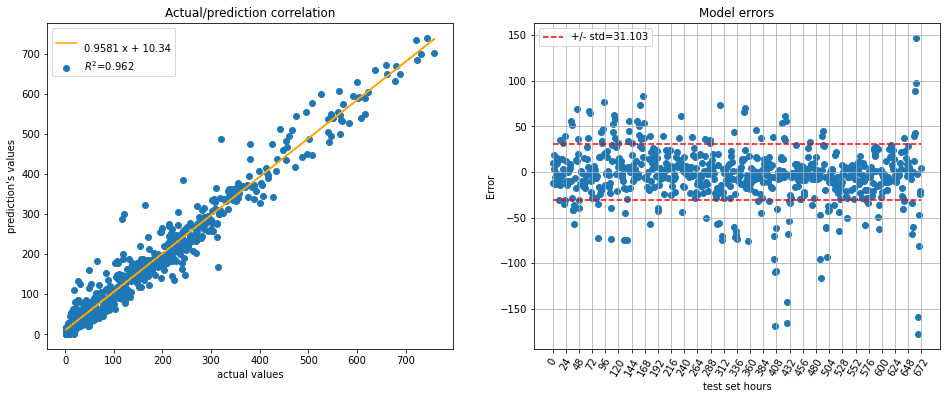

In [ ]:
plot_errors(y_test, predictions)

In [ ]:
params1 = tuner_1.best_params
# be sure to save number of estimators of best model!
params1['n_estimators'] = tuner_1.get_best_booster().best_iteration
print(f'Best parameters of the model: {json.dumps(params1, indent=2)}')

Best parameters of the model: {
  "objective": "regression",
  "metric": "rmse",
  "eval_metric": "rmse",
  "boosting_type": "gbdt",
  "verbosity": -1,
  "feature_pre_filter": false,
  "lambda_l1": 0.2019055894080857,
  "lambda_l2": 3.5275169933928286e-07,
  "num_leaves": 110,
  "feature_fraction": 0.92,
  "bagging_fraction": 1.0,
  "bagging_freq": 0,
  "min_child_samples": 20,
  "n_estimators": 117
}


In [ ]:
params2 = tuner_2.best_params
# be sure to save number of estimators of best model!
params2['n_estimators'] = tuner_2.get_best_booster().best_iteration
print(f'Best parameters of the model: {json.dumps(params2, indent=2)}')

Best parameters of the model: {
  "objective": "regression",
  "metric": "rmse",
  "eval_metric": "rmse",
  "boosting_type": "gbdt",
  "verbosity": -1,
  "feature_pre_filter": false,
  "lambda_l1": 0.010882827930218712,
  "lambda_l2": 0.2708162972907513,
  "num_leaves": 71,
  "feature_fraction": 0.8,
  "bagging_fraction": 0.7260429650751228,
  "bagging_freq": 2,
  "min_child_samples": 20,
  "n_estimators": 147
}


## Conclusion

Two separate models performed better than single model

In [ ]:
params_1 = tuner_1.best_params
params_1['n_estimators'] = tuner_1.get_best_booster().best_iteration
final_model_1 = LGBMRegressor(**params_1, n_jobs=-1, random_state=SEED)
final_model_1.fit(data[features1], data.casual)

params_2 = tuner_2.best_params
params_2['n_estimators'] = tuner_2.get_best_booster().best_iteration
final_model_2 = LGBMRegressor(**params_2, n_jobs=-1, random_state=SEED)
final_model_2.fit(data[features2], data.registered)

predictions_1 = np.around(final_model_1.predict(X_test_1).clip(0), 0)
predictions_2 = np.around(final_model_2.predict(X_test_2).clip(0), 0)
predictions = predictions_1 + predictions_2
mean_squared_error(y_test, predictions, squared=False)

18.645701981447424

## Saving models

In [ ]:
# save models to drive
with open('/content/gdrive/MyDrive/Github/midterm-project/model_1.pkl', 'wb') as file:
    pickle.dump(final_model_1, file, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/gdrive/MyDrive/Github/midterm-project/model_2.pkl', 'wb') as file:
    pickle.dump(final_model_2, file, protocol=pickle.HIGHEST_PROTOCOL)

# Model interpretability

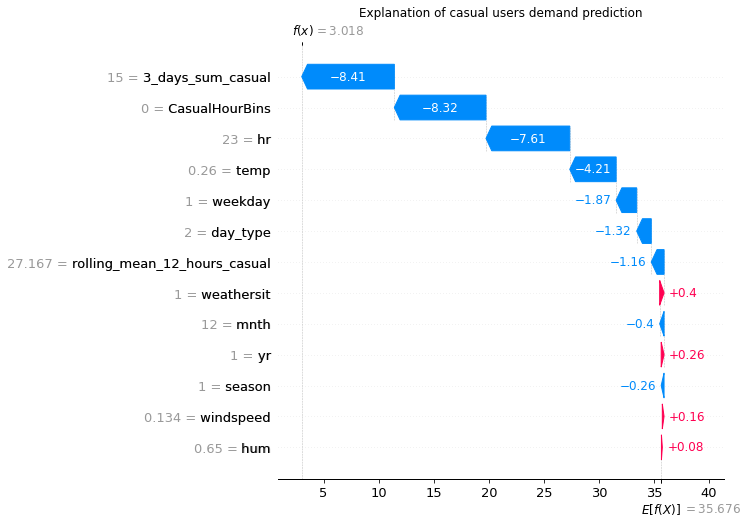

In [ ]:
# predict single point
pred = final_model_1.predict(X_test_1.iloc[671].values.reshape(1, -1))
# explain the model's predictions using SHAP
explainer = shap.Explainer(final_model_1, feature_names=features1)
shap_values = explainer(X_test_1.iloc[671].values.reshape(1, -1))

# visualize the last prediction's explanation
shap.plots.waterfall(shap_values[0], max_display=15, show=False)
plt.title('Explanation of casual users demand prediction')
plt.show()
#plt.savefig('plot.png',format = "png",dpi = 150, bbox_inches = 'tight')

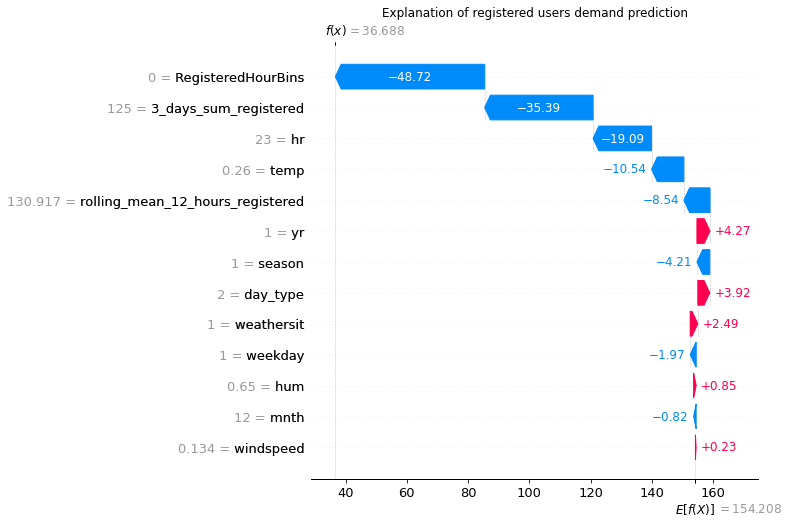

In [ ]:
# predict single point
pred = final_model_2.predict(X_test_2.iloc[671].values.reshape(1, -1))
# explain the model's predictions using SHAP
explainer = shap.Explainer(final_model_2, feature_names=features2)
shap_values = explainer(X_test_2.iloc[671].values.reshape(1, -1))

# visualize the last prediction's explanation
shap.plots.waterfall(shap_values[0], max_display=15, show=False)
plt.title('Explanation of registered users demand prediction')
plt.show()